In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(0)
import random
import json
import pandas as pd
from datetime import datetime, timedelta

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


# Data load 

In [12]:
# Just fo the trial wi with all the new data 
# df = pd.read_csv('C:/Users/Win11/Downloads/20240506_090021_01805_tgfqr.csv')
# df = pd.read_csv('C:/Users/Win11/Downloads/20240507_125312_35927_45gi7.csv')
df = pd.read_csv('C:/Users/Win11/Downloads/20240509_054634_85275_4dsx5.csv')
df = pd.read_csv('C:/Users/Win11/Downloads/20240509_030938_45245_4dsx5.csv')
df_2 = pd.read_csv('C:/Users/Win11/Downloads/20240509_051907_83264_4dsx5.csv')
df = pd.concat([df, df_2], ignore_index = True)
df = df[df['matuirity_day'] == 0]

# df = pd.read_csv('C:/Users/Win11/Downloads/20240509_054634_85275_4dsx5.csv')

print(df.shape)
df.head(5)


(34601, 56)


,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,win_amount_last_14d,win_amount_last_7d,win_money_rate_sequence,max_bet,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18
120426,10207637,2024-01-02 00:49:41.000,0,0,10.0,14,4.0,0,1,1,...,36.17,36.17,[0.64],0.1,0,0,0.0,0.0,0.0,0.0
120428,10208478,2024-01-02 02:46:12.000,0,0,5.0,3,-2.0,0,1,1,...,15.25,15.25,[0.65],0.1,0,0,0.0,528.0,0.0,0.0
120431,10208796,2024-01-02 03:26:03.000,0,0,295.0,774,479.0,0,1,1,...,30.96,30.96,[0.6],0.5,0,0,0.0,0.0,11.0,278.0
120433,10209127,2024-01-02 04:07:55.000,0,0,1.0,12,11.0,0,1,1,...,5.80,5.80,[0.25],1.0,0,0,0.0,187.0,69.0,0.0
120435,10212739,2024-01-02 22:40:03.000,0,0,0.0,10,10.0,0,3,3,...,12.91,12.91,[0.59],0.2,0,0,499.0,0.0,0.0,910.0


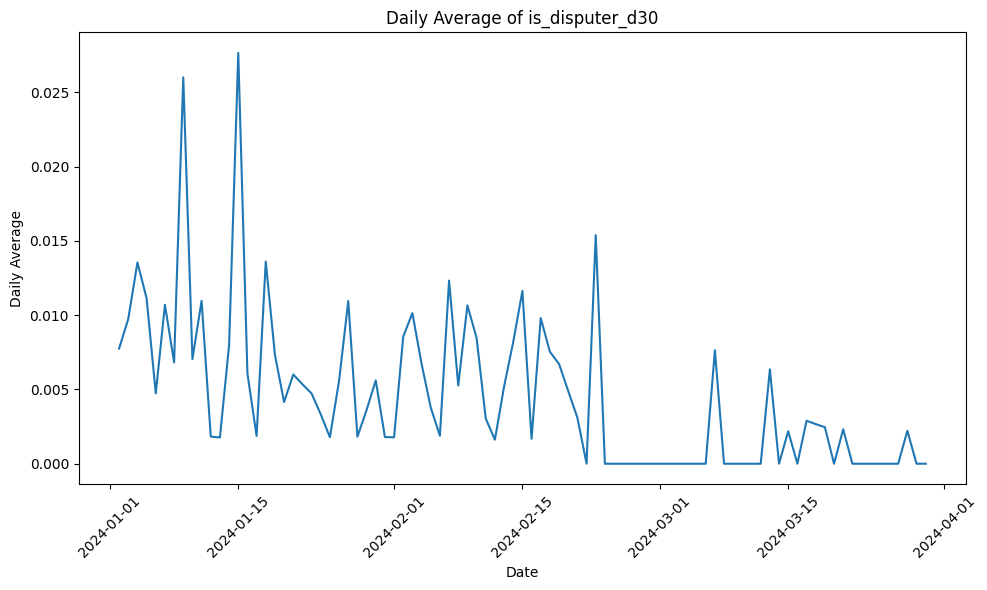

In [3]:
# Convert 'register_time' to datetime
df['register_time'] = pd.to_datetime(df['register_time'])

# Extract date from 'register_time'
df['date'] = df['register_time'].dt.date

# Group by date and calculate daily average of 'is_disputer_d30'
daily_avg = df.groupby('date')['new_disputer_30d'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='new_disputer_30d', data=daily_avg)
plt.title('Daily Average of is_disputer_d30')
plt.xlabel('Date')
plt.ylabel('Daily Average')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



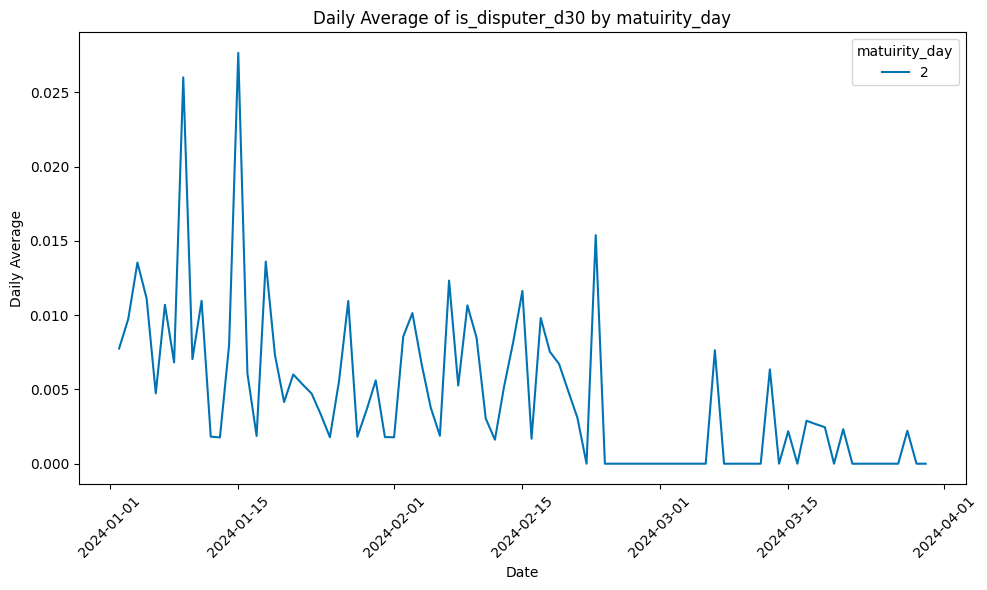

In [5]:

# Convert 'register_time' to datetime
df['register_time'] = pd.to_datetime(df['register_time'])

# Extract date from 'register_time'
df['date'] = df['register_time'].dt.date

# Group by date and calculate daily average of 'is_disputer_d30'
daily_avg = df.groupby(['date', 'matuirity_day'])['new_disputer_30d'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='new_disputer_30d', hue='matuirity_day', data=daily_avg, palette='colorblind')
plt.title('Daily Average of is_disputer_d30 by matuirity_day')
plt.xlabel('Date')
plt.ylabel('Daily Average')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='matuirity_day')
plt.show()



### (Do not run) Code for penalty-based rule

In [152]:
from sklearn.linear_model import LinearRegression

"""
I want a piece of code that runs a sequential regression, it runs 
"""

coefficients = {}

# You can apply just a linear regression and get the coefficients 
for group in df['segments'].unique(): 

    print(group)
    # Filter to the segment 
    train = df[df['segments'] == group]
    train['matuirity_day_adj'] =  pd.qcut(train['matuirity_day'], q=num_quantiles, labels=False, duplicates='drop')
    train['spent_to_date_adj'] =  pd.qcut(train['spent_to_date'], q=num_quantiles, labels=False, duplicates='drop')
    train['bet_money_to_date_adj'] =  pd.qcut(train['bet_money_to_date'], q=num_quantiles, labels=False, duplicates='drop')

    coefficients = {}

    for feature in ['matuirity_day_adj', 'spent_to_date_adj', 'bet_money_to_date_adj']:

        # Initialize Linear Regression model ()
        model = LinearRegression()
        y = train['new_disputer_30d']

        # Fit the model on the original data
        model.fit(train[[feature]].fillna(0), y)

        # Store the initial coefficients
        coefficients[f'{feature}_initial'] = model.coef_[0]

        # Calculate residuals
        residuals = y - model.predict(train[[feature]].fillna(0))

        # Train another model on the residuals
        model_residuals = LinearRegression()
        model_residuals.fit(train[[feature]].fillna(0), residuals)

        # Store the coefficients of the model trained on residuals
        # coefficients[f'{feature}_residuals'] = model_residuals.coef_[0]
    
    print(coefficients)
    

0.0 - New payer
{'matuirity_day_adj_initial': -4.915500824716905e-05, 'spent_to_date_adj_initial': 0.0017931345250978663, 'bet_money_to_date_adj_initial': 1.930781126647315e-06}
1.0 - New payer
{'matuirity_day_adj_initial': 0.00019169953467237726, 'spent_to_date_adj_initial': 0.00013646771239560486, 'bet_money_to_date_adj_initial': 1.226315764536564e-06}
2.0 - New payer
{'matuirity_day_adj_initial': 0.0002716505363020608, 'spent_to_date_adj_initial': -8.911800813360765e-05, 'bet_money_to_date_adj_initial': -5.7700692932048315e-05}
2.0 - nan
{'matuirity_day_adj_initial': -0.0022384830668649167, 'spent_to_date_adj_initial': 0.00020366408789016907, 'bet_money_to_date_adj_initial': 0.00010941307679872372}
1.0 - nan
{'matuirity_day_adj_initial': -0.0010508369136097103, 'spent_to_date_adj_initial': 0.00020086523633242362, 'bet_money_to_date_adj_initial': 1.820645615626979e-05}
0.0 - nan
{'matuirity_day_adj_initial': -0.0006846994414538496, 'spent_to_date_adj_initial': 0.0005823757868390175, 

### (Do not run) Opened box for short term analysis

In [8]:
st_payers['new_disputer_30d'].mean()
st_payers['new_disputer_30d'].mean()
st_payers[st_payers['paying_matuirity'] == 3]['new_disputer_30d'].mean()

0.008407815172613168

In [9]:
lt_recent_payment_df['new_disputer_30d'].mean()
lt_recent_payment_df['new_disputer_30d'].mean()
lt_recent_payment_df[lt_recent_payment_df['matuirity_day'] == 16]['new_disputer_30d'].mean()

0.005221932114882507

- So, the time since install does not impact much, what impacts is the time since payment. New installs pay more, so new users will generate most of the disputes. If they did not made the payment in the first day
- Other areas are also affected when we see that the impact of new users will decrease over time

In [10]:
lt_recent_payment_df['matuirity_day'].unique()

array([112,  41, 104,  18,  39,  82,  58,  60,  61,  16,  48,  24,  19,
        42,  86,  34,  21,  27,  20,  33,  28,  26,  80,  55,  56,  54,
        72,  25,  69,  30,  31,  23,  22,  17,  44,  35,  50,  51,  32,
        53,  36,  38,  52,  46,  29,  47,  37, 114, 105,  90,  74,  43,
        45,  49,  59, 106,  62,  76,  40,  66,  64,  67, 103,  57,  81,
       107,  94,  70,  71,  65, 121,  75,  77,  73,  97, 118,  96,  98,
        87,  68,  78,  84, 117,  63,  91,  85, 102,  79, 113, 109,  89,
       100,  93,  92,  83,  88, 108,  99, 116, 101,  95, 136], dtype=int64)

In [11]:

# The obejctive for the split is just that this payers are different from each other in a non-linear way (For me I can split 3-2, but 3-3 is also great). Overal payment fluctuations can be better understand 

# join but split the three segments 

# Then split by number of payers 

# Then you get the dispute rate 

# Then you correct it to matuirity and to payment matuirity. You also correct it to the number of payments (This is called the standarisation) - Econometric model


So, everything is about the time since payment. This is what matters. The only difference is the information that is available. 

You are also giving me problem with the payments, because different users will have different times after payment. This is the payment maturity and it is all that matters. 

So, what about this? You do the three and then on the last node you separate by matuirity 

In [11]:
st_payers

,#account_id,register_time,matuirity_day,paying_matuirity,time_to_payment,pay_matuirity,payments_to_date,payments_last_14d,payments_last_7d,spent_to_date,...,money_games_last_14d,money_games_last_7d,bet_money_to_date,bet_money_last_14d,bet_money_last_7d,win_amount_to_date,win_amount_last_14d,win_amount_last_7d,past_disputer,new_disputer_30d
0,10007525,2023-10-09 06:57:20.000,0,0,0,0,7,7,7,17.0,...,361.0,361.0,39.15,39.15,39.15,-17.90,-17.90,-17.90,0,0
1,10007525,2023-10-09 06:57:20.000,1,1,0,1,9,9,9,24.0,...,572.0,572.0,60.14,60.14,60.14,-26.65,-26.65,-26.65,0,0
2,10007525,2023-10-09 06:57:20.000,2,2,0,2,11,11,11,28.0,...,930.0,930.0,95.91,95.91,95.91,-29.65,-29.65,-29.65,0,0
3,10007525,2023-10-09 06:57:20.000,3,3,0,3,12,12,12,30.0,...,995.0,995.0,107.05,107.05,107.05,-33.65,-33.65,-33.65,0,0
4,10007525,2023-10-09 06:57:20.000,4,4,0,4,13,13,13,32.0,...,1006.0,1006.0,108.15,108.15,108.15,-34.45,-34.45,-34.45,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218375,10499390,2024-02-18 04:38:07.000,0,0,0,0,1,1,1,20.0,...,255.0,255.0,124.40,124.40,124.40,151.30,151.30,151.30,0,0
218376,10499991,2024-02-18 06:08:00.000,0,0,0,0,2,2,2,7.0,...,201.0,201.0,177.50,177.50,177.50,153.64,153.64,153.64,0,0
218377,10500673,2024-02-18 08:42:25.000,0,0,0,0,1,1,1,20.0,...,182.0,182.0,71.10,71.10,71.10,40.56,40.56,40.56,0,0
218378,10501863,2024-02-18 17:27:34.000,0,0,0,0,3,3,3,10.0,...,211.0,211.0,44.99,44.99,44.99,25.55,25.55,25.55,0,0


In [12]:
result = st_payers[st_payers['payments_to_date'] == 1].copy(deep = True).fillna(0)
result['disputer'] =  result['new_disputer_30d']

# TS CV split
validation_sets = 3
result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
result.groupby('validation_set_id').size()

# Define the model 
def create_model(criterion, depth, leaf_size):

    pipe = Pipeline([
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [13]:
cols = ['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date'
        ,  'payments_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']

In [123]:

df.columns

Index(['#account_id', 'register_time', 'matuirity_day', 'paying_matuirity',
       'time_to_payment', 'pay_matuirity', 'payments_to_date',
       'payments_last_14d', 'payments_last_7d', 'spent_to_date',
       ...
       'pay__[1,1,0,0,0]', 'pay__[1,1,0,0]', 'pay__[1,1,0]',
       'pay__[1,1,1,1,1,1,1]', 'pay__[1,1,1,1,1,1]', 'pay__[1,1,1,1,1]',
       'pay__[1,1,1,1]', 'pay__[1,1,1]', 'pay__[1,1]', 'pay__[1]'],
      dtype='object', length=241)

In [15]:

model_results = []
all_model_results = []
criteria = ['log_loss']
depths = [5]
leaf_sizes = [50]
payment_cols = cols + ['disputer']

# for train_index, test_index in splits:
for date_group in result['matuirity_day'].unique():
for date_group in [result['matuirity_day'].unique()]:

    # train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['matuirity_day'] == date_group][payment_cols]
    train_data =  result[result['validation_set_id'] == date_group][payment_cols]
    train_data =  result[payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])



IndentationError: expected an indented block after 'for' statement on line 9 (1402966354.py, line 10)

# Implementation


## Matuirity 1

In [4]:
# REMOVE FEATURES AND DUMMIFY SEQUENCES 

df['max_payment']           = df['max_payment']     / df['spent_to_date']
df['max_daily_spent']       = df['max_daily_spent'] / df['spent_to_date']
df['day_1_count_payment']   = (df['daily_payment_history_count'].apply(lambda x: x.replace('[', '').replace(']', '').split(',')[0])).astype(float)
df['day_1_total_payment']   = (df['daily_spent_history_count'].apply(lambda x: x.replace('[', '').replace(']', '').split(',')[0])).astype(float)
# df['d2_3_total_payment']    = (df['daily_spent_history_count'].apply(lambda x: x.replace('[', '').split(',')[1] + x.replace('[', '').split(',')[2])).astype(float)

df['max_games_daily_games'] = df['max_games_daily_games'] / df['games_to_date']
df['daily_games_first_1d']  = df['daily_games_first_1d']  / df['games_to_date']

df['games_to_date']         = df['local_time_before_6'] + df['local_time_6_to_12'] + df['local_time_12_to_18'] + df['local_time_after_18'] 
df['local_time_before_6']   = df['local_time_before_6'] / df['games_to_date']
df['local_time_6_to_12']    = df['local_time_6_to_12']  / df['games_to_date']
df['local_time_12_to_18']   = df['local_time_12_to_18'] / df['games_to_date']
df['local_time_after_18']   = df['local_time_after_18'] / df['games_to_date']
 
df['win_spent_ratio']       = df['win_amount_to_date']  / (df['spent_to_date']+0.0001)
 
# Retention 
df['full_[retention]']      = df['retention_sequence'].apply(lambda x: x[-2])
df['full_pay_[retention]']  = df['daily_payment_history_binary'].apply(lambda x: x[-2])

# Growth 
# df['d2_3_total_payment']        = (df['daily_spent_history_count'].apply(lambda x: float(x.replace('[', '').split(',')[1]) + float(x.replace('[', '').replace(']', '').split(',')[2]))).astype(float)
# df['d2_3_total_payment_rel']    = (df['daily_spent_history_count'].apply(lambda x: float(x.replace('[', '').split(',')[1]) + float(x.replace('[', '').replace(']', '').split(',')[2]))).astype(float) / df['day_1_total_payment']
# df['d5_7_total_payment_rel']    = (df['daily_spent_history_count'].apply(lambda x: float(x.replace('[', '').split(',')[1]) + float(x.replace('[', '').replace(']', '').split(',')[2]))).astype(float) / df['d2_3_total_payment']
# del df['d2_3_total_payment']

# Last days 

# Base Cols
cols = [
        # 'paying_matuirity', 'spent_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent'
        'paying_matuirity', 'spent_to_date','max_daily_spent'
        
        # , 'max_payment', 'payments_last_14d', 'payments_last_7d',  'payments_to_date',  'minutes_to_payment', 'minutes_to_pay_since_first_game'
        , 'max_payment', 'payments_to_date',  'minutes_to_payment', 'minutes_to_pay_since_first_game'
        
        # , 'games_last_14d', 'games_last_7d', 'games_to_date', 'max_games_daily_games', 'daily_games_first_14d', 'daily_games_first_7d', 'daily_games_first_1d', 'minutes_to_play'
        , 'games_to_date', 'max_games_daily_games', 'daily_games_first_1d', 'minutes_to_play'
        
        # , 'money_games_to_date', 'bet_money_to_date', 'max_bet',  'money_games_last_14d', 'money_games_last_7d'
        , 'money_games_to_date', 'bet_money_to_date', 'max_bet'

        # , 'win_amount_to_date',  'win_amount_last_14d', 'win_amount_last_7d'
        , 'win_amount_to_date'
        
        , 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date'
        
        , 'local_time_before_6', 'local_time_6_to_12', 'local_time_12_to_18', 'local_time_after_18'
        ]

# I. Truncate sequences to the last 14 days
columns_of_interest = ['retention_sequence', 'days_betting_money_sequence', 'days_50_usd_bet_money_sequence', 'daily_payment_history_binary']  # Add additional columns here if needed
def truncate_list(lst):
    return lst[-14:]
for column in columns_of_interest:
    df[column] = df[column].apply(truncate_list)

# II. Execute the dummification
columns_info = {'retention_sequence': 'playing_days_'
                # , 'money_bet_sequence': 'money_bet_'
                , 'daily_payment_history_binary': 'payer_'
                # , 'daily_payment_history_count': 'pay_'
                , 'days_betting_money_sequence': 'days_bet_'
                , 'days_50_usd_bet_money_sequence': 'days_gt50_bet_'
                # , 'province': 'province_'
                }  # Add additional columns and identifiers here if needed

dummy_variable_list = []  # List to store dummy variables generated for each column

for column, identifier in columns_info.items():
    # Calculate sum of 'new_disputer_30d' for each unique value in the column
    sum_disputer = df.groupby(column)['new_disputer_30d'].sum()
    # Filter unique values where sum is >= 12
    valid_values = sum_disputer[sum_disputer >= 15].index.tolist()
    # Generate dummy variables for valid values
    dummy_variables = pd.get_dummies(df[column].loc[df[column].isin(valid_values)], prefix=identifier).astype(int)
    dummy_variable_list.append(dummy_variables)
    df = pd.concat([df, dummy_variables], axis=1)

# Concatenate all dummy variables into a single DataFrame
final_dummy_variables = pd.concat(dummy_variable_list, axis=1)
cols = cols + list(final_dummy_variables.columns)

# III. Can remove extra items
items_to_remove = ['working_hours_bets_to_date', 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date', 'province']
cols = [item for item in cols if item not in items_to_remove]
final_dummy_variables.columns


Index(['playing_days__[1]', 'payer__[1]', 'days_bet__[0]', 'days_bet__[1]',
       'days_gt50_bet__[0]', 'days_gt50_bet__[1]'],
      dtype='object')

In [9]:
# print(df['register_time'].max())
# print(df['register_time'].min())
# datetime.now() - timedelta(days = 120)

2024-03-30 23:57:37
2024-01-02 00:01:12


datetime.datetime(2024, 1, 9, 8, 53, 35, 556791)

In [10]:
# # DATA PARTITION (Objective is just small verification. My model should not overfit greatly)
# from datetime import datetime, timedelta

# # Calculate the date 30 days ago
# limit = datetime.now() - timedelta(days = 116)
# df['register_time'] = pd.to_datetime(df['register_time'])

# # Filter the DataFrame to include only rows where the register time is before the last 30 days
# test_df = df[df['register_time'] >= limit].copy(deep = True)
# # df = df[df['register_time'] > '2024-01-01']
# df = df[df['register_time'] < limit]

# print(df['register_time'].max())
# print(df['register_time'].min())
# print()
# print(test_df['register_time'].max())
# print(test_df['register_time'].min())

2024-01-13 08:53:00
2024-01-02 00:01:12

2024-03-30 23:57:37
2024-01-13 08:57:20


In [16]:
# import pandas as pd

# # Assuming df is your DataFrame with the specified columns

# # Define the number of quantiles
# num_quantiles = 5

# # Calculate quantiles and get bin edges
# games_played_quantile, games_played_bins = pd.qcut(df['games_to_date'], num_quantiles, retbins=True, duplicates='drop')
# max_daily_spent_quantile, max_daily_spent_bins = pd.qcut(df['max_daily_spent'], num_quantiles, retbins=True, duplicates='drop')
# spending_quantile, spending_bins = pd.qcut(df['spent_to_date'], num_quantiles, retbins=True, duplicates='drop')
# bet_money_quantile, bet_money_bins = pd.qcut(df['bet_money_to_date'], num_quantiles, retbins=True, duplicates='drop')

# # Round the bin edges
# games_played_bins = [round(edge, 1) for edge in games_played_bins]
# max_daily_spent_bins = [round(edge, 1) for edge in max_daily_spent_bins]
# spending_bins = [round(edge, 1) for edge in spending_bins]
# bet_money_bins = [round(edge, 1) for edge in bet_money_bins]

# # Save bin edges as new columns

# df['games_played_quantile'] = pd.cut(df['games_to_date'], bins=games_played_bins, labels=games_played_bins[:-1], include_lowest=True).astype(float)
# df['max_daily_spent_quantile'] = pd.cut(df['max_daily_spent'], bins=max_daily_spent_bins, labels=max_daily_spent_bins[:-1], include_lowest=True).astype(float)
# df['spending_quantile'] = pd.cut(df['spent_to_date'], bins=spending_bins, labels=spending_bins[:-1], include_lowest=True).astype(float)
# df['bet_money_quantile'] = pd.cut(df['bet_money_to_date'], bins=bet_money_bins, labels=bet_money_bins[:-1], include_lowest=True).astype(float)


# # Calculate win-spent ratio
# df['win_spent_ratio'] = df['win_amount_to_date'] / df['spent_to_date']

# # Calculate quantiles for win-spent ratio and get bin edges
# win_spent_ratio_quantile, win_spent_ratio_bins = pd.qcut(df['win_spent_ratio'], num_quantiles, retbins=True, duplicates='drop')

# # Round the bin edges
# win_spent_ratio_bins = [round(edge, 3) for edge in win_spent_ratio_bins]

# # Save rounded bin edges as a new column
# df['win_spent_ratio_quantile'] = pd.cut(df['win_spent_ratio'], bins=win_spent_ratio_bins, labels=win_spent_ratio_bins[:-1], include_lowest=True).astype(float)


# # Specify the columns
# cols = ['games_played_quantile', 'max_daily_spent_quantile', 'spending_quantile', 'bet_money_quantile', 'win_spent_ratio_quantile']

# # Print the DataFrame
# df[cols]



,games_played_quantile,max_daily_spent_quantile,spending_quantile,bet_money_quantile,win_spent_ratio_quantile
0,1655.2,35.0,40.0,335.9,2.093
1,333.0,2.0,2.0,43.2,9.206
2,333.0,2.0,2.0,15.0,4.207
3,712.4,15.0,18.0,110.0,4.207
4,138.0,4.0,4.0,15.0,0.778
...,...,...,...,...,...
37641,712.4,15.0,18.0,43.2,0.778
37642,333.0,35.0,18.0,110.0,4.207
37643,138.0,2.0,2.0,0.0,2.093
37644,333.0,15.0,18.0,110.0,2.093


In [17]:
# import pandas as pd

# # Assuming test_df is your DataFrame with the specified columns

# # Define the number of quantiles
# num_quantiles = 5

# # Calculate quantiles and get bin edges
# games_played_quantile, games_played_bins = pd.qcut(test_df['games_to_date'], num_quantiles, retbins=True, duplicates='drop')
# max_daily_spent_quantile, max_daily_spent_bins = pd.qcut(test_df['max_daily_spent'], num_quantiles, retbins=True, duplicates='drop')
# spending_quantile, spending_bins = pd.qcut(test_df['spent_to_date'], num_quantiles, retbins=True, duplicates='drop')
# bet_money_quantile, bet_money_bins = pd.qcut(test_df['bet_money_to_date'], num_quantiles, retbins=True, duplicates='drop')

# # Round the bin edges
# games_played_bins = [round(edge, 1) for edge in games_played_bins]
# max_daily_spent_bins = [round(edge, 1) for edge in max_daily_spent_bins]
# spending_bins = [round(edge, 1) for edge in spending_bins]
# bet_money_bins = [round(edge, 1) for edge in bet_money_bins]

# # Save bin edges as new columns

# test_df['games_played_quantile'] = pd.cut(test_df['games_to_date'], bins=games_played_bins, labels=games_played_bins[:-1], include_lowest=True).astype(float)
# test_df['max_daily_spent_quantile'] = pd.cut(test_df['max_daily_spent'], bins=max_daily_spent_bins, labels=max_daily_spent_bins[:-1], include_lowest=True).astype(float)
# test_df['spending_quantile'] = pd.cut(test_df['spent_to_date'], bins=spending_bins, labels=spending_bins[:-1], include_lowest=True).astype(float)
# test_df['bet_money_quantile'] = pd.cut(test_df['bet_money_to_date'], bins=bet_money_bins, labels=bet_money_bins[:-1], include_lowest=True).astype(float)


# # Calculate win-spent ratio
# test_df['win_spent_ratio'] = test_df['win_amount_to_date'] / test_df['spent_to_date']

# # Calculate quantiles for win-spent ratio and get bin edges
# win_spent_ratio_quantile, win_spent_ratio_bins = pd.qcut(test_df['win_spent_ratio'], num_quantiles, retbins=True, duplicates='drop')

# # Round the bin edges
# win_spent_ratio_bins = [round(edge, 3) for edge in win_spent_ratio_bins]

# # Save rounded bin edges as a new column
# test_df['win_spent_ratio_quantile'] = pd.cut(test_df['win_spent_ratio'], bins=win_spent_ratio_bins, labels=win_spent_ratio_bins[:-1], include_lowest=True).astype(float)


# # Specify the columns
# cols = ['games_played_quantile', 'max_daily_spent_quantile', 'spending_quantile', 'bet_money_quantile', 'win_spent_ratio_quantile']

# # Print the DataFrame
# test_df[cols]


### Train DT

In [71]:
# TRAIN THE SYSTEM 

# You can try to include matuirity as a penalty and see what approach works better 
from sklearn.tree import _tree
import pandas as pd
from tqdm import tqdm

# Define the model 
def create_model(criterion, depth, leaf_size):

    pipe = Pipeline([
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe

def traverse_tree(tree, node_id = 0, depth = 0, dataset = None, path = None):

    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Disputer rate"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right) 
        # print('function here is okay')    
    
    else:
        leaf_size = np.sum(tree.value[node_id])
        # print('leaf_size', leaf_size)
        # print('else here is okay')
        # print(len(tree.value[node_id][0]))
        if len(tree.value[node_id][0]) > 1: 
            true_cases = tree.value[node_id][0][1]
        else: 
            true_cases = 0
        # print('else here is okay oh oh')
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        # print('有问题')
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Disputer rate": [proportion_true],
                                                    "Payers": [leaf_size], "Disputers": [true_cases]})], ignore_index=True)

    return dataset
    
high_level_dt = pd.DataFrame(columns = ["segments", "Event", "Disputer rate", "Payers", "Disputers"])  # Initiate an empty DataFrame to hold all datasets
model_results = []
all_model_results = []
criterion = 'log_loss'
depth = 7
leaf_size = 150
payment_cols = cols + ['new_disputer_30d']
segments = [1]
df['segments'] = 'User'
# Loop through segments
for segment in tqdm(df['segments'].unique()):
# for segment in ['maturity_day < 14 & payments > 1']:

    # Get fraction of everything_df based on segment
    result = df[df['segments'] == segment].fillna(0)
    payment_cols = cols + list(final_dummy_variables.columns) + ['new_disputer_30d']
    
    # Loop through matuirity days
    for maturity in result['matuirity_day'].unique(): 
    # for maturity in [1]: 

        # print(maturity)
        # Generate the Tree dataset and concatenate 
        train_data = result[result['matuirity_day'] == maturity][payment_cols]
        # print(train_data.shape[0])
        X_train, y_train = train_data.drop(columns = ['new_disputer_30d']), train_data['new_disputer_30d'] 
        # Train 
        clf = create_model(criterion, depth, leaf_size)

        clf.fit(X_train[cols], y_train)
        # print('meiyouyijian')
        # print('ok2')
        # Save the model into dictionary (Response, day, mo...)
        model_result = pd.DataFrame({
            'Matuirity': [maturity],
            'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)],
            'Model': [clf]
        })
        # print('命运')

        # Generate the dataset structure
        tree = clf[0].tree_
        # print(tree)
        # print('意见0')
        dataset = traverse_tree(tree)

        # try: 
        #     dataset = traverse_tree(tree)
        # except: 
        #     print('ojo')
        # print('意见1')
        event_columns = dataset['Event'].str.split(' & ', expand = True)
        # print('意见2')
        dataset = pd.concat([dataset, event_columns], axis = 1)
        dataset.insert(0, "Matuirity", maturity + 1)
        dataset.insert(0, "Segment", segment)
        high_level_dt = pd.concat([high_level_dt, dataset], ignore_index = True)


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


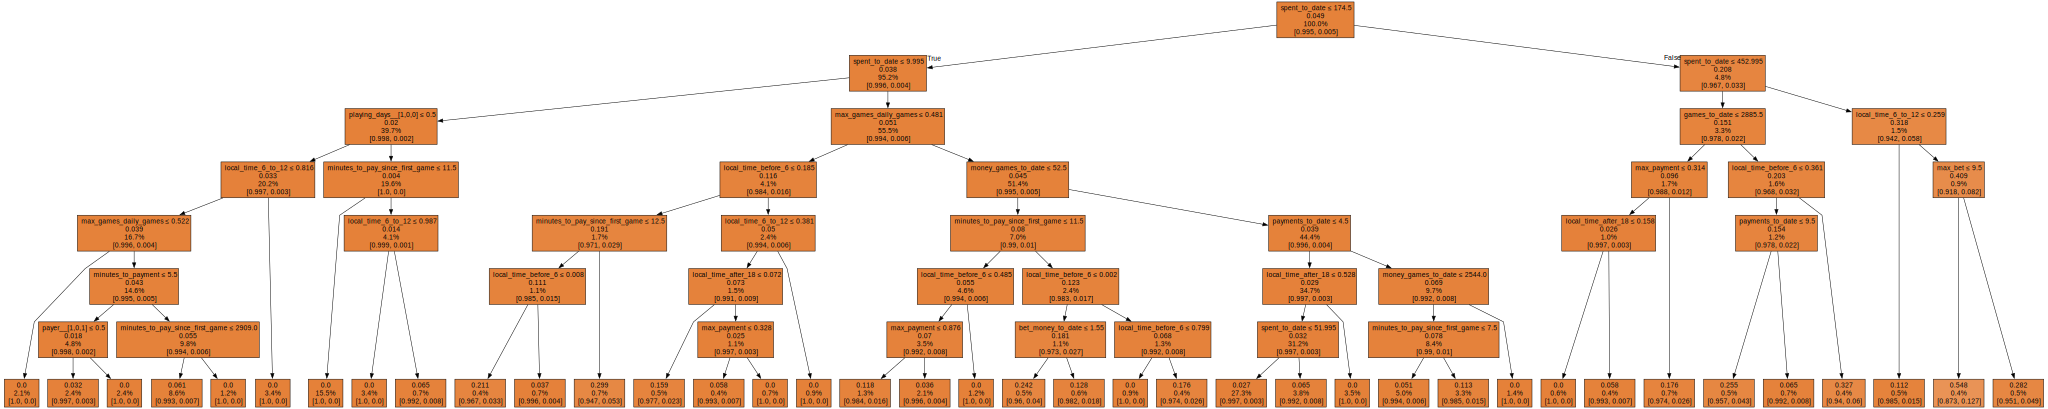

In [72]:
# SHOW ME ONE OF THE TREES

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz


# Create the decision tree classifier
# clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 6 - 200']['Model'].values[0][0]
clf = model_result['Model'].values[0][0]


# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = X_train.columns
                           # ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)
# print(dot_data)



In [88]:
high_level_dt

,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Disputer rate,Payers,Disputers
0,maturity_day < 14 & payments > 1,9.0,spending_quantile > 39.0,bet_money_quantile > 341.55,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,games_played_quantile > 1980.5,0.066667,210.0,14.0
1,maturity_day < 14 & payments > 1,8.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,None,0.056940,281.0,16.0
2,maturity_day < 14 & payments > 1,11.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,None,0.043860,342.0,15.0
3,maturity_day < 14 & payments > 1,10.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,None,0.041534,313.0,13.0
4,maturity_day < 14 & payments > 1,12.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile ≤ 25.0,bet_money_quantile ≤ 341.55,None,0.040000,100.0,4.0
...,...,...,...,...,...,...,...,...,...,...
315,maturity_day < 14 & payments > 1,14.0,spending_quantile ≤ 39.0,games_played_quantile ≤ 299.5,win_spent_ratio_quantile ≤ 1.61,bet_money_quantile > 7.3,max_daily_spent_quantile > 25.0,0.000000,106.0,0.0
316,maturity_day > 14 & paying_matuirity > 14 & pa...,15.0,bet_money_quantile ≤ 341.55,games_played_quantile ≤ 761.0,max_daily_spent_quantile > 11.5,bet_money_quantile > 95.45,None,0.000000,188.0,0.0
317,maturity_day < 14 & payments > 1,14.0,spending_quantile ≤ 39.0,games_played_quantile ≤ 299.5,win_spent_ratio_quantile ≤ 1.61,bet_money_quantile ≤ 7.3,max_daily_spent_quantile ≤ 11.5,0.000000,538.0,0.0
318,maturity_day > 14 & paying_matuirity > 14 & pa...,15.0,bet_money_quantile ≤ 341.55,games_played_quantile > 761.0,None,None,None,0.000000,761.0,0.0


In [74]:
# CLEAN AND SHOW THE TABLE

high_level_dt.rename(columns={i: f"Condition {i + 1}" for i in range(7)}, inplace=True)
high_level_dt = high_level_dt[['Segment', 'Matuirity', 'Condition 1', 'Condition 2', 'Condition 3', 'Condition 4', 'Condition 5', 'Condition 6', 'Condition 7', 'Disputer rate', 'Payers', 'Disputers']].sort_values(by='Disputer rate', ascending=False).reset_index(drop = True)
# high_level_dt = high_level_dt[['Segment', 'Matuirity', 'Condition 1', 'Condition 2', 'Condition 3', 'Condition 4', 'Condition 5'
#                                , 'Condition 6', 'Condition 7', 'Condition 8', 'Condition 9', 'Condition 10'
#                                , 'Disputer rate', 'Payers', 'Disputers']].sort_values(by='Disputer rate', ascending=False).reset_index(drop = True)

high_level_dt.head(6)
# high_level_dt[high_level_dt['Matuirity'] <= 7].head(700)


,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Condition 6,Condition 7,Disputer rate,Payers,Disputers
0,User,3.0,spent_to_date > 174.5,spent_to_date > 452.995,local_time_6_to_12 > 0.259,max_bet ≤ 9.5,None,None,None,0.126667,150.0,19.0
1,User,3.0,spent_to_date > 174.5,spent_to_date ≤ 452.995,games_to_date > 2885.5,local_time_before_6 > 0.361,None,None,None,0.060000,150.0,9.0
2,User,3.0,spent_to_date ≤ 174.5,spent_to_date > 9.995,max_games_daily_games ≤ 0.481,local_time_before_6 ≤ 0.185,minutes_to_pay_since_first_game > 12.5,None,None,0.053061,245.0,13.0
3,User,3.0,spent_to_date > 174.5,spent_to_date > 452.995,local_time_6_to_12 > 0.259,max_bet > 9.5,None,None,None,0.049020,204.0,10.0
4,User,3.0,spent_to_date > 174.5,spent_to_date ≤ 452.995,games_to_date > 2885.5,local_time_before_6 ≤ 0.361,payments_to_date ≤ 9.5,None,None,0.042781,187.0,8.0
5,User,3.0,spent_to_date ≤ 174.5,spent_to_date > 9.995,max_games_daily_games > 0.481,money_games_to_date ≤ 52.5,minutes_to_pay_since_first_game > 11.5,local_time_before_6 ≤ 0.002,bet_money_to_date ≤ 1.55,0.040000,175.0,7.0


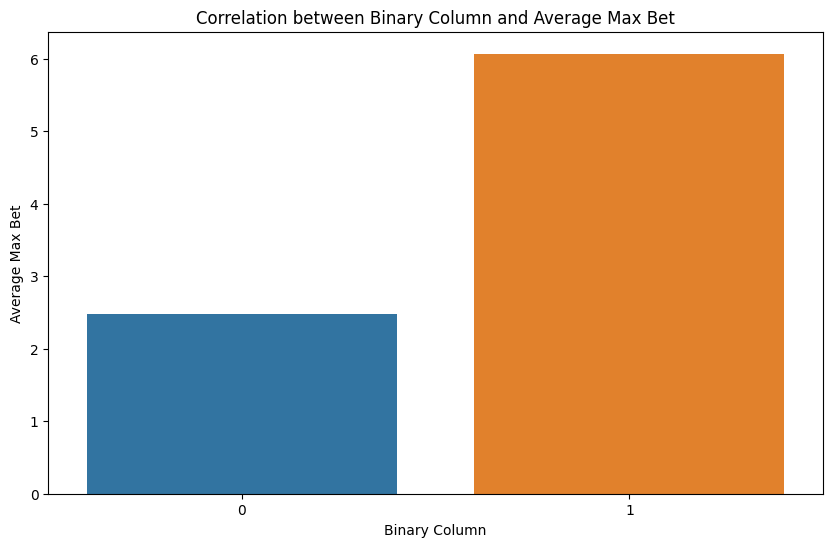

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the proportion of the binary column based on 'max_bet'
# Assuming the binary column is named 'binary_column'
binary_column_proportion = df.groupby('new_disputer_30d')['max_bet'].mean()

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=binary_column_proportion.index, y=binary_column_proportion.values)
plt.xlabel('Binary Column')
plt.ylabel('Average Max Bet')
plt.title('Correlation between Binary Column and Average Max Bet')
plt.show()


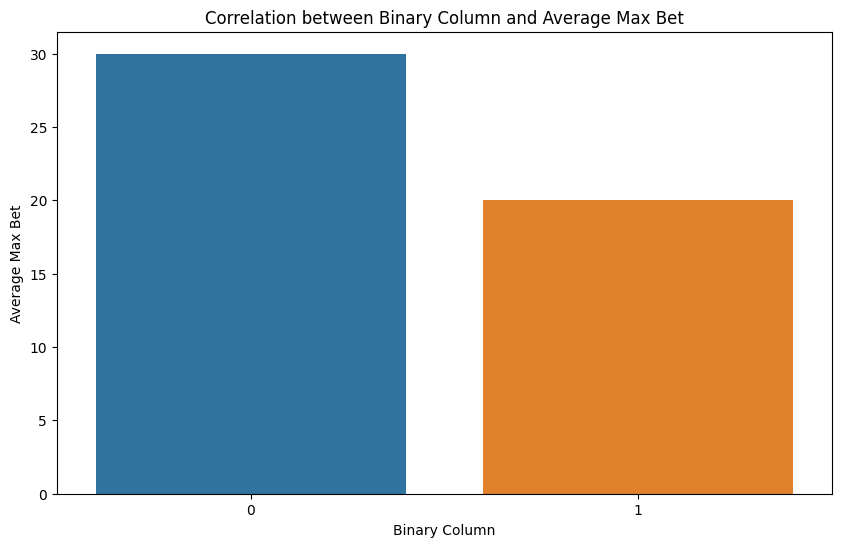

In [84]:
df_filtered = df[df['spent_to_date'] > 452.995]

binary_column_proportion = df_filtered.groupby('new_disputer_30d')['max_bet'].mean()

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=binary_column_proportion.index, y=binary_column_proportion.values)
plt.xlabel('Binary Column')
plt.ylabel('Average Max Bet')
plt.title('Correlation between Binary Column and Average Max Bet')
plt.show()



**Clear patters:** 

- High spend 
- Playing during working hours 
- High number of games

**Maybe patters**

For users with certain payment ammount (This users show an early passivity that can be translated into a higher propensity of dispute): 

- Take time to start playing
- Don't play much
- High number of games



In [86]:
import pandas as pd

# Assuming df is your DataFrame with the specified columns

# Define the number of quantiles
num_quantiles = 5

# Calculate quantiles and get bin edges
games_played_quantile, games_played_bins = pd.qcut(df['games_to_date'], num_quantiles, retbins=True, duplicates='drop')
max_daily_spent_quantile, max_daily_spent_bins = pd.qcut(df['max_daily_spent'], num_quantiles, retbins=True, duplicates='drop')
spending_quantile, spending_bins = pd.qcut(df['spent_to_date'], num_quantiles, retbins=True, duplicates='drop')
bet_money_quantile, bet_money_bins = pd.qcut(df['bet_money_to_date'], num_quantiles, retbins=True, duplicates='drop')

# Round the bin edges
games_played_bins = [round(edge, 1) for edge in games_played_bins]
max_daily_spent_bins = [round(edge, 1) for edge in max_daily_spent_bins]
spending_bins = [round(edge, 1) for edge in spending_bins]
bet_money_bins = [round(edge, 1) for edge in bet_money_bins]

# Save bin edges as new columns

df['games_played_quantile'] = pd.cut(df['games_to_date'], bins=games_played_bins, labels=games_played_bins[:-1], include_lowest=True).astype(float)
df['max_daily_spent_quantile'] = pd.cut(df['max_daily_spent'], bins=max_daily_spent_bins, labels=max_daily_spent_bins[:-1], include_lowest=True).astype(float)
df['spending_quantile'] = pd.cut(df['spent_to_date'], bins=spending_bins, labels=spending_bins[:-1], include_lowest=True).astype(float)
df['bet_money_quantile'] = pd.cut(df['bet_money_to_date'], bins=bet_money_bins, labels=bet_money_bins[:-1], include_lowest=True).astype(float)


# Calculate win-spent ratio
df['win_spent_ratio'] = df['win_amount_to_date'] / df['spent_to_date']

# Calculate quantiles for win-spent ratio and get bin edges
win_spent_ratio_quantile, win_spent_ratio_bins = pd.qcut(df['win_spent_ratio'], num_quantiles, retbins=True, duplicates='drop')

# Round the bin edges
win_spent_ratio_bins = [round(edge, 3) for edge in win_spent_ratio_bins]

# Save rounded bin edges as a new column
df['win_spent_ratio_quantile'] = pd.cut(df['win_spent_ratio'], bins=win_spent_ratio_bins, labels=win_spent_ratio_bins[:-1], include_lowest=True).astype(float)


# Specify the columns
cols = ['games_played_quantile', 'max_daily_spent_quantile', 'spending_quantile', 'bet_money_quantile', 'win_spent_ratio_quantile']

# Print the DataFrame
df[cols]



TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [87]:
cols

['paying_matuirity',
 'spent_to_date',
 'max_daily_spent',
 'max_payment',
 'payments_to_date',
 'minutes_to_payment',
 'minutes_to_pay_since_first_game',
 'games_to_date',
 'max_games_daily_games',
 'daily_games_first_1d',
 'minutes_to_play',
 'money_games_to_date',
 'bet_money_to_date',
 'max_bet',
 'win_amount_to_date',
 'local_time_before_6',
 'local_time_6_to_12',
 'local_time_12_to_18',
 'local_time_after_18',
 'playing_days__[1,0,0]',
 'playing_days__[1,0,1]',
 'playing_days__[1,1,0]',
 'playing_days__[1,1,1]',
 'payer__[1,0,0]',
 'payer__[1,0,1]',
 'payer__[1,1,0]',
 'payer__[1,1,1]',
 'days_bet__[0,0,0]',
 'days_bet__[1,0,0]',
 'days_bet__[1,0,1]',
 'days_bet__[1,1,0]',
 'days_bet__[1,1,1]',
 'days_gt50_bet__[0,0,0]',
 'days_gt50_bet__[0,0,1]',
 'days_gt50_bet__[1,0,0]',
 'days_gt50_bet__[1,1,0]',
 'days_gt50_bet__[1,1,1]']

### Combinations rule 

- Convert the columns into their quantiles 

- Then give me each combination of two 

In [6]:
# df = df[df['matuirity_day'] == 2]
num_cols = [
            # 'spent_to_date', 'max_daily_spent', 'max_payment', 'payments_to_date', 'minutes_to_payment', 'minutes_to_pay_since_first_game', 
            # 'games_to_date', 'max_games_daily_games', 'daily_games_first_1d', 'minutes_to_play', 'money_games_to_date', 'bet_money_to_date', 'max_bet',
            # 'local_time_before_6', 'local_time_6_to_12', 'local_time_12_to_18', 'local_time_after_18',
            'win_spent_ratio', 'day_1_count_payment', 'day_1_total_payment'
            ]

def quantile_binning(df, columns, num_quantiles):

    # Get the qauntile for each column. 

    bins_dict = {}
    quantile_columns = {}
    
    for column in columns:
        # Calculate quantile bins
        quantile_labels, quantile_bins = pd.qcut(df[column], num_quantiles, retbins=True, duplicates='drop')
        
        # Remove duplicate values from bin edges
        quantile_bins = sorted(set(quantile_bins))
        
        # Apply binning to the column
        new_column_name = f"{column}_quantile"
        df[new_column_name] = pd.cut(df[column], bins=quantile_bins, labels=quantile_bins[:-1], include_lowest=True).astype(float)
        
        # Store the bins for each column
        bins_dict[column] = quantile_bins
        
        # Store the quantile column names
        quantile_columns[column] = new_column_name
    
    return df, bins_dict, quantile_columns

def quantile_dummies(df, column, quantile_bins):

    # Create dummy variables for each quantile
    for i in range(1, len(quantile_bins)):
        n = round(quantile_bins[i], 3)
        dummy_name = f"{column}_gt_{n}_true"
        df[dummy_name] = (df[column] > quantile_bins[i-1]).astype(int)

    return df

def quantile_dummies_all(df, num_cols, quantile_columns):

    for column in num_cols:
        quantile_column = quantile_columns.get(column)
        if quantile_column:
            quantile_bins = sorted(set(df[quantile_column]))
            quantile_bins = [x for x in quantile_bins if pd.notna(x)]
            df = quantile_dummies(df, column, quantile_bins)
    
    return df

df, bins_dict, quantile_columns = quantile_binning(df, num_cols, num_quantiles = 1200)
df = quantile_dummies_all(df, num_cols, quantile_columns)


In [6]:
# df[list(quantile_columns.values())]

# column = 'minutes_to_pay_since_first_game'
# quantile_column = quantile_columns.get(column)
# quantile_bins = sorted(set(df[quantile_column]))
# quantile_bins


[-45992.0,
 -18.0,
 1121.5,
 1134.0,
 1146.0,
 1159.0,
 1174.0,
 1186.0,
 1198.0,
 1210.760000000002,
 1228.0,
 1239.0,
 1251.0,
 1261.0,
 nan,
 nan,
 nan,
 1272.6600000000035,
 nan,
 1287.8399999999965,
 nan,
 nan,
 1302.020000000004,
 nan,
 1315.0,
 nan,
 nan,
 1325.3799999999974,
 nan,
 nan,
 nan,
 nan,
 1342.5599999999977,
 nan,
 nan,
 1353.7400000000052,
 nan,
 nan,
 1367.0,
 nan,
 1380.0,
 nan,
 1397.0,
 nan,
 1406.4599999999991,
 nan,
 nan,
 1418.0,
 nan,
 nan,
 1428.8199999999997,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -422.90000000000003,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -67.64,
 nan,
 -9.0,
 nan,
 nan,
 nan,
 -7.0,
 nan,
 -27.

In [7]:
sequence_cols = [col for col in df.columns if col.endswith(']')]
quantile_col_ok = [col[:-5] for col in df.columns if col.endswith('_true')]
df.columns = [col[:-5] if col.endswith('_true') else col for col in df.columns]

cols_2 = list(quantile_col_ok) + list(sequence_cols)
cols_2


['win_spent_ratio_gt_0.003',
 'win_spent_ratio_gt_0.01',
 'win_spent_ratio_gt_0.014',
 'win_spent_ratio_gt_0.02',
 'win_spent_ratio_gt_0.025',
 'win_spent_ratio_gt_0.03',
 'win_spent_ratio_gt_0.04',
 'win_spent_ratio_gt_0.043',
 'win_spent_ratio_gt_0.051',
 'win_spent_ratio_gt_0.064',
 'win_spent_ratio_gt_0.067',
 'win_spent_ratio_gt_0.073',
 'win_spent_ratio_gt_0.086',
 'win_spent_ratio_gt_0.091',
 'win_spent_ratio_gt_0.098',
 'win_spent_ratio_gt_0.1',
 'win_spent_ratio_gt_0.108',
 'win_spent_ratio_gt_0.112',
 'win_spent_ratio_gt_0.116',
 'win_spent_ratio_gt_0.125',
 'win_spent_ratio_gt_0.134',
 'win_spent_ratio_gt_0.14',
 'win_spent_ratio_gt_0.15',
 'win_spent_ratio_gt_0.167',
 'win_spent_ratio_gt_0.172',
 'win_spent_ratio_gt_0.194',
 'win_spent_ratio_gt_0.2',
 'win_spent_ratio_gt_0.202',
 'win_spent_ratio_gt_0.228',
 'win_spent_ratio_gt_0.232',
 'win_spent_ratio_gt_0.24',
 'win_spent_ratio_gt_0.243',
 'win_spent_ratio_gt_0.247',
 'win_spent_ratio_gt_0.25',
 'win_spent_ratio_gt_0.27'

### Generate individual cases 

In [8]:

grouped_dfs = []
for col in cols_2: 
    grouped = df.groupby(col)['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    grouped = grouped.rename(columns={grouped.columns[0]: 'C_1'})
    grouped['C_1'] = grouped['C_1'].apply(lambda x: col + '_' + str(int(x)))
    grouped_dfs.append(grouped)

final_df = pd.concat(grouped_dfs)
final_df.insert(1, 'C_2', np.nan)
final_df.insert(2, 'C_3', np.nan)
final_df['C_1'] = final_df['C_1'].str.replace('_true_', '_')
final_df.reset_index(drop = True, inplace = True)


In [11]:
print(final_df.shape)
final_df.sort_values(by = 'mean', ascending = False).head(40)

(2553, 6)


,C_1,C_2,C_3,sum,count,mean
2247,day_1_count_payment_gt_24.0_1,NaN,NaN,7,55,0.127273
2539,day_1_total_payment_gt_1295.621_1,NaN,NaN,7,58,0.120690
2537,day_1_total_payment_gt_815.467_1,NaN,NaN,9,83,0.108434
2245,day_1_count_payment_gt_20.0_1,NaN,NaN,7,77,0.090909
2529,day_1_total_payment_gt_500.0_1,NaN,NaN,17,203,0.083744
2535,day_1_total_payment_gt_700.0_1,NaN,NaN,9,113,0.079646
2527,day_1_total_payment_gt_469.346_1,NaN,NaN,17,227,0.074890
2243,day_1_count_payment_gt_18.0_1,NaN,NaN,7,98,0.071429
2531,day_1_total_payment_gt_520.0_1,NaN,NaN,11,160,0.068750
2525,day_1_total_payment_gt_420.0_1,NaN,NaN,17,248,0.068548


In [11]:
hola

,C_1,C_2,C_3,sum,count,mean
3027,day_1_total_payment_gt_946.862_1,NaN,NaN,9,83,0.109518
3021,day_1_total_payment_gt_500.0_1,NaN,NaN,17,217,0.079124
3025,day_1_total_payment_gt_700.0_1,NaN,NaN,9,130,0.069923
3023,day_1_total_payment_gt_555.266_1,NaN,NaN,11,160,0.069438
3019,day_1_total_payment_gt_438.294_1,NaN,NaN,17,248,0.069234
3017,day_1_total_payment_gt_400.0_1,NaN,NaN,18,304,0.059803
3015,day_1_total_payment_gt_354.607_1,NaN,NaN,19,345,0.055623
3013,day_1_total_payment_gt_330.0_1,NaN,NaN,21,389,0.054524
3011,day_1_total_payment_gt_305.0_1,NaN,NaN,21,433,0.048984
3009,day_1_total_payment_gt_290.0_1,NaN,NaN,22,477,0.046583


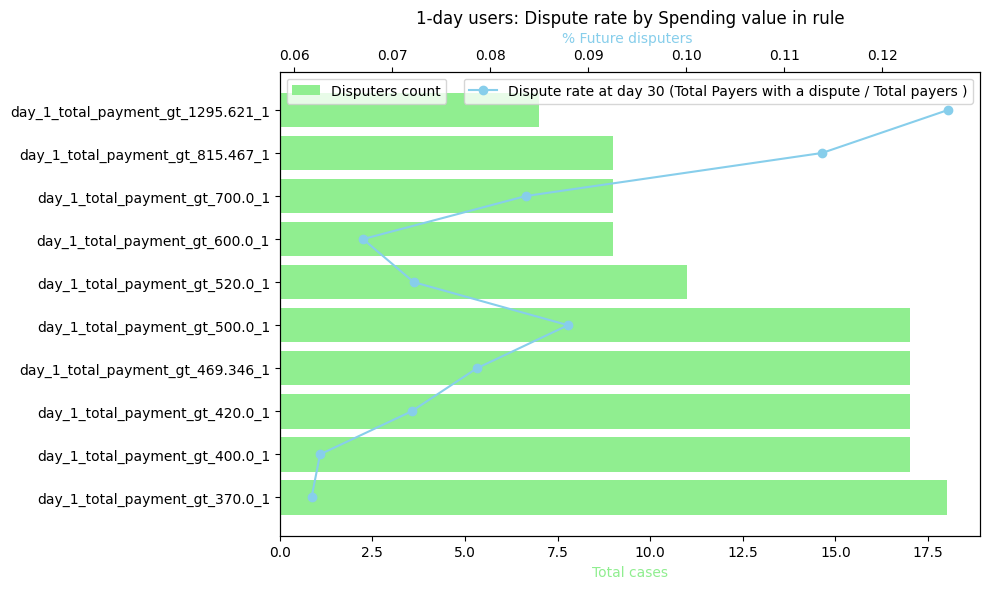

In [10]:
hola = final_df[final_df['C_1'].str.contains('day_1_total_payment')][final_df['C_1'].str.endswith('_1')].sort_values(by = 'mean', ascending = False).head(10)
hola['mean'] = hola['mean']*1.05
hola = hola.sort_values(by = 'count', ascending = True).head(10)
# Plot C_1 against mean (line) and count (bar)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mean as a line
ax1.barh(hola['C_1'], hola['sum'], color='lightgreen', label='Disputers count')

# Create a secondary y-axis for count
ax2 = ax1.twiny()

# Plot count as a bar
ax2.plot(hola['mean'], hola['C_1'], color='skyblue', marker='o', label='Dispute rate at day 30 (Total Payers with a dispute / Total payers )')

# Set labels and titles
ax2.set_xlabel(f'% Future disputers ', color='skyblue')
ax1.set_xlabel('Total cases', color='lightgreen')
ax2.set_ylabel('Quantiles (0.5%)')
ax1.set_title('1-day users: Dispute rate by Spending value in rule')

# Invert y-axis to have higher values at the top
plt.gca().invert_yaxis()

# Add legend
ax2.legend(loc='upper right')
ax1.legend(loc='upper left')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
selected_cases = final_df[final_df['sum'] >= 10]
relevants = list(set(list(selected_cases['C_1'].str.replace(r'_\d+$', '', regex=True))))
print(len(relevants))
relevants

45


['max_payment_gt_0.526',
 'bet_money_to_date_gt_152.6',
 'days_bet__[1,0,1]',
 'playing_days__[1,1,0]',
 'spent_to_date_gt_6.0',
 'minutes_to_payment_gt_19.0',
 'days_gt50_bet__[1,1,1]',
 'local_time_6_to_12_gt_0.536',
 'payments_to_date_gt_2.0',
 'bet_money_to_date_gt_31.5',
 'max_bet_gt_1.0',
 'win_spent_ratio_gt_1.586',
 'day_1_count_payment_gt_1.0',
 'payer__[1,1,0]',
 'minutes_to_pay_since_first_game_gt_13.0',
 'days_bet__[1,0,0]',
 'days_bet__[1,1,1]',
 'full_pay_[retention]',
 'local_time_before_6_gt_0.31',
 'games_to_date_gt_926.0',
 'daily_games_first_1d_gt_0.333',
 'local_time_6_to_12_gt_0.071',
 'payer__[1,0,1]',
 'max_bet_gt_0.5',
 'playing_days__[1,0,1]',
 'local_time_12_to_18_gt_0.17',
 'full_[retention]',
 'payer__[1,0,0]',
 'days_gt50_bet__[0,0,0]',
 'games_to_date_gt_254.0',
 'playing_days__[1,0,0]',
 'minutes_to_pay_since_first_game_gt_-81956.0',
 'days_gt50_bet__[1,0,0]',
 'win_spent_ratio_gt_5.34',
 'days_bet__[1,1,0]',
 'payer__[1,1,1]',
 'money_games_to_date_gt_43

### Generate n=2 combinations 

In [12]:
import itertools
combis = list(itertools.combinations(relevants, 2))

# Extract the substrings before '_gt_' pattern from each tuple
prefixes = [[item.split('_gt_')[0] for item in pair] for pair in combis]

# Find the unique prefixes
unique_prefixes = set(prefixes[0])

# Initialize a list to store the filtered data
column_combinations = []

# Iterate over the data
for pair in combis:
    prefix1, prefix2 = [item.split('_gt_')[0] for item in pair]
    # Check if the prefixes are different
    if prefix1 != prefix2 or prefix1 not in unique_prefixes:
        column_combinations.append(pair)

column_combinations


[('max_payment_gt_0.526', 'bet_money_to_date_gt_152.6'),
 ('max_payment_gt_0.526', 'days_bet__[1,0,1]'),
 ('max_payment_gt_0.526', 'playing_days__[1,1,0]'),
 ('max_payment_gt_0.526', 'spent_to_date_gt_6.0'),
 ('max_payment_gt_0.526', 'minutes_to_payment_gt_19.0'),
 ('max_payment_gt_0.526', 'days_gt50_bet__[1,1,1]'),
 ('max_payment_gt_0.526', 'local_time_6_to_12_gt_0.536'),
 ('max_payment_gt_0.526', 'payments_to_date_gt_2.0'),
 ('max_payment_gt_0.526', 'bet_money_to_date_gt_31.5'),
 ('max_payment_gt_0.526', 'max_bet_gt_1.0'),
 ('max_payment_gt_0.526', 'win_spent_ratio_gt_1.586'),
 ('max_payment_gt_0.526', 'day_1_count_payment_gt_1.0'),
 ('max_payment_gt_0.526', 'payer__[1,1,0]'),
 ('max_payment_gt_0.526', 'minutes_to_pay_since_first_game_gt_13.0'),
 ('max_payment_gt_0.526', 'days_bet__[1,0,0]'),
 ('max_payment_gt_0.526', 'days_bet__[1,1,1]'),
 ('max_payment_gt_0.526', 'full_pay_[retention]'),
 ('max_payment_gt_0.526', 'local_time_before_6_gt_0.31'),
 ('max_payment_gt_0.526', 'games_to_d

In [13]:
# Assuming df is your DataFrame
# df.columns = [col[:-5] if col.endswith('_true') else col for col in df.columns]

# Initialize an empty list to store filtered DataFrames
filtered_dfs = []

# Iterate over each combination
for combination in tqdm(column_combinations):
    # Group by the current combination of columns
    grouped = df.groupby(list(combination))['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    # print(grouped)
    # Apply the filter condition
    filtered_grouped = grouped[(grouped['sum'] >= 15)]
    # Append the filtered DataFrame to the list
    filtered_dfs.append(filtered_grouped)

# Concatenate the filtered DataFrames
result_df = pd.concat(filtered_dfs)

# Print the concatenated DataFrame
result_df


100%|██████████| 989/989 [00:05<00:00, 185.88it/s]


,max_payment_gt_0.526,bet_money_to_date_gt_152.6,sum,count,mean,"days_bet__[1,0,1]","playing_days__[1,1,0]",spent_to_date_gt_6.0,minutes_to_payment_gt_19.0,"days_gt50_bet__[1,1,1]",...,"payer__[1,1,1]",money_games_to_date_gt_431.0,spent_to_date_gt_20.0,max_games_daily_games_gt_0.72,money_games_to_date_gt_108.0,day_1_count_payment_gt_2.0,local_time_after_18_gt_0.101,minutes_to_payment_gt_3.0,"playing_days__[1,1,1]","days_gt50_bet__[1,1,0]"
1,1.0,0.0,45,12651,0.003557,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,161,24994,0.006442,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,166,31650,0.005245,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,16,2727,0.005867,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,171,28646,0.005969,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,NaN,NaN,108,11824,0.009134,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
2,NaN,NaN,142,29122,0.004876,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0
3,NaN,NaN,18,2814,0.006397,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
0,NaN,NaN,76,22274,0.003412,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [14]:

result_df.columns = [col[:-5] if col.endswith('_true') else col for col in result_df.columns]

def compact_dataframe(df):
    """
    Compact the DataFrame by keeping only two non-empty columns along with 'sum', 'count', and 'mean' columns.
    
    Parameters:
        df (DataFrame): The original DataFrame.
        
    Returns:
        DataFrame: The compacted DataFrame with two non-empty columns and 'sum', 'count', 'mean' columns.
    """
    # Initialize lists to store values for compacted DataFrame
    col1_values = []
    col2_values = []
    sum_values = []
    count_values = []
    mean_values = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Find the two non-empty columns (excluding 'sum', 'count', and 'mean')
        non_empty_columns = [col for col in row.index if col not in ['sum', 'count', 'mean'] and pd.notnull(row[col])]
        # Ensure that at least two non-empty columns are found
  
        if len(non_empty_columns) >= 2:
            # Add values to respective lists
            col1_values.append(non_empty_columns[0] + '_' + str(row[non_empty_columns[0]]))
            col2_values.append(non_empty_columns[1] + '_' + str(row[non_empty_columns[1]]))
            sum_values.append(row['sum'])
            count_values.append(row['count'])
            mean_values.append(row['mean'])
    
    # Create compacted DataFrame
    compacted_df = pd.DataFrame({'Column_1': col1_values ,
                                  'Column_2': col2_values,
                                  'sum': sum_values,
                                  'count': count_values,
                                  'mean': mean_values})
    
    return compacted_df

# Example usage:
compacted_df = compact_dataframe(result_df)
compacted_df


,Column_1,Column_2,sum,count,mean
0,max_payment_gt_0.526_1.0,bet_money_to_date_gt_152.6_0.0,45,12651,0.003557
1,max_payment_gt_0.526_1.0,bet_money_to_date_gt_152.6_1.0,161,24994,0.006442
2,max_payment_gt_0.526_1.0,"days_bet__[1,0,1]_0.0",166,31650,0.005245
3,max_payment_gt_0.526_1.0,"days_bet__[1,0,1]_1.0",16,2727,0.005867
4,max_payment_gt_0.526_1.0,"playing_days__[1,1,0]_0.0",171,28646,0.005969
...,...,...,...,...,...
2633,minutes_to_payment_gt_3.0_1.0,"playing_days__[1,1,1]_1.0",108,11824,0.009134
2634,minutes_to_payment_gt_3.0_1.0,"days_gt50_bet__[1,1,0]_0.0",142,29122,0.004876
2635,minutes_to_payment_gt_3.0_1.0,"days_gt50_bet__[1,1,0]_1.0",18,2814,0.006397
2636,"playing_days__[1,1,1]_0.0","days_gt50_bet__[1,1,0]_0.0",76,22274,0.003412


In [15]:
compacted_df.sort_values(by = 'mean', ascending = False).head(5)

,Column_1,Column_2,sum,count,mean
698,"days_gt50_bet__[1,1,1]_1.0",day_1_count_payment_gt_2.0_0.0,16,596,0.026846
685,"days_gt50_bet__[1,1,1]_1.0","payer__[1,1,1]_1.0",39,1529,0.025507
636,"days_gt50_bet__[1,1,1]_1.0",full_pay_[retention]_1,41,1769,0.023177
2543,"payer__[1,1,1]_1.0",day_1_count_payment_gt_2.0_0.0,18,813,0.022140
484,minutes_to_payment_gt_19.0_0.0,"days_gt50_bet__[1,1,1]_1.0",20,915,0.021858


In [16]:
compacted_df[compacted_df['sum'] >= 15][['Column_1', 'Column_2']]

,Column_1,Column_2
0,max_payment_gt_0.526_1.0,bet_money_to_date_gt_152.6_0.0
1,max_payment_gt_0.526_1.0,bet_money_to_date_gt_152.6_1.0
2,max_payment_gt_0.526_1.0,"days_bet__[1,0,1]_0.0"
3,max_payment_gt_0.526_1.0,"days_bet__[1,0,1]_1.0"
4,max_payment_gt_0.526_1.0,"playing_days__[1,1,0]_0.0"
...,...,...
2633,minutes_to_payment_gt_3.0_1.0,"playing_days__[1,1,1]_1.0"
2634,minutes_to_payment_gt_3.0_1.0,"days_gt50_bet__[1,1,0]_0.0"
2635,minutes_to_payment_gt_3.0_1.0,"days_gt50_bet__[1,1,0]_1.0"
2636,"playing_days__[1,1,1]_0.0","days_gt50_bet__[1,1,0]_0.0"


In [17]:
compacted_df.sort_values(by = 'mean', ascending = False).head(60)
compacted_df[compacted_df['Column_1'] != 'days_gt50_bet__[1,1,1]_1.0'].sort_values(by = 'mean', ascending = False).head(20)

# I have to add the original cases and also the triple cases 

,Column_1,Column_2,sum,count,mean
2543,"payer__[1,1,1]_1.0",day_1_count_payment_gt_2.0_0.0,18,813,0.022140
484,minutes_to_payment_gt_19.0_0.0,"days_gt50_bet__[1,1,1]_1.0",20,915,0.021858
2555,"payer__[1,1,1]_1.0","days_gt50_bet__[1,1,0]_0.0",40,1841,0.021727
2446,"days_gt50_bet__[1,0,0]_0.0","payer__[1,1,1]_1.0",42,1987,0.021137
2305,"days_gt50_bet__[0,0,0]_0.0","payer__[1,1,1]_1.0",41,2043,0.020069
2412,minutes_to_pay_since_first_game_gt_-81956.0_1.0,"payer__[1,1,1]_1.0",17,863,0.019699
413,spent_to_date_gt_6.0_1.0,"days_gt50_bet__[1,1,1]_1.0",45,2322,0.019380
10,max_payment_gt_0.526_1.0,"days_gt50_bet__[1,1,1]_1.0",45,2326,0.019347
211,"days_bet__[1,0,1]_0.0","days_gt50_bet__[1,1,1]_1.0",45,2327,0.019338
300,"playing_days__[1,1,0]_0.0","days_gt50_bet__[1,1,1]_1.0",45,2327,0.019338


In [72]:
compacted_df.sort_values(by = 'mean', ascending = False).tail(20)

,Column_1,Column_2,sum,count,mean
2017,spent_to_date_gt_20.0_0.0,games_to_date_gt_254.0_1.0,22,12795,0.001719
394,max_payment_gt_0.526_1.0,spent_to_date_gt_20.0_0.0,22,12874,0.001709
2024,spent_to_date_gt_20.0_0.0,day_1_count_payment_gt_2.0_0.0,20,11972,0.001671
1554,win_spent_ratio_gt_1.586_1.0,spent_to_date_gt_20.0_0.0,19,11687,0.001626
2014,spent_to_date_gt_20.0_0.0,"payer__[1,1,0]_0.0",18,11107,0.001621
1324,"playing_days__[1,1,0]_0.0",spent_to_date_gt_20.0_0.0,16,9986,0.001602
1481,"payer__[1,1,1]_0.0",spent_to_date_gt_20.0_0.0,18,11261,0.001598
2021,spent_to_date_gt_20.0_0.0,day_1_count_payment_gt_1.0_1.0,18,11263,0.001598
2040,spent_to_date_gt_20.0_0.0,"days_gt50_bet__[0,0,0]_1.0",16,10131,0.001579
1843,money_games_to_date_gt_108.0_1.0,spent_to_date_gt_20.0_0.0,19,12073,0.001574


### Generate n=3 combinations 

In [19]:
import itertools

column_combinations = list(itertools.combinations(cols_2, 3))
filtered_dfs = []

for combination in tqdm(column_combinations):
    # Group by the current combination of columns
    grouped = df.groupby(list(combination))['new_disputer_30d'].agg(['sum', 'count', 'mean']).reset_index()
    # print(grouped)
    # Apply the filter condition
    filtered_grouped = grouped[(grouped['sum'] >= 15) & (grouped['count'] >= 30)]
    # Append the filtered DataFrame to the list
    filtered_dfs.append(filtered_grouped)

result_df = pd.concat(filtered_dfs)
# result_df.columns = [col[:-5] if col.endswith('_true') else col for col in result_df.columns]

def compact_dataframe(df):

    col1_values = []
    col2_values = []
    col3_values = []
    sum_values = []
    count_values = []
    mean_values = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Find the two non-empty columns (excluding 'sum', 'count', and 'mean')
        non_empty_columns = [col for col in row.index if col not in ['sum', 'count', 'mean'] and pd.notnull(row[col])]
        # Ensure that at least two non-empty columns are found
  
        if len(non_empty_columns) >= 2:
            # Add values to respective lists
            col1_values.append(non_empty_columns[0] + '_' + str(row[non_empty_columns[0]]))
            col2_values.append(non_empty_columns[1] + '_' + str(row[non_empty_columns[1]]))
            col3_values.append(non_empty_columns[2] + '_' + str(row[non_empty_columns[2]]))
            sum_values.append(row['sum'])
            count_values.append(row['count'])
            mean_values.append(row['mean'])
    
    # Create compacted DataFrame
    compacted_df = pd.DataFrame({'C_1': col1_values ,
                                  'C_2': col2_values,
                                  'C_3': col3_values,
                                  'sum': sum_values,
                                  'count': count_values,
                                  'mean': mean_values})
    
    return compacted_df

compacted_df = compact_dataframe(result_df)
compacted_df


100%|██████████| 14190/14190 [01:49<00:00, 129.52it/s]


,C_1,C_2,C_3,sum,count,mean
0,spent_to_date_gt_6.0_1.0,spent_to_date_gt_20.0_1.0,max_payment_gt_0.526_1.0,184,24771,0.007428
1,spent_to_date_gt_6.0_1.0,spent_to_date_gt_20.0_1.0,payments_to_date_gt_2.0_0.0,35,6347,0.005514
2,spent_to_date_gt_6.0_1.0,spent_to_date_gt_20.0_1.0,payments_to_date_gt_2.0_1.0,149,18425,0.008087
3,spent_to_date_gt_6.0_1.0,spent_to_date_gt_20.0_1.0,minutes_to_payment_gt_3.0_1.0,181,24189,0.007483
4,spent_to_date_gt_6.0_1.0,spent_to_date_gt_20.0_1.0,minutes_to_payment_gt_19.0_0.0,61,9236,0.006605
...,...,...,...,...,...,...
47053,"days_gt50_bet__[0,0,0]_1.0","days_gt50_bet__[1,1,0]_0.0","days_gt50_bet__[1,1,1]_0.0",61,17449,0.003496
47054,"days_gt50_bet__[1,0,0]_0.0","days_gt50_bet__[1,1,0]_0.0","days_gt50_bet__[1,1,1]_0.0",61,17449,0.003496
47055,"days_gt50_bet__[1,0,0]_0.0","days_gt50_bet__[1,1,0]_0.0","days_gt50_bet__[1,1,1]_1.0",45,2327,0.019338
47056,"days_gt50_bet__[1,0,0]_0.0","days_gt50_bet__[1,1,0]_1.0","days_gt50_bet__[1,1,1]_0.0",18,2874,0.006263


In [22]:

z_score = 1.645 
compacted_df['error_margin'] = ((z_score * np.sqrt((compacted_df['mean'] * (1 - compacted_df['mean'])) / compacted_df['count'])).apply(lambda x: round(x, 3)))#*100 / compacted_df['mean']
compacted_df.sort_values(by = 'mean', ascending = False).head(20)


,C_1,C_2,C_3,sum,count,mean,error_margin
44273,day_1_count_payment_gt_2.0_0.0,"payer__[1,1,1]_1.0","days_gt50_bet__[1,1,1]_1.0",15,353,0.042493,0.018
43892,day_1_count_payment_gt_2.0_0.0,full_pay_[retention]_1,"days_gt50_bet__[1,1,1]_1.0",15,415,0.036145,0.015
44269,day_1_count_payment_gt_2.0_0.0,"payer__[1,1,1]_1.0","days_gt50_bet__[1,1,0]_0.0",16,460,0.034783,0.014
44166,day_1_count_payment_gt_2.0_0.0,"payer__[1,0,0]_0.0","days_gt50_bet__[1,1,1]_1.0",16,482,0.033195,0.013
9895,payments_to_date_gt_2.0_1.0,day_1_count_payment_gt_2.0_0.0,"days_gt50_bet__[1,1,1]_1.0",16,499,0.032064,0.013
44260,day_1_count_payment_gt_2.0_0.0,"payer__[1,1,1]_1.0","days_gt50_bet__[0,0,0]_0.0",15,479,0.031315,0.013
44264,day_1_count_payment_gt_2.0_0.0,"payer__[1,1,1]_1.0","days_gt50_bet__[1,0,0]_0.0",16,514,0.031128,0.013
35944,max_bet_gt_1.0_1.0,day_1_count_payment_gt_2.0_0.0,"days_gt50_bet__[1,1,1]_1.0",16,521,0.030710,0.012
41303,local_time_after_18_gt_0.101_1.0,day_1_count_payment_gt_2.0_0.0,"days_gt50_bet__[1,1,1]_1.0",15,491,0.030550,0.013
44200,day_1_count_payment_gt_2.0_0.0,"payer__[1,0,1]_0.0","days_gt50_bet__[1,1,1]_1.0",16,528,0.030303,0.012


In [ ]:
# Now concatenate all cases


In [ ]:
df['full_[retention]']      = df['retention_sequence'].apply(lambda x: x[-2])
df['full_pay_[retention]']  = df['daily_payment_history_binary'].apply(lambda x: x[-2])

## dirty code

In [217]:
import pandas as pd

def compact_dataframe(df):
    
    compacted_data = []
    
    for index, row in df.iterrows():
        non_empty_columns = row.dropna().index.tolist()
        compacted_data.append(non_empty_columns)
    
    compacted_df = pd.DataFrame(compacted_data, columns=['column1', 'column2'])
    
    return compacted_df

# Example usage:
compacted_df = compact_dataframe(result_df)


ValueError: 2 columns passed, passed data had 5 columns

In [216]:
result_df.sort_values(by = 'mean', ascending = False).head(10)

,spent_to_date_q1_surpassed,max_daily_spent_q1_surpassed,sum,count,mean,max_payment_q1_surpassed,payments_to_date_q1_surpassed,minutes_to_payment_q1_surpassed,minutes_to_pay_since_first_game_q1_surpassed,games_to_date_q1_surpassed,...,local_time_6_to_12_q6_surpassed,local_time_6_to_12_q7_surpassed,local_time_12_to_18_q2_surpassed,local_time_12_to_18_q3_surpassed,local_time_12_to_18_q4_surpassed,local_time_12_to_18_q5_surpassed,local_time_after_18_q1_surpassed,local_time_after_18_q2_surpassed,local_time_after_18_q3_surpassed,local_time_after_18_q4_surpassed
2,NaN,NaN,13,303,0.042904,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,14,363,0.038567,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,12,317,0.037855,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,12,335,0.035821,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,15,420,0.035714,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,14,429,0.032634,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,19,591,0.032149,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,18,589,0.030560,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,17,557,0.030521,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,NaN,NaN,13,436,0.029817,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Now you can do your own model: 

import pandas as pd
import itertools

# Step 1: Generate splits of the continuous variables

# Quantiles
quantiles_df = df.quantile([0.2, 0.4, 0.6, 0.8])


# Round values
round_df = df.round()

# Outliers (Handle outliers as per your criteria)

# Step 2: Remove cases with a dispute rate lower than the mean or with observations lower than 10

# Calculate dispute rate
df['dispute_rate'] = df['disputes'] / df['observations']

# Remove cases with less than 10 observations or dispute rates lower than the mean dispute rate
df_filtered = df[(df['observations'] >= 10) & (df['dispute_rate'] >= df['dispute_rate'].mean())]

# Step 3: Perform binary combination of the remaining variables

# Concatenate the remaining variables
concatenated_df = pd.concat([df_filtered['var1'], df_filtered['var2'], df_filtered['var3']], axis=1)

# Generate all combinations of 'two-cols' group and 'one group'
combinations = list(itertools.combinations(concatenated_df.columns, 2))

# Step 4: Get the dispute frequencies and concatenate and decide the rules

# Calculate dispute frequencies
dispute_frequencies = df_filtered.groupby(['var1', 'var2', 'var3'])['disputes'].sum()

# Concatenate and analyze to decide rules
# You can analyze dispute_frequencies DataFrame to decide rules based on your requirements



In [76]:
high_level_dt.tail(10)

,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Condition 6,Condition 7,Disputer rate,Payers,Disputers
28,User,3.0,spent_to_date ≤ 174.5,spent_to_date > 9.995,max_games_daily_games ≤ 0.481,local_time_before_6 > 0.185,local_time_6_to_12 > 0.381,None,None,0.0,321.0,0.0
29,User,3.0,spent_to_date ≤ 174.5,spent_to_date > 9.995,max_games_daily_games > 0.481,money_games_to_date ≤ 52.5,minutes_to_pay_since_first_game ≤ 11.5,local_time_before_6 > 0.485,None,0.0,436.0,0.0
30,User,3.0,spent_to_date ≤ 174.5,spent_to_date > 9.995,max_games_daily_games > 0.481,money_games_to_date ≤ 52.5,minutes_to_pay_since_first_game > 11.5,local_time_before_6 > 0.002,local_time_before_6 ≤ 0.799,0.0,338.0,0.0
31,User,3.0,spent_to_date ≤ 174.5,spent_to_date ≤ 9.995,"playing_days__[1,0,0] > 0.5",minutes_to_pay_since_first_game ≤ 11.5,None,None,None,0.0,5832.0,0.0
32,User,3.0,spent_to_date ≤ 174.5,spent_to_date > 9.995,max_games_daily_games > 0.481,money_games_to_date > 52.5,payments_to_date ≤ 4.5,local_time_after_18 > 0.528,None,0.0,1330.0,0.0
33,User,3.0,spent_to_date ≤ 174.5,spent_to_date > 9.995,max_games_daily_games > 0.481,money_games_to_date > 52.5,payments_to_date > 4.5,money_games_to_date > 2544.0,None,0.0,511.0,0.0
34,User,3.0,spent_to_date ≤ 174.5,spent_to_date ≤ 9.995,"playing_days__[1,0,0] ≤ 0.5",local_time_6_to_12 ≤ 0.816,max_games_daily_games > 0.522,minutes_to_payment > 5.5,minutes_to_pay_since_first_game > 2909.0,0.0,453.0,0.0
35,User,3.0,spent_to_date > 174.5,spent_to_date ≤ 452.995,games_to_date ≤ 2885.5,max_payment ≤ 0.314,local_time_after_18 ≤ 0.158,None,None,0.0,233.0,0.0
36,User,3.0,spent_to_date ≤ 174.5,spent_to_date ≤ 9.995,"playing_days__[1,0,0] ≤ 0.5",local_time_6_to_12 ≤ 0.816,max_games_daily_games > 0.522,minutes_to_payment ≤ 5.5,"payer__[1,0,1] > 0.5",0.0,894.0,0.0
37,User,3.0,spent_to_date ≤ 174.5,spent_to_date ≤ 9.995,"playing_days__[1,0,0] ≤ 0.5",local_time_6_to_12 ≤ 0.816,max_games_daily_games ≤ 0.522,None,None,0.0,797.0,0.0


In [89]:
high_level_dt[high_level_dt['Matuirity'] <= 7].head(5)
high_level_dt[high_level_dt['Matuirity'] >= 7].head(5)

,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Disputer rate,Payers,Disputers
0,maturity_day < 14 & payments > 1,9.0,spending_quantile > 39.0,bet_money_quantile > 341.55,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,games_played_quantile > 1980.5,0.066667,210.0,14.0
1,maturity_day < 14 & payments > 1,8.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,None,0.056940,281.0,16.0
2,maturity_day < 14 & payments > 1,11.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,None,0.043860,342.0,15.0
3,maturity_day < 14 & payments > 1,10.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,None,0.041534,313.0,13.0
4,maturity_day < 14 & payments > 1,12.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile ≤ 25.0,bet_money_quantile ≤ 341.55,None,0.040000,100.0,4.0


In [90]:
# VERIFY IN TRAINNING DATA

print(df[(df['segments'] == 'maturity_day < 14 & payments > 1')].fillna(0)[(df['matuirity_day'] == 1) & (df['spent_last_14d'] > 247.485) & (df['win_amount_to_date'] > 8415.855)].shape[0])
print(df[(df['segments'] == 'maturity_day < 14 & payments > 1')].fillna(0)[(df['matuirity_day'] == 1) & (df['spent_last_14d'] > 247.485) & (df['win_amount_to_date'] > 8415.855)]['new_disputer_30d'].mean())
print(df[(df['segments'] == 'maturity_day < 14 & payments > 1')].fillna(0)[(df['matuirity_day'] == 1) & (df['spent_last_14d'] > 247.485) & (df['win_amount_to_date'] > 8415.855)]['new_disputer_30d'].sum())
print((df[(df['segments'] == 'maturity_day < 14 & payments > 1')].fillna(0)[(df['matuirity_day'] == 1) & (df['spent_last_14d'] > 247.485) & (df['win_amount_to_date'] > 8415.855)]['new_disputer_30d'] - 1).sum())
print(df[(df['segments'] == 'maturity_day < 14 & payments > 1')][(df['matuirity_day'] == 1) & (df['spent_last_14d'] > 247.485) & (df['win_amount_to_date'] > 8415.855)]['new_disputer_30d'].sum())
print((df[(df['segments'] == 'maturity_day < 14 & payments > 1')][(df['matuirity_day'] == 1) & (df['spent_last_14d'] > 247.485) & (df['win_amount_to_date'] > 8415.855)]['new_disputer_30d'] - 1).sum())


0
nan
0
0
0
0


In [91]:
# VERIFY IN TRAINNING DATA II

# Calculate the sum of True_Cases in the dataset
total_true_cases = high_level_dt['Disputers'].sum()
total_cases = high_level_dt['Payers'].fillna(0).sum()
print(total_cases)

# Calculate the percentage of True cases out of the total dataset sum for each row
high_level_dt['Payers_covered'] = (high_level_dt['Payers'].fillna(0) / total_cases)
high_level_dt['Payers_covered_to_point'] = high_level_dt['Payers_covered'].cumsum().apply(lambda x: round(x, 4))
high_level_dt['Disputes_covered'] = (high_level_dt['Disputers'] / total_true_cases).apply(lambda x: round(x, 5))
high_level_dt['Disputes_covered_to_point'] = high_level_dt['Disputes_covered'].cumsum().apply(lambda x: round(x, 3))

high_level_dt.head(700)

216755.0


,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Disputer rate,Payers,Disputers,Payers_covered,Payers_covered_to_point,Disputes_covered,Disputes_covered_to_point
0,maturity_day < 14 & payments > 1,9.0,spending_quantile > 39.0,bet_money_quantile > 341.55,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,games_played_quantile > 1980.5,0.066667,210.0,14.0,0.000969,0.0010,0.00787,0.008
1,maturity_day < 14 & payments > 1,8.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,None,0.056940,281.0,16.0,0.001296,0.0023,0.00899,0.017
2,maturity_day < 14 & payments > 1,11.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,None,0.043860,342.0,15.0,0.001578,0.0038,0.00843,0.025
3,maturity_day < 14 & payments > 1,10.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile > 25.0,win_spent_ratio_quantile ≤ 1.61,None,0.041534,313.0,13.0,0.001444,0.0053,0.00731,0.033
4,maturity_day < 14 & payments > 1,12.0,spending_quantile > 39.0,games_played_quantile > 1980.5,max_daily_spent_quantile ≤ 25.0,bet_money_quantile ≤ 341.55,None,0.040000,100.0,4.0,0.000461,0.0057,0.00225,0.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,maturity_day < 14 & payments > 1,14.0,spending_quantile ≤ 39.0,games_played_quantile ≤ 299.5,win_spent_ratio_quantile ≤ 1.61,bet_money_quantile > 7.3,max_daily_spent_quantile > 25.0,0.000000,106.0,0.0,0.000489,0.9927,0.00000,1.000
316,maturity_day > 14 & paying_matuirity > 14 & pa...,15.0,bet_money_quantile ≤ 341.55,games_played_quantile ≤ 761.0,max_daily_spent_quantile > 11.5,bet_money_quantile > 95.45,None,0.000000,188.0,0.0,0.000867,0.9935,0.00000,1.000
317,maturity_day < 14 & payments > 1,14.0,spending_quantile ≤ 39.0,games_played_quantile ≤ 299.5,win_spent_ratio_quantile ≤ 1.61,bet_money_quantile ≤ 7.3,max_daily_spent_quantile ≤ 11.5,0.000000,538.0,0.0,0.002482,0.9960,0.00000,1.000
318,maturity_day > 14 & paying_matuirity > 14 & pa...,15.0,bet_money_quantile ≤ 341.55,games_played_quantile > 761.0,None,None,None,0.000000,761.0,0.0,0.003511,0.9995,0.00000,1.000


In [39]:
# EXPORT TRAINNING ONLY
high_level_dt.to_csv('output.csv', index=False)

# Check new data

### Confirm rules are extrapolable on testing set 

In [43]:
high_level_dt.columns

Index(['Segment', 'Matuirity', 'Condition 1', 'Condition 2', 'Condition 3',
       'Condition 4', 'Condition 5', 'Disputer rate', 'Payers', 'Disputers',
       'Payers_covered', 'Payers_covered_to_point', 'Disputes_covered',
       'Disputes_covered_to_point'],
      dtype='object')

In [92]:
# Initialize an empty list to store individual conditions
individual_conditions = []

conditions_df = high_level_dt[high_level_dt['Segment'] == 'maturity_day < 14 & payments > 1'][high_level_dt.columns[1:7]].head(20)

# Iterate through each row of the dataframe
for index, row in conditions_df.iterrows():
    # Initialize an empty list to store conditions for the current row
    row_conditions = []
    # Add the Maturity condition for the current row
    row_conditions.append(f"(df['matuirity_day == {row['Matuirity'] - 1})")
    # Iterate through each column (excluding the 'Matuirity' column)
    for column in conditions_df.columns[1:]:
        # Check if the condition is not None
        if row[column] is not None:
            # Append the condition to the list, formatting it accordingly
            row_conditions.append(f"(df['{row[column]})")
    # Combine conditions for the current row with logical AND and append to the list of individual conditions
    individual_conditions.append(" & ".join(row_conditions))

# Combine individual conditions with logical OR
combined_condition = " | ".join(individual_conditions)

# Adjust
combined_condition = combined_condition.replace(" >", "'] >")
combined_condition = combined_condition.replace(" <", "'] <")
combined_condition = combined_condition.replace(" ≤", "'] <=")
combined_condition = combined_condition.replace(" ==", "'] ==")
print(combined_condition)

# Adjust for testing set, test_df
combined_condition_test = combined_condition.replace("df", "test_df")

(df['matuirity_day'] == 8.0) & (df['spending_quantile'] > 39.0) & (df['bet_money_quantile'] > 341.55) & (df['max_daily_spent_quantile'] > 25.0) & (df['win_spent_ratio_quantile'] <= 1.61) & (df['games_played_quantile'] > 1980.5) | (df['matuirity_day'] == 7.0) & (df['spending_quantile'] > 39.0) & (df['games_played_quantile'] > 1980.5) & (df['max_daily_spent_quantile'] > 25.0) & (df['win_spent_ratio_quantile'] <= 1.61) | (df['matuirity_day'] == 10.0) & (df['spending_quantile'] > 39.0) & (df['games_played_quantile'] > 1980.5) & (df['max_daily_spent_quantile'] > 25.0) & (df['win_spent_ratio_quantile'] <= 1.61) | (df['matuirity_day'] == 9.0) & (df['spending_quantile'] > 39.0) & (df['games_played_quantile'] > 1980.5) & (df['max_daily_spent_quantile'] > 25.0) & (df['win_spent_ratio_quantile'] <= 1.61) | (df['matuirity_day'] == 11.0) & (df['spending_quantile'] > 39.0) & (df['games_played_quantile'] > 1980.5) & (df['max_daily_spent_quantile'] <= 25.0) & (df['bet_money_quantile'] <= 341.55) | (df

In [93]:
filtered_df = df[eval(combined_condition)]#[df['payments_to_date'] > 1]
filtered_test_df = test_df[eval(combined_condition_test)]#[test_df['payments_to_date'] > 1] 

print(df['new_disputer_30d'].shape)
print(df['new_disputer_30d'].mean())
print(filtered_df['new_disputer_30d'].shape)
print(filtered_df['new_disputer_30d'].mean())

print(test_df['new_disputer_30d'].shape)
print(test_df['new_disputer_30d'].mean())
print(filtered_test_df['new_disputer_30d'].shape)
print(filtered_test_df['new_disputer_30d'].mean())


(216755,)
0.008207423127494175
(12281,)
0.033466330103411775
(156345,)
0.004809875595637852
(8956,)
0.02009825815096025


### Verification on new pulled data

In [55]:
df_new = pd.read_csv('C:/Users/Win11/Downloads/20240429_054835_83865_zd7t9.csv')
df_new

,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,win_amount_to_date,win_amount_last_14d,win_amount_last_7d,max_bet,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18
0,10540756,2024-03-11 06:02:19.000,6,0,0.0,9381,9381.0,0,1,1,...,116.22,116.22,116.22,0.7,0,0,406.0,11.0,0.0,507.0
1,10541592,2024-03-11 20:01:27.000,0,0,0.0,1,1.0,0,1,1,...,1.97,1.97,1.97,0.1,0,0,144.0,0.0,0.0,0.0
2,10541592,2024-03-11 20:01:27.000,1,1,0.0,1,1.0,1,1,1,...,1.97,1.97,1.97,0.1,0,0,144.0,0.0,0.0,0.0
3,10541592,2024-03-11 20:01:27.000,2,2,0.0,1,1.0,2,1,1,...,3.70,3.70,3.70,0.1,0,0,176.0,0.0,0.0,0.0
4,10541592,2024-03-11 20:01:27.000,3,3,0.0,1,1.0,3,1,1,...,3.70,3.70,3.70,0.1,0,0,176.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30696,10553494,2024-03-15 03:57:06.000,5,5,1.0,63,62.0,5,1,1,...,155.92,155.92,155.92,2.0,0,0,139.0,785.0,0.0,0.0
30697,10553494,2024-03-15 03:57:06.000,6,6,1.0,63,62.0,6,1,1,...,155.92,155.92,155.92,2.0,0,0,139.0,785.0,0.0,0.0
30698,10553843,2024-03-15 05:42:49.000,0,0,0.0,1,1.0,0,1,1,...,10.41,10.41,10.41,1.0,0,0,76.0,65.0,0.0,0.0
30699,10553843,2024-03-15 05:42:49.000,1,1,0.0,1,1.0,1,1,1,...,10.41,10.41,10.41,1.0,0,0,76.0,65.0,0.0,0.0


In [56]:
# REMOVE FEATURES AND DUMMIFY SEQUENCES 

# Base Cols
cols = ['paying_matuirity', 'spent_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent'
        , 'max_payment', 'payments_last_14d', 'payments_last_7d',  'payments_to_date',  'minutes_to_payment', 'minutes_to_pay_since_first_game'
        , 'games_last_14d', 'games_last_7d', 'games_to_date', 'max_games_daily_games', 'daily_games_first_14d', 'daily_games_first_7d', 'daily_games_first_1d', 'minutes_to_play'
        , 'money_games_to_date', 'bet_money_to_date', 'max_bet',  'money_games_last_14d', 'money_games_last_7d'
        , 'win_amount_to_date',  'win_amount_last_14d', 'win_amount_last_7d'
        , 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date'
        , 'local_time_before_6', 'local_time_6_to_12', 'local_time_12_to_18', 'local_time_after_18']

# I. Truncate sequences to the last 14 days
columns_of_interest = ['retention_sequence', 'days_betting_money_sequence', 'days_50_usd_bet_money_sequence', 'daily_payment_history_binary']  # Add additional columns here if needed
def truncate_list(lst):
    return lst[-14:]
for column in columns_of_interest:
    df_new[column] = df_new[column].apply(truncate_list)

# II. Execute the dummification
columns_info = {'retention_sequence': 'playing_days_'
                # , 'money_bet_sequence': 'money_bet_'
                , 'daily_payment_history_binary': 'payer_'
                # , 'daily_payment_history_count': 'pay_'
                , 'days_betting_money_sequence': 'days_bet_'
                , 'days_50_usd_bet_money_sequence': 'days_gt50_bet_'
                # , 'province': 'province_'
                }  # Add additional columns and identifiers here if needed

dummy_variable_list = []  # List to store dummy variables generated for each column

for column, identifier in columns_info.items():
    # Calculate sum of 'new_disputer_30d' for each unique value in the column
    sum_disputer = df_new.groupby(column)['new_disputer_30d'].sum()
    # Filter unique values where sum is >= 12
    valid_values = sum_disputer[sum_disputer >= 3].index.tolist()
    # Generate dummy variables for valid values
    dummy_variables = pd.get_dummies(df[column].loc[df[column].isin(valid_values)], prefix=identifier).astype(int)
    dummy_variable_list.append(dummy_variables)
    df_new = pd.concat([df_new, dummy_variables], axis=1)

# Concatenate all dummy variables into a single DataFrame
final_dummy_variables = pd.concat(dummy_variable_list, axis=1)
cols = cols + list(final_dummy_variables.columns)

# III. Can remove extra items
items_to_remove = ['working_hours_bets_to_date', 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date', 'province']
cols = [item for item in cols if item not in items_to_remove]
final_dummy_variables.columns


Index(['playing_days__[1,1,1]', 'playing_days__[1,1]', 'playing_days__[1]',
       'payer__[1,1]', 'payer__[1]', 'days_bet__[1,1]', 'days_bet__[1]',
       'days_gt50_bet__[1,1]', 'days_gt50_bet__[1]'],
      dtype='object')

In [58]:
high_level_dt[high_level_dt['Segment'] == 'maturity_day < 14 & payments > 1'][high_level_dt.columns[1:7]].head(25)

max_daily_spent > 1049.985	local_time_12_to_18 > 4424.5

,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5
0,10.0,spent_to_date > 448.995,spent_last_7d > 1777.49,max_daily_spent > 1672.5,None,None
1,13.0,max_daily_spent > 288.995,spent_last_7d > 1289.495,max_daily_spent > 1049.985,local_time_12_to_18 > 4424.5,None
2,11.0,payments_last_7d > 9.5,spent_last_7d > 1025.985,max_daily_spent ≤ 1662.5,max_bet ≤ 19.0,games_last_7d ≤ 14459.0
3,14.0,payments_last_7d > 5.5,spent_last_7d > 1159.99,max_daily_spent > 1049.985,max_daily_spent ≤ 2000.5,None
4,9.0,max_daily_spent > 210.5,max_daily_spent > 1599.985,None,None,None
5,6.0,spent_to_date > 225.995,spent_last_14d > 3308.5,None,None,None
6,11.0,payments_last_7d > 9.5,spent_last_7d > 1025.985,max_daily_spent > 1662.5,None,None
7,1.0,daily_games_first_14d > 581.94,bet_money_to_date > 6199.35,None,None,None
8,7.0,spent_to_date > 267.995,max_daily_spent > 1386.99,None,None,None
9,5.0,spent_last_14d > 217.995,spent_to_date > 2578.46,None,None,None


In [59]:


# Adjust for testing set, test_df
combined_condition_df_new = combined_condition.replace("df", "df_new")
combined_condition_df_new

"(df_new['matuirity_day'] == 10.0) & (df_new['spent_to_date'] > 448.995) & (df_new['spent_last_7d'] > 1777.49) & (df_new['max_daily_spent'] > 1672.5) | (df_new['matuirity_day'] == 13.0) & (df_new['max_daily_spent'] > 288.995) & (df_new['spent_last_7d'] > 1289.495) & (df_new['max_daily_spent'] > 1049.985) & (df_new['local_time_12_to_18'] > 4424.5) | (df_new['matuirity_day'] == 11.0) & (df_new['payments_last_7d'] > 9.5) & (df_new['spent_last_7d'] > 1025.985) & (df_new['max_daily_spent'] <= 1662.5) & (df_new['max_bet'] <= 19.0) & (df_new['games_last_7d'] <= 14459.0) | (df_new['matuirity_day'] == 14.0) & (df_new['payments_last_7d'] > 5.5) & (df_new['spent_last_7d'] > 1159.99) & (df_new['max_daily_spent'] > 1049.985) & (df_new['max_daily_spent'] <= 2000.5) | (df_new['matuirity_day'] == 9.0) & (df_new['max_daily_spent'] > 210.5) & (df_new['max_daily_spent'] > 1599.985) | (df_new['matuirity_day'] == 6.0) & (df_new['spent_to_date'] > 225.995) & (df_new['spent_last_14d'] > 3308.5) | (df_new['ma

In [60]:
filtered_df = df[eval(combined_condition)][df['payments_to_date'] > 1]
filtered_df_new = df_new[eval(combined_condition_df_new)][df_new['payments_to_date'] > 1] 

print(df['new_disputer_30d'].shape)
print(df['new_disputer_30d'].mean())
print(filtered_df['new_disputer_30d'].shape)
print(filtered_df['new_disputer_30d'].mean())

print(df_new['new_disputer_30d'].shape)
print(df_new['new_disputer_30d'].mean())
print(filtered_df_new['new_disputer_30d'].shape)
print(filtered_df_new['new_disputer_30d'].mean())


(3185077,)
0.0038762014230739163
(3044,)
0.11300919842312747
(92005,)
0.0014331780723754925
(193,)
0.0


In [57]:
del df

midterm_1p    = pd.read_csv('C:/Users/Win11/Downloads/20240417_123012_75122_gs2bg.csv')
midterm_mult  = pd.read_csv('C:/Users/Win11/Downloads/20240418_005856_07589_gs2bg.csv')
longterm_mult = pd.read_csv('C:/Users/Win11/Downloads/20240418_020806_42680_gs2bg.csv')
longterm_1p   = pd.read_csv('C:/Users/Win11/Downloads/20240418_065604_04247_gs2bg.csv')
shortterm_all = pd.read_csv('C:/Users/Win11/Downloads/20240418_070628_04903_gs2bg.csv')

df_old_version_2 = pd.concat([midterm_1p, midterm_mult, longterm_1p, longterm_mult, shortterm_all], ignore_index=True)

del midterm_1p    
del midterm_mult  
del longterm_mult 
del longterm_1p   
del shortterm_all 

# Define a function to assign segments based on the given factors
def assign_segment(row):
    if row['matuirity_day'] < 14:
        if row['payments_to_date'] > 1:
            return 'maturity_day < 14 & payments > 1'
        else:
            return 'maturity_day < 14 & payments = 1'
    elif row['matuirity_day'] >= 14 and row['paying_matuirity'] < 14:
        if row['payments_to_date'] > 1:
            return 'maturity_day > 14 & paying_matuirity < 14 & payments > 1'
        else:
            return 'maturity_day > 14 & paying_matuirity < 14 & payments = 1'
    elif row['matuirity_day'] >= 14 and row['paying_matuirity'] >= 14:
        if row['payments_to_date'] > 1:
            return 'maturity_day > 14 & paying_matuirity > 14 & payments > 1'
        else:
            return 'maturity_day > 14 & paying_matuirity > 14 & payments = 1'

# Apply the function to create the 'Segments' column
df_old_version_2['segments'] = df_old_version_2.apply(assign_segment, axis=1)


In [150]:

df = pd.read_csv('C:/Users/Win11/Downloads/20240426_082428_37756_k4fpn.csv')
old_df = pd.read_csv('C:/Users/Win11/Downloads/20240418_070628_04903_gs2bg.csv')
old_df['matuirity_day'] = old_df['matuirity_day'].astype(float)
old_df['payments_to_date'] = old_df['payments_to_date'].astype(float)
old_df['paying_matuirity'] = old_df['paying_matuirity'].astype(float)

def assign_segment(row):
    if row['matuirity_day'] < 14:
        if row['payments_to_date'] > 1:
            return 'maturity_day < 14 & payments > 1'
        else:
            return 'maturity_day < 14 & payments = 1'
    elif row['matuirity_day'] >= 14 and row['paying_matuirity'] < 14:
        if row['payments_to_date'] > 1:
            return 'maturity_day > 14 & paying_matuirity < 14 & payments > 1'
        else:
            return 'maturity_day > 14 & paying_matuirity < 14 & payments = 1'
    elif row['matuirity_day'] >= 14 and row['paying_matuirity'] >= 14:
        if row['payments_to_date'] > 1:
            return 'maturity_day > 14 & paying_matuirity > 14 & payments > 1'
        else:
            return 'maturity_day > 14 & paying_matuirity > 14 & payments = 1'

# Apply the function to create the 'Segments' column
# df_old_version_2['segments'] = df_old_version_2.apply(assign_segment, axis=1)

# Apply the function to create the 'Segments' column
# df['segments'] = df.apply(assign_segment, axis=1)
old_df['segments'] = old_df.apply(assign_segment, axis=1)


In [88]:
# Print out rows with empty values in the 'segments' column
empty_segments = old_df[old_df['segments'].isnull()]
print(empty_segments)


Empty DataFrame
Columns: [#account_id, register_time, matuirity_day, paying_matuirity, minutes_to_play, minutes_to_payment, minutes_to_pay_since_first_game, pay_matuirity, payments_to_date, payments_last_14d, payments_last_7d, payments_last_3d, spent_to_date, spent_last_14d, spent_last_7d, spent_last_3d, daily_spent_to_date, daily_spent_last_7_d, daily_spent_first_14d, daily_spent_first_7d, daily_spent_first_1d, max_daily_spent, max_payment, daily_payment_history_binary, daily_payment_history_count, games_to_date, games_last_14d, games_last_7d, max_games_daily_games, daily_games_first_14d, daily_games_first_7d, daily_games_first_1d, retention_sequence, games_sequence, days_betting_money_sequence, days_50_usd_bet_money_sequence, money_games_to_date, money_games_last_14d, money_games_last_7d, bet_money_to_date, bet_money_last_14d, bet_money_last_7d, win_amount_to_date, win_amount_last_14d, win_amount_last_7d, max_bet, past_disputer, new_disputer_30d, local_time_before_6, local_time_6_to_

In [89]:
old_df[['segments'] + list(old_df.columns)].tail(5000)
# df[['segments'] + list(old_df.columns)].tail(60)

,segments,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,...,win_amount_last_14d,win_amount_last_7d,max_bet,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18,segments
308920,maturity_day < 14 & payments > 1,10478540,2024-02-14 20:07:38.000,1.0,1.0,0.0,288,288.0,1,2.0,...,1.80,1.80,0.1,0,0,33.0,0.0,0.0,0.0,maturity_day < 14 & payments > 1
308921,maturity_day < 14 & payments > 1,10478540,2024-02-14 20:07:38.000,2.0,2.0,0.0,288,288.0,2,3.0,...,1.80,1.80,0.1,0,0,33.0,5.0,5.0,0.0,maturity_day < 14 & payments > 1
308922,maturity_day < 14 & payments > 1,10478540,2024-02-14 20:07:38.000,3.0,3.0,0.0,288,288.0,3,3.0,...,1.80,1.80,0.1,0,0,33.0,5.0,5.0,0.0,maturity_day < 14 & payments > 1
308923,maturity_day < 14 & payments > 1,10478540,2024-02-14 20:07:38.000,4.0,4.0,0.0,288,288.0,4,3.0,...,1.80,1.80,0.1,0,0,33.0,5.0,5.0,0.0,maturity_day < 14 & payments > 1
308924,maturity_day < 14 & payments > 1,10478540,2024-02-14 20:07:38.000,5.0,5.0,0.0,288,288.0,5,3.0,...,1.80,1.80,0.1,0,0,33.0,5.0,5.0,0.0,maturity_day < 14 & payments > 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313915,maturity_day < 14 & payments > 1,10511595,2024-02-20 09:11:14.000,2.0,1.0,1.0,1995,1994.0,1,4.0,...,37.22,37.22,0.5,0,0,470.0,46.0,15.0,4.0,maturity_day < 14 & payments > 1
313916,maturity_day < 14 & payments > 1,10511595,2024-02-20 09:11:14.000,3.0,2.0,1.0,1995,1994.0,2,4.0,...,37.22,37.22,0.5,0,0,470.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1
313917,maturity_day < 14 & payments > 1,10511595,2024-02-20 09:11:14.000,4.0,3.0,1.0,1995,1994.0,3,5.0,...,43.62,43.62,0.5,0,0,598.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1
313918,maturity_day < 14 & payments > 1,10511595,2024-02-20 09:11:14.000,5.0,4.0,1.0,1995,1994.0,4,5.0,...,43.62,43.62,0.5,0,0,598.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1


In [92]:

print(df_old_version_2[(df_old_version_2['segments'] == 'maturity_day < 14 & payments > 1')].fillna(0)[(df_old_version_2['matuirity_day'] == 1) & (df_old_version_2['spent_last_14d'] > 247.485) & (df_old_version_2['win_amount_last_14d'] > 8415.855)].shape[0])
print(df_old_version_2[(df_old_version_2['segments'] == 'maturity_day < 14 & payments > 1')].fillna(0)[(df_old_version_2['matuirity_day'] == 1) & (df_old_version_2['spent_last_14d'] > 247.485) & (df_old_version_2['win_amount_last_14d'] > 8415.855)]['new_disputer_30d'].mean())

print(old_df[(old_df['segments'] == 'maturity_day < 14 & payments > 1') & (old_df['matuirity_day'] == 1) & (old_df['spent_last_14d'] > 247.485) & (old_df['win_amount_last_14d'] > 8415.855)].shape[0])
print(old_df[(old_df['segments'] == 'maturity_day < 14 & payments > 1') & (old_df['matuirity_day'] == 1) & (old_df['spent_last_14d'] > 247.485) & (old_df['win_amount_last_14d'] > 8415.855)]['new_disputer_30d'].mean())

print(df[(df['matuirity_day'] == 1) & (df['spent_last_14d'] > 247.485) & (df['win_amount_last_14d'] > 8415.855)]['new_disputer_30d'].shape[0])
print(df[(df['matuirity_day'] == 1) & (df['spent_last_14d'] > 247.485) & (df['win_amount_last_14d'] > 8415.855)]['new_disputer_30d'].mean())


90
0.18888888888888888
90
0.18888888888888888
6
0.0


### Validation new data

### Code for alternative checks

Convert the rules report into a rule

In [20]:
# df['new_disputer_30d'].mean()
high_level_dt[high_level_dt['Segment'] == 'maturity_day < 14 & payments > 1'][high_level_dt.columns[0:7]].head(15)
# high_level_dt
# high_level_dt

,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5
0,maturity_day < 14 & payments > 1,10.0,spent_to_date > 239.995,spent_last_7d > 1777.49,max_daily_spent > 1672.5,None,None
1,maturity_day < 14 & payments > 1,6.0,spent_to_date > 225.995,spent_last_14d > 3308.5,None,None,None
2,maturity_day < 14 & payments > 1,14.0,payments_last_7d > 5.5,spent_last_7d > 1159.99,max_daily_spent > 1049.985,max_daily_spent ≤ 2000.5,None
3,maturity_day < 14 & payments > 1,2.0,spent_last_14d > 247.995,max_payment > 105.5,max_daily_spent > 666.5,None,None
4,maturity_day < 14 & payments > 1,11.0,payments_last_7d > 9.5,spent_last_7d > 1025.985,max_daily_spent > 1662.5,None,None
5,maturity_day < 14 & payments > 1,1.0,daily_games_first_14d > 581.94,daily_games_first_14d > 2324.75,max_payment > 19.995,local_time_6_to_12 ≤ 568.0,None
6,maturity_day < 14 & payments > 1,7.0,spent_to_date > 267.995,max_daily_spent > 1386.99,None,None,None
7,maturity_day < 14 & payments > 1,5.0,spent_last_14d > 217.995,spent_to_date > 2578.46,None,None,None
8,maturity_day < 14 & payments > 1,13.0,payments_last_7d > 5.5,spent_last_7d ≤ 1289.495,max_bet > 10.9,payments_last_7d > 17.5,daily_games_first_1d > 1129.04
9,maturity_day < 14 & payments > 1,2.0,spent_last_14d ≤ 247.995,daily_games_first_14d > 631.48,daily_games_first_1d ≤ 1185.75,daily_games_first_14d > 1182.95,max_daily_spent > 49.48


(df['matuirity_day'] == 10.0) & (df['spent_to_date'] > 239.995) & (df['spent_last_7d'] > 1777.49) & (df['max_daily_spent'] > 1672.5) | (df['matuirity_day'] == 6.0) & (df['spent_to_date'] > 225.995) & (df['spent_last_14d'] > 3308.5) | (df['matuirity_day'] == 14.0) & (df['payments_last_7d'] > 5.5) & (df['spent_last_7d'] > 1159.99) & (df['max_daily_spent'] > 1049.985) & (df['max_daily_spent'] <= 2000.5) | (df['matuirity_day'] == 2.0) & (df['spent_last_14d'] > 247.995) & (df['max_payment'] > 105.5) & (df['max_daily_spent'] > 666.5) | (df['matuirity_day'] == 11.0) & (df['payments_last_7d'] > 9.5) & (df['spent_last_7d'] > 1025.985) & (df['max_daily_spent'] > 1662.5) | (df['matuirity_day'] == 1.0) & (df['daily_games_first_14d'] > 581.94) & (df['daily_games_first_14d'] > 2324.75) & (df['max_payment'] > 19.995) & (df['local_time_6_to_12'] <= 568.0) | (df['matuirity_day'] == 7.0) & (df['spent_to_date'] > 267.995) & (df['max_daily_spent'] > 1386.99) | (df['matuirity_day'] == 5.0) & (df['spent_las

In [17]:
df['new_disputer_30d'].mean()
high_level_dt[high_level_dt['Segment'] == 'maturity_day < 14 & payments > 1'][high_level_dt.columns[1:7]].head(15)


,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5
0,10.0,spent_to_date > 239.995,spent_last_7d > 1777.49,max_daily_spent > 1672.5,None,None
1,6.0,spent_to_date > 225.995,spent_last_14d > 3308.5,None,None,None
2,14.0,payments_last_7d > 5.5,spent_last_7d > 1159.99,max_daily_spent > 1049.985,max_daily_spent ≤ 2000.5,None
3,2.0,spent_last_14d > 247.995,max_payment > 105.5,max_daily_spent > 666.5,None,None
4,11.0,payments_last_7d > 9.5,spent_last_7d > 1025.985,max_daily_spent > 1662.5,None,None
5,1.0,daily_games_first_14d > 581.94,daily_games_first_14d > 2324.75,max_payment > 19.995,local_time_6_to_12 ≤ 568.0,None
6,7.0,spent_to_date > 267.995,max_daily_spent > 1386.99,None,None,None
7,5.0,spent_last_14d > 217.995,spent_to_date > 2578.46,None,None,None
8,13.0,payments_last_7d > 5.5,spent_last_7d ≤ 1289.495,max_bet > 10.9,payments_last_7d > 17.5,daily_games_first_1d > 1129.04
9,2.0,spent_last_14d ≤ 247.995,daily_games_first_14d > 631.48,daily_games_first_1d ≤ 1185.75,daily_games_first_14d > 1182.95,max_daily_spent > 49.48


In [18]:
df.columns

Index(['#account_id', 'register_time', 'matuirity_day', 'paying_matuirity',
       'minutes_to_play', 'minutes_to_payment',
       'minutes_to_pay_since_first_game', 'pay_matuirity', 'payments_to_date',
       'payments_last_14d',
       ...
       'days_gt50_bet__[1,0,1]', 'days_gt50_bet__[1,0]',
       'days_gt50_bet__[1,1,0,0]', 'days_gt50_bet__[1,1,0]',
       'days_gt50_bet__[1,1,1,1,1,1]', 'days_gt50_bet__[1,1,1,1,1]',
       'days_gt50_bet__[1,1,1,1]', 'days_gt50_bet__[1,1,1]',
       'days_gt50_bet__[1,1]', 'days_gt50_bet__[1]'],
      dtype='object', length=485)

(3165930,)
0.003878797067528341
(1640,)
0.12682926829268293


(291268,)
0.00327190079239738
(295,)
0.09152542372881356


In [123]:
import pandas as pd

# Example DataFrame
data = {
    'Condition_1': [True, True, False],
    'Condition_2': [False, True, True],
    'Condition_3': [True, False, True]
}

df = pd.DataFrame(data)

# Initialize the condition string
condition_string = ""

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    # Initialize the intersection of conditions for the current row
    row_condition = "("
    
    # Iterate through each condition in the row and combine them with logical AND
    for col_name, value in row.iteritems():
        if value:  # Only consider conditions that are True
            if row_condition != "(":
                row_condition += " & "  # Add logical AND if not the first condition
            row_condition += f"{col_name}"
    
    row_condition += ")"  # Close the parentheses for the row's conditions
    if row_condition != "()":  # Skip if there were no conditions in the row
        if condition_string != "":
            condition_string += " | "  # Add logical OR if not the first row
        condition_string += row_condition

# If there were no conditions in any row, set the condition string to False
if condition_string == "":
    condition_string = "False"

print("Output Condition:", condition_string)


AttributeError: 'Series' object has no attribute 'iteritems'

In [119]:
import pandas as pd

# Load your conditions dataset
conditions_data = high_level_dt[(high_level_dt['Matuirity'] <= 6) & (high_level_dt['Segment'] == 'maturity_day < 14 & payments > 1')].sort_values(by='Disputer rate', ascending=False).head(5)

# Load your original dataset
original_data = df.copy(deep=True)

# Initialize an empty boolean mask
combined_mask = None

# Iterate through each row of the conditions dataset
for index, condition_row in conditions_data.iterrows():
    # Initialize a boolean mask for the current condition row
    condition_mask = None
    
    # Iterate through each condition in the current row
    for column, condition in condition_row.items():
        # Skip None values
        if pd.isnull(condition):
            continue
        
        # Convert condition to string if it's not already
        if not isinstance(condition, str):
            condition = str(condition)
        
        # Add debugging statement to inspect the condition
        print("Condition:", condition)
        
        # Split the condition string and print the result
        condition_parts = condition.split()
        print("Split result:", condition_parts)
        
        # Extract the column name, operator, and value from the split result
        if len(condition_parts) == 3:
            column_name, operator, value = condition_parts
        else:
            # print("Error: Unexpected format for condition:", condition)
            continue
        
        # Apply the condition to the corresponding column in the original dataset
        if operator == ">":
            mask = original_data[column_name] > float(value)
        elif operator == ">=":
            mask = original_data[column_name] >= float(value)
        elif operator == "<":
            mask = original_data[column_name] < float(value)
        elif operator == "<=":
            mask = original_data[column_name] <= float(value)
        elif operator == "==":
            mask = original_data[column_name] == float(value)
        
        # Combine the current condition mask with the previous masks using logical OR
        if condition_mask is None:
            condition_mask = mask
        else:
            condition_mask |= mask
    
    # Combine the current condition mask with the previous masks using logical OR
    if combined_mask is None:
        combined_mask = condition_mask
    else:
        combined_mask |= condition_mask

# Filter the original dataset using the combined boolean mask
filtered_data = original_data[combined_mask]

# Display the filtered dataset
filtered_data


Condition: maturity_day < 14 & payments > 1
Split result: ['maturity_day', '<', '14', '&', 'payments', '>', '1']
Condition: 2.0
Split result: ['2.0']
Condition: spent_to_date > 247.485
Split result: ['spent_to_date', '>', '247.485']
Condition: win_amount_last_14d > 8415.855
Split result: ['win_amount_last_14d', '>', '8415.855']
Condition: 0.18888888888888888
Split result: ['0.18888888888888888']
Condition: 90.0
Split result: ['90.0']
Condition: 17.0
Split result: ['17.0']
Condition: maturity_day < 14 & payments > 1
Split result: ['maturity_day', '<', '14', '&', 'payments', '>', '1']
Condition: 2.0
Split result: ['2.0']
Condition: spent_to_date > 247.485
Split result: ['spent_to_date', '>', '247.485']
Condition: win_amount_last_14d ≤ 8415.855
Split result: ['win_amount_last_14d', '≤', '8415.855']
Condition: bet_money_to_date ≤ 960.2
Split result: ['bet_money_to_date', '≤', '960.2']
Condition: 0.15555555555555556
Split result: ['0.15555555555555556']
Condition: 90.0
Split result: ['90.0'

,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,win_amount_to_date,win_amount_last_14d,win_amount_last_7d,max_bet,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18
0,10529665,2024-03-04 22:02:34.000,0,0,2.0,7,5.0,0,2,2,...,57.26,57.26,57.26,0.75,0,0,19.0,658.0,64.0,0.0
1,10529665,2024-03-04 22:02:34.000,1,1,2.0,7,5.0,1,2,2,...,58.19,58.19,58.19,0.75,0,0,19.0,707.0,64.0,0.0
2,10529665,2024-03-04 22:02:34.000,2,2,2.0,7,5.0,2,3,3,...,64.88,64.88,64.88,0.75,0,0,365.0,718.0,64.0,0.0
3,10529665,2024-03-04 22:02:34.000,3,3,2.0,7,5.0,3,3,3,...,65.08,65.08,65.08,0.75,0,0,399.0,760.0,64.0,0.0
4,10529665,2024-03-04 22:02:34.000,4,4,2.0,7,5.0,4,3,3,...,65.08,65.08,65.08,0.75,0,0,399.0,760.0,64.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21257,10583692,2024-03-23 02:29:06.000,3,3,0.0,6,6.0,3,5,5,...,66.85,66.85,66.85,0.50,0,0,501.0,683.0,0.0,0.0
21277,10586722,2024-03-23 21:06:17.000,0,0,1.0,6,5.0,0,3,3,...,1583.34,1583.34,1583.34,0.50,0,0,2268.0,1877.0,0.0,406.0
21278,10586722,2024-03-23 21:06:17.000,1,1,1.0,6,5.0,1,3,3,...,1583.48,1583.48,1583.48,0.50,0,0,2306.0,1877.0,0.0,406.0
21279,10586722,2024-03-23 21:06:17.000,2,2,1.0,6,5.0,2,3,3,...,1583.48,1583.48,1583.48,0.50,0,0,2306.0,1877.0,0.0,406.0


In [117]:
combined_mask
condition_mask

0        False
1        False
2        False
3        False
4        False
         ...  
21280     True
21281    False
21282    False
21283    False
21284    False
Name: spent_to_date, Length: 21285, dtype: bool

In [109]:
filtered_data['new_disputer_30d'].mean() / df['new_disputer_30d'].mean()

1.0510089296873915

In [115]:
conditions_data

,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Disputer rate,Payers,Disputers
0,maturity_day < 14 & payments > 1,2.0,spent_to_date > 247.485,win_amount_last_14d > 8415.855,None,None,None,0.188889,90.0,17.0
1,maturity_day < 14 & payments > 1,2.0,spent_to_date > 247.485,win_amount_last_14d ≤ 8415.855,bet_money_to_date ≤ 960.2,None,None,0.155556,90.0,14.0
2,maturity_day < 14 & payments > 1,2.0,spent_to_date > 247.485,win_amount_last_14d ≤ 8415.855,bet_money_to_date > 960.2,local_time_6_to_12 > 1397.0,daily_games_first_14d > 2211.25,0.102564,117.0,12.0
3,maturity_day < 14 & payments > 1,2.0,spent_to_date ≤ 247.485,daily_games_first_14d > 631.48,daily_games_first_1d ≤ 1185.75,daily_games_first_14d > 1183.465,minutes_to_payment > 2.5,0.082803,314.0,26.0
4,maturity_day < 14 & payments > 1,2.0,spent_to_date > 247.485,win_amount_last_14d ≤ 8415.855,bet_money_to_date > 960.2,local_time_6_to_12 > 1397.0,daily_games_first_14d ≤ 2211.25,0.046729,214.0,10.0


In [112]:
print(filtered_data['new_disputer_30d'].sum())
print(df['new_disputer_30d'].sum())


32
39


In [113]:
filtered_data.shape

(16617, 52)

In [114]:
df.shape

(21285, 52)

In [156]:
# # Sample DataFrame
# rules = high_level_dt[(high_level_dt['Matuirity'] <= 6) & (high_level_dt['Segment'] == 'maturity_day < 14 & payments > 1')].sort_values(by = 'Disputer rate', ascending = False).head(20)
# del rules['Segment']

# def create_big_condition(rules, df):
#     big_condition = pd.DataFrame()  # Initialize an empty DataFrame
#     for index, row in rules.iterrows():
#         condition = (
#             (df['matuirity_day'] == row['Matuirity']) &  # Check maturity day
#             (df['max_daily_spent'] > row['Condition 1']) &
#             (df['spent_last_7d'] > row['Condition 2']) &
#             (df['max_bet'] <= row['Condition 3']) &
#             (df['local_time_before_6'] <= row['Condition 4'])
#             # Add more conditions as needed
#         )
#         # Append the condition to big_condition
#         big_condition = pd.concat([big_condition, rules[condition]])
#     return big_condition

# # Assuming df contains your conditions dataframe
# big_condition = create_big_condition(rules, df)
# big_condition


# # I have a conditions dataset, the original dataset. The original dataset needs to be filtered based on the conditions dataset, where each row is a intersection of conditions, the full condition is if any of the rows is true. Bascially the finally condtions is a union of conditions. 


In [122]:
original_data

,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,win_amount_last_14d,win_amount_last_7d,max_bet,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18,segments
0,10058111,2023-12-02 00:32:15.000,0,0,0.0,30,30.0,0,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
1,10058111,2023-12-02 00:32:15.000,1,1,0.0,30,30.0,1,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
2,10058111,2023-12-02 00:32:15.000,2,2,0.0,30,30.0,2,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
3,10058111,2023-12-02 00:32:15.000,3,3,0.0,30,30.0,3,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
4,10058111,2023-12-02 00:32:15.000,4,4,0.0,30,30.0,4,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313915,10511595,2024-02-20 09:11:14.000,2,1,1.0,1995,1994.0,1,4,4,...,37.22,37.22,0.5,0,0,470.0,46.0,15.0,4.0,maturity_day < 14 & payments > 1
313916,10511595,2024-02-20 09:11:14.000,3,2,1.0,1995,1994.0,2,4,4,...,37.22,37.22,0.5,0,0,470.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1
313917,10511595,2024-02-20 09:11:14.000,4,3,1.0,1995,1994.0,3,5,5,...,43.62,43.62,0.5,0,0,598.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1
313918,10511595,2024-02-20 09:11:14.000,5,4,1.0,1995,1994.0,4,5,5,...,43.62,43.62,0.5,0,0,598.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1


In [96]:
import pandas as pd

# Load your conditions dataset
conditions_data = high_level_dt[(high_level_dt['Matuirity'] <= 6) & (high_level_dt['Segment'] == 'maturity_day < 14 & payments > 1')].sort_values(by = 'Disputer rate', ascending = False).head(20)

# Load your original dataset
original_data = df.copy(deep = True)

# Initialize an empty boolean mask
combined_mask = None

# Iterate through each row of the conditions dataset
for index, condition_row in conditions_data.iterrows():
    # Initialize a boolean mask for the current condition row
    condition_mask = None
    
    # Iterate through each condition in the current row
    for column, condition in condition_row.items():
        # Skip None values
        if pd.isnull(condition):
            continue
        
        # Add debugging statement to inspect the condition
        print("Condition:", condition)
        
        # Extract the column name and the condition operator
        column_name, operator, value = condition.split()
        
        # Apply the condition to the corresponding column in the original dataset
        if operator == ">":
            mask = original_data[column_name] > float(value)
        elif operator == ">=":
            mask = original_data[column_name] >= float(value)
        elif operator == "<":
            mask = original_data[column_name] < float(value)
        elif operator == "<=":
            mask = original_data[column_name] <= float(value)
        elif operator == "==":
            mask = original_data[column_name] == float(value)
        
        # Combine the current condition mask with the previous masks using logical OR
        if condition_mask is None:
            condition_mask = mask
        else:
            condition_mask |= mask
    
    # Combine the current condition mask with the previous masks using logical OR
    if combined_mask is None:
        combined_mask = condition_mask
    else:
        combined_mask |= condition_mask

# Filter the original dataset using the combined boolean mask
filtered_data = original_data[combined_mask]


Condition: maturity_day < 14 & payments > 1


ValueError: too many values to unpack (expected 3)

In [119]:
del rules['Segment']

KeyError: 'Segment'

In [97]:
# Empty list to store filter conditions
conditions = []

# Iterate over each row
for index, row in rules.iterrows():
    # Constructing filter condition for each row
    condition = f"(df['matuirity_day'] == {row['Matuirity']})"
    if not pd.isnull(row['spent_last_14d']):
        condition += f" & (df['spent_last_14d'] > {row['spent_last_14d']})"
    if not pd.isnull(row['win_amount_last_14d']):
        condition += f" & (df['win_amount_last_14d'] > {row['win_amount_last_14d']})"
    if not pd.isnull(row['spent_last_7d']):
        condition += f" & (df['spent_last_7d'] > {row['spent_last_7d']})"
    if not pd.isnull(row['bet_money_to_date']):
        condition += f" & (df['bet_money_to_date'] > {row['bet_money_to_date']})"
    # Add other conditions for additional columns
    
    # Append the condition for this row to the list of conditions
    conditions.append(condition)

# Join all conditions with ' | ' to make them OR conditions
filter_condition = ' | '.join(conditions)
# eval(filter_condition)
filter_condition

NameError: name 'rules' is not defined

In [105]:
# filter_condition = df['matuirity_day'] == 2 & (df['spent_last_14d'] > 247.485) & (df['win_amount_last_14d'] > 8415.855) | df['matuirity_day'] == 4.0 & (df['spent_last_14d'] > 288.995) & (df['spent_last_7d'] > 288.995) & (df['bet_money_to_date'] > 23771.0) | df['matuirity_day'] == 6.0 & (df['spent_last_14d'] > 153.995) | df['matuirity_day'] == 3.0 & (df['spent_last_14d'] > 154.995) & (df['bet_money_to_date'] > 16786.149) | df['matuirity_day'] == 1.0 & (df['spent_last_14d'] > 631.415) & (df['bet_money_to_date'] > 6199.35) | df['matuirity_day'] == 7.0 & (df['spent_last_14d'] > 267.995) | df['matuirity_day'] == 2.0 & (df['spent_last_14d'] > 247.485) & (df['win_amount_last_14d'] > 8415.855) | df['matuirity_day'] == 5.0 & (df['spent_last_14d'] > 217.995) | df['matuirity_day'] == 7.0 & (df['spent_last_14d'] > 267.995) | df['matuirity_day'] == 5.0 & (df['spent_last_14d'] > 217.995) | df['matuirity_day'] == 1.0 & (df['spent_last_14d'] > 70.0) | df['matuirity_day'] == 6.0 & (df['spent_last_14d'] > 153.995) & (df['bet_money_to_date'] > 10208.0) | df['matuirity_day'] == 3.0 & (df['spent_last_14d'] > 154.995) & (df['bet_money_to_date'] > 16786.149) | df['matuirity_day'] == 4.0 & (df['spent_last_14d'] > 288.995) & (df['spent_last_7d'] > 288.995) & (df['bet_money_to_date'] > 23771.0)
print(df[eval(filter_condition)]['new_disputer_30d'].sum())
print(df[eval(filter_condition)]['new_disputer_30d'].size)
df[eval(filter_condition)]['new_disputer_30d'].mean()


392
11005


0.035620172648796

In [77]:
df['new_disputer_30d'].mean()

0.001832276250880902

,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,win_amount_last_14d,win_amount_last_7d,max_bet,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18,segments
0,10058111,2023-12-02 00:32:15.000,0,0,0.0,30,30.0,0,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
1,10058111,2023-12-02 00:32:15.000,1,1,0.0,30,30.0,1,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
2,10058111,2023-12-02 00:32:15.000,2,2,0.0,30,30.0,2,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
3,10058111,2023-12-02 00:32:15.000,3,3,0.0,30,30.0,3,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
4,10058111,2023-12-02 00:32:15.000,4,4,0.0,30,30.0,4,1,1,...,42.50,42.50,10.0,0,0,5.0,68.0,0.0,0.0,maturity_day < 14 & payments = 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313915,10511595,2024-02-20 09:11:14.000,2,1,1.0,1995,1994.0,1,4,4,...,37.22,37.22,0.5,0,0,470.0,46.0,15.0,4.0,maturity_day < 14 & payments > 1
313916,10511595,2024-02-20 09:11:14.000,3,2,1.0,1995,1994.0,2,4,4,...,37.22,37.22,0.5,0,0,470.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1
313917,10511595,2024-02-20 09:11:14.000,4,3,1.0,1995,1994.0,3,5,5,...,43.62,43.62,0.5,0,0,598.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1
313918,10511595,2024-02-20 09:11:14.000,5,4,1.0,1995,1994.0,4,5,5,...,43.62,43.62,0.5,0,0,598.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1


,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,win_amount_last_14d,win_amount_last_7d,max_bet,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18,segments
0,10058470,2023-12-02 02:13:34.000,8,5,0.0,4429,4429.0,5,1,1,...,26.03,25.93,0.5,0,0,1180.0,2000.0,130.0,345.0,maturity_day < 14 & payments = 1
1,10058470,2023-12-02 02:13:34.000,9,6,0.0,4429,4429.0,6,1,1,...,26.03,25.93,0.5,0,0,1218.0,2000.0,130.0,345.0,maturity_day < 14 & payments = 1
2,10058470,2023-12-02 02:13:34.000,10,7,0.0,4429,4429.0,7,1,1,...,26.03,22.23,0.5,0,0,1348.0,2000.0,130.0,345.0,maturity_day < 14 & payments = 1
3,10058470,2023-12-02 02:13:34.000,11,8,0.0,4429,4429.0,8,1,1,...,26.03,3.68,0.5,0,0,1389.0,2000.0,130.0,345.0,maturity_day < 14 & payments = 1
4,10058470,2023-12-02 02:13:34.000,12,9,0.0,4429,4429.0,9,1,1,...,26.03,2.14,0.5,0,0,1389.0,2000.0,130.0,345.0,maturity_day < 14 & payments = 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457193,10511595,2024-02-20 09:11:14.000,2,1,1.0,1995,1994.0,1,4,4,...,37.22,37.22,0.5,0,0,470.0,46.0,15.0,4.0,maturity_day < 14 & payments > 1
3457194,10511595,2024-02-20 09:11:14.000,3,2,1.0,1995,1994.0,2,4,4,...,37.22,37.22,0.5,0,0,470.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1
3457195,10511595,2024-02-20 09:11:14.000,4,3,1.0,1995,1994.0,3,5,5,...,43.62,43.62,0.5,0,0,598.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1
3457196,10511595,2024-02-20 09:11:14.000,5,4,1.0,1995,1994.0,4,5,5,...,43.62,43.62,0.5,0,0,598.0,48.0,17.0,4.0,maturity_day < 14 & payments > 1


In [159]:

print(df_old_version_2[(df_old_version_2['segments'] == 'maturity_day < 14 & payments > 1') & (df_old_version_2['matuirity_day'] == 2) & (df_old_version_2['spent_last_14d'] > 247.485) & (df_old_version_2['win_amount_last_14d'] > 8415.855)].shape[0])
print(df_old_version_2[(df_old_version_2['segments'] == 'maturity_day < 14 & payments > 1') & (df_old_version_2['matuirity_day'] == 2) & (df_old_version_2['spent_last_14d'] > 247.485) & (df_old_version_2['win_amount_last_14d'] > 8415.855)]['new_disputer_30d'].mean())

print(old_df[(old_df['segments'] == 'maturity_day < 14 & payments > 1') & (old_df['matuirity_day'] == 2) & (old_df['spent_last_14d'] > 247.485) & (old_df['win_amount_last_14d'] > 8415.855)].shape[0])
print(old_df[(old_df['segments'] == 'maturity_day < 14 & payments > 1') & (old_df['matuirity_day'] == 2) & (old_df['spent_last_14d'] > 247.485) & (old_df['win_amount_last_14d'] > 8415.855)]['new_disputer_30d'].mean())

print(df[(df['matuirity_day'] == 2) & (df['spent_last_14d'] > 247.485) & (df['win_amount_last_14d'] > 8415.855)]['new_disputer_30d'].shape[0])
print(df[(df['matuirity_day'] == 2) & (df['spent_last_14d'] > 247.485) & (df['win_amount_last_14d'] > 8415.855)]['new_disputer_30d'].mean())


151
0.10596026490066225
11
0.09090909090909091
9
0.0


In [ ]:
print(old_df[(old_df['segments'] == 'maturity_day < 14 & payments > 1') & (old_df['matuirity_day'] == 4) & (old_df['spent_last_7d'] > 247.485) & (old_df['win_amount_last_7d'] > 8415.855)]['new_disputer_30d'].mean())
df[(df['matuirity_day'] == 4) & (df['spent_last_14d'] > 247.485) & (df['win_amount_last_14d'] > 8415.855)]['new_disputer_30d'].mean()

# end 

In [179]:
high_level_dt

,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Disputer rate,Payers,Disputers,Payers_covered,Payers_covered_to_point,Disputes_covered,Disputes_covered_to_point
0,Installed recently - one payment,2.0,spent_to_date > 247.485,bet_money_to_date > 14943.075,None,None,None,0.231884,69.0,16.0,0.000,0.000,0.006,0.006
1,Installed recently - multiple payments,2.0,spent_last_7d > 247.485,bet_money_to_date > 14943.075,None,None,None,0.231884,69.0,16.0,0.000,0.000,0.006,0.012
2,Installed recently - multiple payments,1.0,spent_to_date > 158.5,spent_last_7d > 849.995,None,None,None,0.212121,66.0,14.0,0.000,0.000,0.005,0.017
3,Installed recently - one payment,1.0,spent_last_14d > 158.5,spent_last_7d > 849.995,None,None,None,0.212121,66.0,14.0,0.000,0.000,0.005,0.022
4,Installed recently - multiple payments,3.0,max_daily_spent > 154.995,daily_pay_std > 136.724,minutes_to_play > 0.5,None,None,0.209677,62.0,13.0,0.000,0.000,0.005,0.027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,Installed recently - one payment,4.0,spent_last_7d ≤ 288.995,max_daily_spent ≤ 11.995,max_daily_spent > 3.495,minutes_to_pay_since_first_game > 9.5,daily_pay_std > 2.565,0.000000,755.0,0.0,0.002,0.957,0.000,0.992
270,Installed recently - multiple payments,6.0,max_daily_spent ≤ 224.995,max_daily_spent ≤ 11.995,daily_pay_std > 1.717,win_amount_last_7d > -3.67,minutes_to_pay_since_first_game ≤ 61.5,0.000000,3139.0,0.0,0.009,0.966,0.000,0.992
271,Installed recently - one payment,4.0,spent_last_7d ≤ 288.995,max_daily_spent > 11.995,"days_gt50_bet__[1,0,1] > 0.5",max_payment > 29.995,daily_games_first_14d ≤ 345.5,0.000000,123.0,0.0,0.000,0.966,0.000,0.992
272,Installed recently - one payment,4.0,spent_last_7d > 288.995,max_payment ≤ 288.0,sleep_hours_bets_to_date ≤ 815.0,None,None,0.000000,114.0,0.0,0.000,0.966,0.000,0.992


In [104]:
high_level_dt.sort_values(by='Matuirity', ascending=False)['Condition 4'].unique()
high_level_dt.head(20)

,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Proportion_True,Leaf_Size,True_Cases
148,Installed recently - multiple payments,2.0,spent_to_date > 247.485,max_daily_spent > 670.5,daily_pay_std ≤ 288.853,max_payment > 199.995,None,0.288889,45.0,13.0
126,Installed recently - multiple payments,1.0,spent_last_14d > 158.5,spent_to_date > 965.0,None,None,None,0.259259,54.0,14.0
101,Installed recently - one payment,1.0,spent_to_date > 70.0,games_to_date ≤ 46.0,None,None,None,0.244444,45.0,11.0
258,Installed recently - multiple payments,7.0,spent_last_7d > 267.995,spent_last_14d > 4157.495,daily_pay_std ≤ 188.489,None,None,0.222222,45.0,10.0
237,Installed recently - multiple payments,6.0,spent_to_date > 225.995,spent_to_date > 3599.995,daily_pay_std ≤ 202.582,None,None,0.222222,45.0,10.0
170,Installed recently - multiple payments,3.0,max_daily_spent > 154.995,daily_pay_std > 161.057,daily_pay_std ≤ 258.929,None,None,0.209677,62.0,13.0
192,Installed recently - multiple payments,4.0,spent_to_date > 288.995,max_payment > 288.0,spent_to_date ≤ 769.98,None,None,0.204082,49.0,10.0
195,Installed recently - multiple payments,4.0,spent_to_date > 288.995,max_payment > 288.0,spent_to_date > 769.98,spent_last_7d > 1781.99,games_last_14d > 7873.0,0.187500,48.0,9.0
218,Installed recently - multiple payments,5.0,spent_last_7d > 217.995,spent_last_7d > 3385.0,None,None,None,0.178571,84.0,15.0
233,Installed recently - multiple payments,6.0,spent_to_date > 225.995,spent_to_date ≤ 3599.995,money_games_to_date ≤ 10208.0,games_last_14d > 14838.5,None,0.177778,45.0,8.0


In [ ]:
"""
This is the Financial Plan: 

- I think regarding stock and investment is that all needs to go in. It does not matter if it is stocks or something else. 
- The second step it to manage risk and make decisions
- Evaluate make a living out of it. 

This is the ChatGPT request

Hello. For each group in matuirity date, 
"""

model_results = []
all_model_results = []
criteria = ['log_loss']
depths = [4]
leaf_sizes = [50]
payment_cols = cols + ['disputer']

# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    # train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['matuirity_day'] == date_group][payment_cols]
    train_data =  result[result['matuirity_day'] == date_group][payment_cols]
    # train_data =  result[payment_cols]
    # test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

clf = all_model_results[all_model_results['Iteration'] == f'log_loss - {depth} - {leaf_size}'].sort_values()['Model'].values[0][0]


def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        leaf_size = np.sum(tree.value[node_id])
        true_cases = tree.value[node_id][0][1]
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true],
                                                    "Leaf_Size": [leaf_size], "True_Cases": [true_cases]})], ignore_index=True)

    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)
event_columns = dataset['Event'].str.split(' & ', expand=True)
dataset = pd.concat([dataset, event_columns], axis=1)
# dataset = dataset[(dataset['True_Cases'] >= 10) | (dataset['Leaf_Size'] >= 100)]

dataset.sort_values(by = 'Proportion_True', ascending = False)
# dataset['Event'].values


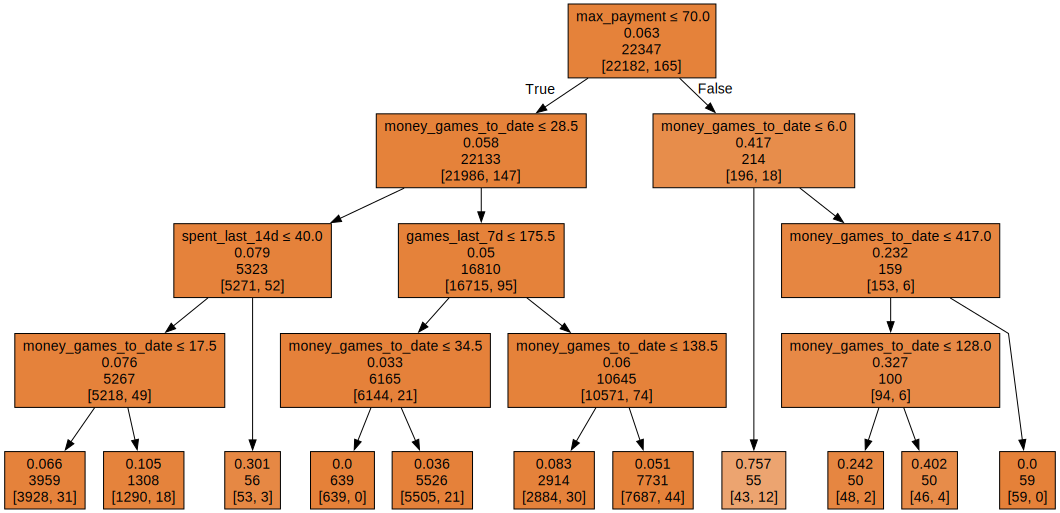

In [133]:
# Create the decision tree classifier
clf = all_model_results[all_model_results['Iteration'] == f'log_loss - {depth} - {leaf_size}']['Model'].values[0][0]

# from sklearn import tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = False
                           ,  rounded=False
                        #    ,  rotate = True
                           ,  special_characters=True)

graphviz.Source(dot_data)


In [134]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        leaf_size = np.sum(tree.value[node_id])
        true_cases = tree.value[node_id][0][1]
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true],
                                                    "Leaf_Size": [leaf_size], "True_Cases": [true_cases]})], ignore_index=True)

    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)
event_columns = dataset['Event'].str.split(' & ', expand=True)
dataset = pd.concat([dataset, event_columns], axis=1)
# dataset = dataset[(dataset['True_Cases'] >= 10) | (dataset['Leaf_Size'] >= 100)]

dataset.sort_values(by = 'Proportion_True', ascending = False)
# dataset['Event'].values

,Event,Proportion_True,Leaf_Size,True_Cases,0,1,2,3
7,max_payment > 70.0 & money_games_to_date ≤ 6.0,0.218182,55.0,12.0,max_payment > 70.0,money_games_to_date ≤ 6.0,None,None
9,max_payment > 70.0 & money_games_to_date > 6.0...,0.080000,50.0,4.0,max_payment > 70.0,money_games_to_date > 6.0,money_games_to_date ≤ 417.0,money_games_to_date > 128.0
2,max_payment ≤ 70.0 & money_games_to_date ≤ 28....,0.053571,56.0,3.0,max_payment ≤ 70.0,money_games_to_date ≤ 28.5,spent_last_14d > 40.0,None
8,max_payment > 70.0 & money_games_to_date > 6.0...,0.040000,50.0,2.0,max_payment > 70.0,money_games_to_date > 6.0,money_games_to_date ≤ 417.0,money_games_to_date ≤ 128.0
1,max_payment ≤ 70.0 & money_games_to_date ≤ 28....,0.013761,1308.0,18.0,max_payment ≤ 70.0,money_games_to_date ≤ 28.5,spent_last_14d ≤ 40.0,money_games_to_date > 17.5
5,max_payment ≤ 70.0 & money_games_to_date > 28....,0.010295,2914.0,30.0,max_payment ≤ 70.0,money_games_to_date > 28.5,games_last_7d > 175.5,money_games_to_date ≤ 138.5
0,max_payment ≤ 70.0 & money_games_to_date ≤ 28....,0.007830,3959.0,31.0,max_payment ≤ 70.0,money_games_to_date ≤ 28.5,spent_last_14d ≤ 40.0,money_games_to_date ≤ 17.5
6,max_payment ≤ 70.0 & money_games_to_date > 28....,0.005691,7731.0,44.0,max_payment ≤ 70.0,money_games_to_date > 28.5,games_last_7d > 175.5,money_games_to_date > 138.5
4,max_payment ≤ 70.0 & money_games_to_date > 28....,0.003800,5526.0,21.0,max_payment ≤ 70.0,money_games_to_date > 28.5,games_last_7d ≤ 175.5,money_games_to_date > 34.5
3,max_payment ≤ 70.0 & money_games_to_date > 28....,0.000000,639.0,0.0,max_payment ≤ 70.0,money_games_to_date > 28.5,games_last_7d ≤ 175.5,money_games_to_date ≤ 34.5


In [69]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def generate_rules_dataframe(tree, X, y_column):
    # Initialize lists to store rules and metrics
    rules = []
    proportion_true_list = []
    leaf_size_list = []
    true_cases_list = []

    # Extract rules and calculate metrics for each node
    def traverse_tree(node_id=0, current_rule=[]):
        # Convert current_rule to a string and append to the rules list
        rules.append(" & ".join(current_rule))

        # Apply the rule to filter the dataset
        if current_rule:
            filtered_data = X.query(" & ".join(current_rule))
            leaf_size = len(filtered_data)
            true_cases = filtered_data[y_column].sum()
            proportion_true = true_cases / leaf_size if leaf_size > 0 else 0
        else:
            # If current_rule is empty, set leaf size, true cases, and proportion true to 0
            leaf_size = 0
            true_cases = 0
            proportion_true = 0

        # Append metrics to the respective lists
        proportion_true_list.append(proportion_true)
        leaf_size_list.append(leaf_size)
        true_cases_list.append(true_cases)
        
        if tree.children_left[node_id] != _tree.TREE_LEAF:
            # Extract feature name and split value
            feature_name = X.columns[tree.feature[node_id]]
            split_value = tree.threshold[node_id]

            # Generate rules for the left child node
            left_rule = current_rule + [f"{feature_name} <= {round(split_value, 3)}"]
            traverse_tree(tree.children_left[node_id], left_rule)

            # Generate rules for the right child node
            right_rule = current_rule + [f"{feature_name} > {round(split_value, 3)}"]
            traverse_tree(tree.children_right[node_id], right_rule)

    traverse_tree()

    traverse_tree()

    # Create DataFrame from collected rules and metrics
    df = pd.DataFrame({
        'Event': rules,
        'Proportion_True': proportion_true_list,
        'Leaf_Size': leaf_size_list,
        'True_Cases': true_cases_list
    })

    return df

# Assuming 'clf' is the trained decision tree classifier and 'X_train' is the training dataset
tree = clf.tree_
X_train_rules = result[payment_cols].copy()  # Make a copy of the dataset to avoid modifying the original data
y_column = 'target_column_name'  # Update with the name of the target column
rules_df = generate_rules_dataframe(tree, X_train_rules, f'disputer')

event_columns = rules_df['Event'].str.split(' & ', expand=True)
rules_df = pd.concat([rules_df, event_columns], axis=1)
# dataset = dataset[(dataset['True_Cases'] >= 10) | (dataset['Leaf_Size'] >= 100)]

rules_df.drop_duplicates().fillna('').sort_values(by = [0,1,2,3,4,5], ascending = True).head(40)

# I want the tree to continue, until we reach the point where we are happy
# We are happy when: 100 sample size, or 10 true cases. 
# So, look at all the break downs and filter them out untill you reach the point where we have the condition met. What we are doing it to prune the tree after trainning to suit our condition. 


,Event,Proportion_True,Leaf_Size,True_Cases,0,1,2,3,4,5
0,,0.000000,0,0,,,,,,
1,spent_last_14d <= 322.0,0.005261,108536,571,spent_last_14d <= 322.0,,,,,
2,spent_last_14d <= 322.0 & games_last_7d <= 3.5,0.017382,2704,47,spent_last_14d <= 322.0,games_last_7d <= 3.5,,,,
3,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.013582,2577,35,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,,,
4,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.005862,853,5,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,,
5,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.014706,340,5,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,games_last_7d <= 1.5,
6,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.000000,252,0,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,games_last_7d <= 1.5,games_to_date <= 0.5
7,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.056818,88,5,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,games_last_7d <= 1.5,games_to_date > 0.5
8,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.000000,513,0,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,games_last_7d > 1.5,
9,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.017401,1724,30,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date > 2.495,,


In [99]:
def find_final_leaves(df):
    final_leaves = []
    
    # Helper function to recursively find final leaves
    def find_final_leaf(row):
        # If leaf size or true cases meet the condition, it's a final leaf
        if row['Leaf_Size'] >= 150 or row['True_Cases'] >= 10:
            final_leaves.append({'Event': row['Event'], 'Proportion_True': row['Proportion_True'],
                                 'Leaf_Size': row['Leaf_Size'], 'True_Cases': row['True_Cases'],
                                 'Node_Type': 'Leaf'})
        else:
            # Find child nodes and check if all are leaf nodes
            child_events = [child_row['Event'] for _, child_row in df.iterrows()
                            if child_row['Event'].startswith(row['Event']) and child_row['Event'] != row['Event']]
            all_child_leaves = all(event in final_leaves for event in child_events)
            
            if all_child_leaves:
                # If all child nodes are leaf nodes, it's a parent node
                final_leaves.append({'Event': row['Event'], 'Proportion_True': row['Proportion_True'],
                                     'Leaf_Size': row['Leaf_Size'], 'True_Cases': row['True_Cases'],
                                     'Node_Type': 'Parent'})
            else:
                # If any child node is not a leaf, it's a leaf node
                final_leaves.append({'Event': row['Event'], 'Proportion_True': row['Proportion_True'],
                                     'Leaf_Size': row['Leaf_Size'], 'True_Cases': row['True_Cases'],
                                     'Node_Type': 'Leaf'})

    # Iterate through each row to find final leaves
    for index, row in df.iterrows():
        if row['Leaf_Size'] == 0:  # Skip non-leaf nodes
            continue
        find_final_leaf(row)
    
    return pd.DataFrame(final_leaves)

# Find final leaves
final_leaves_df = find_final_leaves(rules_df)

def generate_node_ids(df):
    # Create a dictionary to store node IDs
    node_ids = {}
    current_id = 1
    
    # Helper function to recursively assign node IDs
    def assign_node_ids(row, parent_id=None):
        nonlocal current_id
        
        # Assign ID to current node
        node_ids[row['Event']] = current_id
        current_id += 1
        
        # Assign ID to children recursively
        child_events = [child_row['Event'] for _, child_row in df.iterrows()
                        if child_row['Event'].startswith(row['Event']) and child_row['Event'] != row['Event']]
        for child_event in child_events:
            assign_node_ids(df[df['Event'] == child_event].iloc[0], parent_id=node_ids[row['Event']])
    
    # Start assigning node IDs recursively
    root_event = df['Event'].iloc[0]
    assign_node_ids(df[df['Event'] == root_event].iloc[0])
    
    return node_ids

# Generate node IDs
node_ids = generate_node_ids(final_leaves_df)

# Add node ID column to final_leaves_df
final_leaves_df['Node_ID'] = final_leaves_df['Event'].map(node_ids)

# Check if children meet the condition
final_leaves_df['Children_Meet_Condition'] = final_leaves_df['Event'].apply(
    lambda x: any((child_row['Leaf_Size'] >= 150 or child_row['True_Cases'] >= 10)
                  for _, child_row in final_leaves_df.iterrows()
                  if child_row['Event'].startswith(x) and child_row['Event'] != x)
)

# Display final_leaves_df with Node_ID and Children_Meet_Condition columns
final_leaves_df.sort_values(by = 'Proportion_True', ascending = False).head(20)

# Reset index
final_leaves_df.reset_index(drop = True, inplace = True)

# Now, 'final_leaves_df' contains the final leaf nodes meeting the condition
final_leaves_df.sort_values(by = 'Proportion_True', ascending = False).head(20)


,Event,Proportion_True,Leaf_Size,True_Cases,Node_Type,Node_ID,Children_Meet_Condition
51,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.750000,20,15,Leaf,NaN,False
107,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.750000,20,15,Leaf,NaN,False
50,spent_last_14d > 322.0 & games_last_7d <= 30.5,0.545455,55,30,Leaf,NaN,True
106,spent_last_14d > 322.0 & games_last_7d <= 30.5,0.545455,55,30,Leaf,NaN,True
108,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.428571,35,15,Leaf,NaN,False
52,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.428571,35,15,Leaf,NaN,False
105,spent_last_14d > 322.0,0.286885,122,35,Leaf,NaN,True
49,spent_last_14d > 322.0,0.286885,122,35,Leaf,NaN,True
99,spent_last_14d <= 322.0 & games_last_7d > 3.5 ...,0.200000,30,6,Parent,4144.0,False
23,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.200000,25,5,Parent,3100.0,False


In [101]:
final_leaves_df[final_leaves_df['Children_Meet_Condition'] == False].sort_values(by='Proportion_True', ascending=False).head(20)

,Event,Proportion_True,Leaf_Size,True_Cases,Node_Type,Node_ID,Children_Meet_Condition
51,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.750000,20,15,Leaf,NaN,False
107,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.750000,20,15,Leaf,NaN,False
52,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.428571,35,15,Leaf,NaN,False
108,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.428571,35,15,Leaf,NaN,False
79,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.200000,25,5,Parent,3100.0,False
43,spent_last_14d <= 322.0 & games_last_7d > 3.5 ...,0.200000,30,6,Parent,4144.0,False
99,spent_last_14d <= 322.0 & games_last_7d > 3.5 ...,0.200000,30,6,Parent,4144.0,False
23,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.200000,25,5,Parent,3100.0,False
110,spent_last_14d > 322.0 & games_last_7d > 30.5 ...,0.178571,28,5,Parent,NaN,False
54,spent_last_14d > 322.0 & games_last_7d > 30.5 ...,0.178571,28,5,Parent,NaN,False


In [92]:
final_leaves_df[final_leaves_df.index == 50]['Event'].values[0]

'spent_last_14d > 322.0 & games_last_7d <= 30.5'

In [33]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True", "Leaf_Size", "True_Cases"])
    
    if path is None:
        path = []

    if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        leaf_size = np.sum(tree.value[node_id])
        print(tree.value[node_id])
        true_cases = tree.value[node_id][0][1]  # Accessing the true cases correctly
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true],
                                                    "Leaf_Size": [leaf_size], "True_Cases": [true_cases]})], ignore_index=True)

    return dataset

# Convert DataFrame X_train to ndarray
X_train_array = X_train.values

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)
event_columns = dataset['Event'].str.split(' & ', expand=True)
dataset = pd.concat([dataset, event_columns], axis=1)

dataset.sort_values(by='Proportion_True', ascending=False)


[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]


,Event,Proportion_True,Leaf_Size,True_Cases,0,1,2,3,4,5,6
0,spent_last_14d ≤ 322.0 & games_last_7d ≤ 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d ≤ 3.5,spent_last_14d ≤ 35.0,spent_to_date ≤ 2.495,games_last_7d ≤ 1.5,games_to_date ≤ 0.5,daily_pay_std ≤ -2.0
43,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d > 6.5,games_to_date ≤ 1443.5,games_to_date > 1432.5,daily_pay_std > -2.0,None
31,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent ≤ 4.5,daily_pay_std > 0.697,money_games_to_date > 435.5,daily_pay_std > -2.0
32,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date ≤ 18.5,daily_pay_std ≤ -2.0,None
33,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date ≤ 18.5,daily_pay_std > -2.0,None
34,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date > 18.5,money_games_to_date ≤ 19.5,daily_pay_std ≤ -2.0
35,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date > 18.5,money_games_to_date ≤ 19.5,daily_pay_std > -2.0
36,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date > 18.5,money_games_to_date > 19.5,daily_pay_std ≤ -2.0
37,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date > 18.5,money_games_to_date > 19.5,daily_pay_std > -2.0
38,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d > 6.5,games_to_date ≤ 1443.5,games_to_date ≤ 1432.5,spent_to_date ≤ 95.0,daily_pay_std ≤ -2.0


# Measure of performance

# Data manipulation

In [154]:
result = lt_recent_payment_df.copy(deep = True)
result['disputer'] =  result['new_disputer_30d']

In [155]:
# Generate a function that generates the log of a list of column names in a dataframe:
cols = ['spent_to_date', 'max_payment', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments']

column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date', 'bet_money_last_7d', 'bet_money_last_14d', 'money_games_last_7d', 'money_games_last_14d', 'chip_games_last_14d']
def log_transform_columns(df, column_names):
    new_columns = []
    for col in column_names:
        new_col_name = f'l_{col}'
        df[new_col_name] = np.log(df[col])
        new_columns.append(new_col_name)
    return df, new_columns
result, logs_columns = log_transform_columns(result, column_names)
print(logs_columns)


# Generate a function that divides all the columns in a list by the columns in another list:
def divide_columns(df, dividend_columns, divisor_columns):
    new_columns = []
    for dividend_col, divisor_col in zip(dividend_columns, divisor_columns):
        new_col_name = f'ratio_{dividend_col}_to_{divisor_col}'
        df[new_col_name] = df[dividend_col] / df[divisor_col]
        new_columns.append(new_col_name)
    return df, new_columns

dividend_columns = ['spent_to_date']
divisor_columns = ['user_matuirity', 'payments_to_date']
result, ratios_columns_1 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_1)

dividend_columns = ['max_payment_in_day', 'max_payment']
divisor_columns = ['spent_to_date', 'payments_to_date']
result, ratios_columns_2 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_2)

dividend_columns = ['money_games_working_hours_last_14d']
divisor_columns = ['money_games_last_14d']
result, ratios_columns_3 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_3)

# Generate a function that generates all the multiplications between the columns in a dataframe
def generate_multiplications(df):
    new_columns = []
    columns = df.columns
    for i, col1 in enumerate(columns):
        for col2 in columns[i + 1:]:
            new_col_name = f'{col1}_x_{col2}'
            df[new_col_name] = df[col1] * df[col2]
            new_columns.append(new_col_name)
    return df, new_columns
# result, interacations_columns = generate_multiplications(result, column_names)


# Generate a function that generates k dummy variables in each column in list, where k is the number of quantiles - 1. The lowest quantile is left
column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date', 'max_bet']
def generate_quantile_dummies(df, column_names, num_quantiles):
    new_columns = []
    for col in column_names:
        quantiles = df[col].quantile(np.linspace(0, 1, num_quantiles + 1)).reset_index(drop = True)
        for i in range(1, num_quantiles):
            new_col = f'{col}_quantile_{i}'
            df[new_col] = (df[col] > quantiles[i-1]).astype(int)
            new_columns.append(new_col)
    return df, new_columns
result, quantile_columns = generate_quantile_dummies(result, column_names, num_quantiles = 10)
print(quantile_columns)

# Generate a function that generates a dummy variable in each column in list, where 1 if the value is an outlier, and 0 otherwise.
column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date']
def generate_outlier_dummies(df, column_names):
    new_columns = []
    for col in column_names:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        new_col_name = f'{col}_outlier'
        df[new_col_name] = ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)
        new_columns.append(new_col_name)
    return df, new_columns
result, outlier_columns = generate_outlier_dummies(result, column_names)
print(outlier_columns)


KeyError: 'spent_last_7_days'

In [156]:
# cols = ['max_spent', 'daily_spent', 'spent_deviation', 'spent_ratio', 'time_to_payment', 'payments']
# cols = ['spent_to_date', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments'] + logs_columns + ratios_columns_1 + ratios_columns_2 + ratios_columns_3 + quantile_columns + outlier_columns
cols = ['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date'
        ,  'payments_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']

print(cols)

print(len(result[cols].columns))
# time_pay_to_dispute	time_to_dispute	payments_to_date	payments_last_7_days	spent_last_7_days	spent_to_date	max_payment	max_payment_in_day	std_payments	disputer_lt_30d
result = result.replace([np.inf, -np.inf, np.nan], 0)
print(len(result[cols].columns))

result.loc[:, (result != result.iloc[0]).any()]
len(result[cols].columns)


['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date', 'payments_to_date', 'spent_last_14d', 'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']
13
13


13

# Exploration of overfit and explanainable model

In [157]:

def create_model(criterion, depth, leaf_size):

    # preprocessor = ColumnTransformer(
    #     transformers = [
    #         ('scaler', StandardScaler(), cols)
    #     ],
    #     remainder='passthrough'
    # )

    # Create the pipeline
    pipe = Pipeline([
        # ('preprocessor', preprocessor),
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
        # ('regressor', RandomForestClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [158]:
validation_sets = 3
result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
result.groupby('validation_set_id').size()

validation_set_id
(20231001.999, 20231210.0]    1969
(20231210.0, 20231230.0]      1891
(20231230.0, 20240202.0]      1838
dtype: int64

In [186]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score

model_results = []
all_model_results = []
criteria = ['log_loss']
depths = [5]
leaf_sizes = [50]
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    # train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]
    train_data =  result[result['validation_set_id'] == date_group][payment_cols]
    train_data =  result[payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


In [187]:
# all_model_results.groupby(['Iteration', 'Test at', 'Model']).mean()
amrgb = all_model_results.groupby('Iteration')[['accuracy', 'precission']].mean().sort_values(by = 'accuracy', ascending = False).reset_index(drop = False)
amrgb

,Iteration,accuracy,precission
0,log_loss - 5 - 50,0.995511,0.0


In [189]:
# all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 350']['Model'].values[0]
all_model_results[all_model_results['Iteration'] == 'log_loss - 6 - 50']['Model'].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

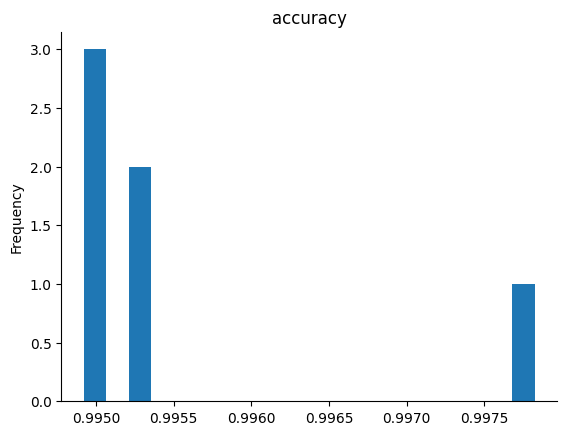

In [162]:
# @title accuracy

from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [163]:
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 4 - 100']['Model'].values[0]
payment_cols
train_data.columns

Index(['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d',
       'games_last_14d', 'games_last_7d', 'games_to_date', 'payments_to_date',
       'spent_last_14d', 'spent_last_7d', 'max_daily_spent', 'daily_pay_std',
       'money_games_to_date', 'disputer'],
      dtype='object')

In [164]:
train_data.columns
train_data['Predicted_Probability_A'] = clf.predict_proba(train_data[cols])[:, 1]  # Probability of class 1
train_data['True_Label'] = train_data[f'disputer']

import plotly.graph_objects as go

# Initialize lists to store results
thresholds = np.linspace(0, 0.9, 100)  # Thresholds from 0 to 30%
bad_users = []
correct_bad_users = []

# Iterate through thresholds
for threshold in thresholds:
    # Classify users as "bad" if their probability is above the threshold
    classified_as_bad = train_data['Predicted_Probability_A'] > threshold
    
    # Count the total number of users classified as "bad"
    total_bad = np.sum(classified_as_bad)
    
    # Count the number of correctly classified "bad" users
    correctly_classified_bad = np.sum(classified_as_bad & (train_data['True_Label'] == 1))
    
    # Append results to lists
    bad_users.append(total_bad)
    correct_bad_users.append(correctly_classified_bad)

# Convert total bad users to percentage
total_users = len(train_data)
bad_users_percentage = [bad / total_users * 100 for bad in bad_users]

# Plot the results using Plotly with a bigger figure size
fig = go.Figure()
fig.add_trace(go.Scatter(x=thresholds, y=bad_users_percentage, mode='lines', name='Total Bad Users (%)'))
fig.add_trace(go.Scatter(x=thresholds, y=correct_bad_users, mode='lines', name='Correctly Classified Bad Users'))
fig.update_layout(title='Number of Users vs Threshold', xaxis_title='Threshold', yaxis_title='Number of Users', legend=dict(x=0, y=1), width=2000, height=1000)
fig.show()

In [165]:
def calculate_percentage(df, threshold):
    """
    Calculate the percentage of observations with a probability greater than or equal to the threshold
    and the percentage of cases above the threshold that are actually true (1), out of all the true cases.
    
    Args:
    - df (DataFrame): DataFrame containing actual observations and predicted probabilities.
                      It should have columns 'Predicted_Probability' and 'True_Label'.
    - threshold (float): Threshold value for classification.
    
    Returns:
    - percent_above_threshold (float): Percentage of observations with a probability greater than or equal to the threshold.
    - percent_true_above_threshold (float): Percentage of cases above the threshold that are actually true (1),
                                             out of all the true cases.
    """
    # Filter rows where predicted probability is greater than or equal to the threshold
    above_threshold = df['Predicted_Probability'] >= threshold
    
    # Calculate percentage of observations above the threshold
    percent_above_threshold = (above_threshold.sum() / len(df)) * 100
    
    # Filter rows where predicted probability is above the threshold and true label is 1
    true_above_threshold = df.loc[above_threshold, 'True_Label'] == 1
    
    # Calculate percentage of true cases above the threshold out of all true cases
    if df['True_Label'].sum() > 0:
        percent_true_above_threshold = (true_above_threshold.sum() / df['True_Label'].sum()) * 100
    else:
        percent_true_above_threshold = 0  # Handle case where there are no true cases
    
    return percent_above_threshold, percent_true_above_threshold

train_data.columns
train_data['Predicted_Probability'] = clf.predict_proba(train_data[cols])[:, 1]  # Probability of class 1
train_data['True_Label'] = train_data[f'disputer']

In [166]:
# Assuming you have already calculated 'Predicted_Probability_A' and 'True_Label' columns in your DataFrame 'train_data'

# Set the threshold value
threshold = 0.024 # Adjust as needed

# Apply the function to calculate percentages
percent_above_threshold, percent_true_above_threshold = calculate_percentage(train_data, threshold)

# Print the results
print("Percentage of observations with probability greater than or equal to the threshold:", percent_above_threshold)
print("Percentage of true cases above the threshold out of all true cases:", percent_true_above_threshold)


Percentage of observations with probability greater than or equal to the threshold: 4.15935415935416
Percentage of true cases above the threshold out of all true cases: 39.130434782608695


[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


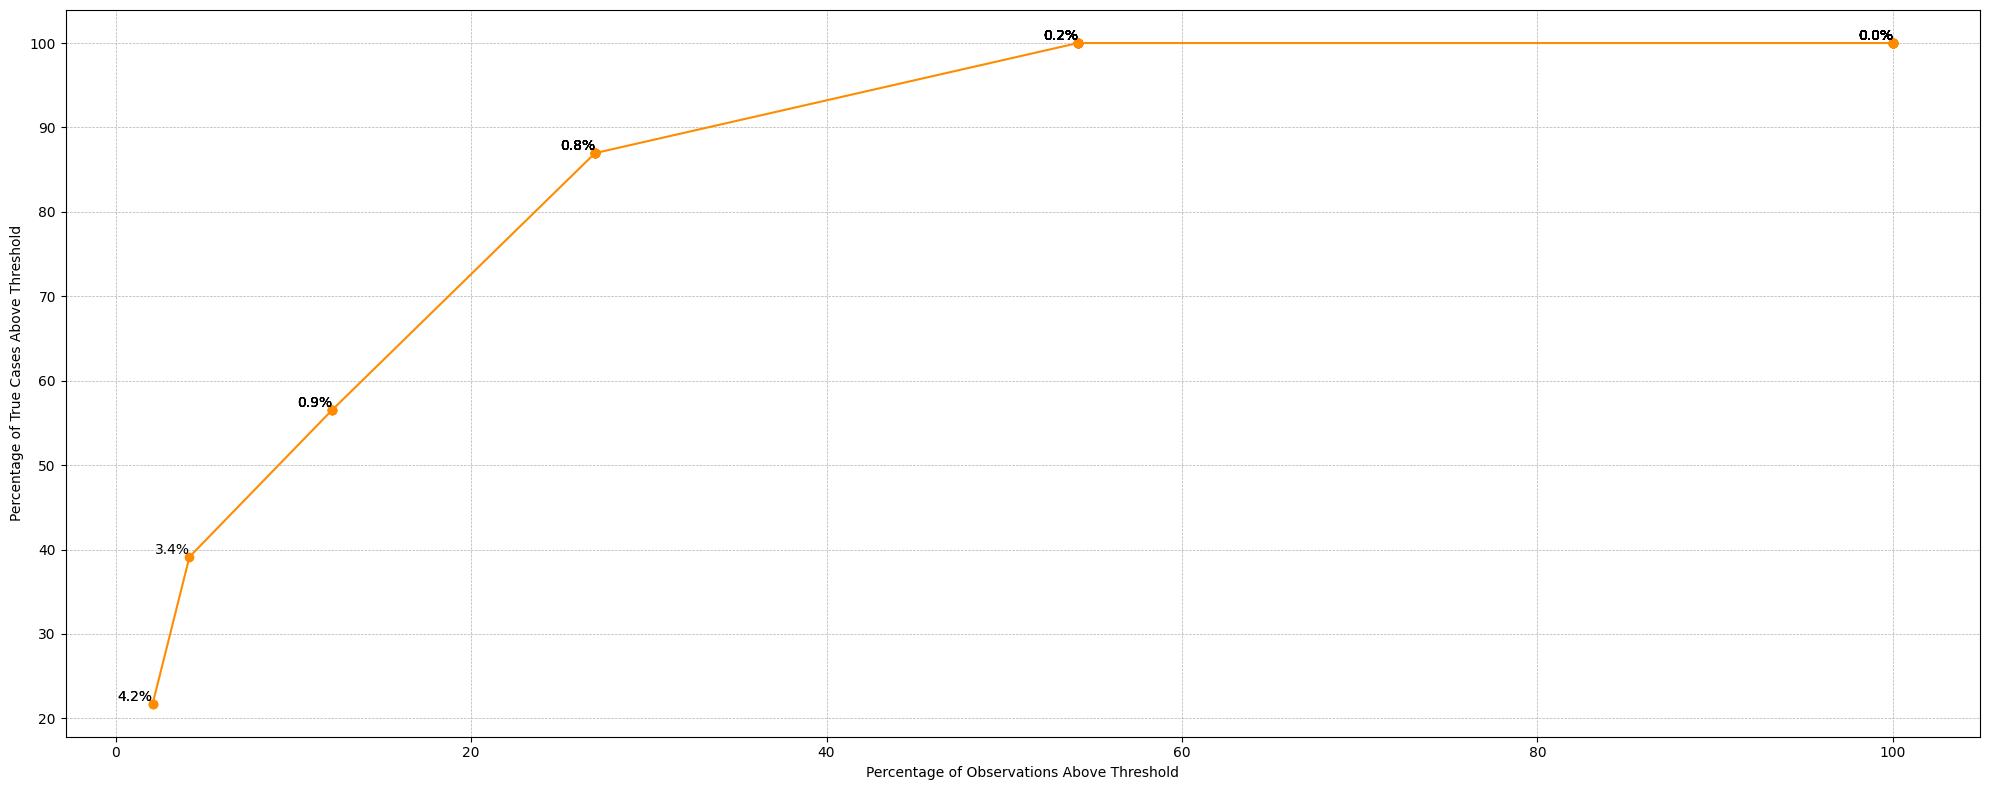

In [167]:
quantiles = np.linspace(0, 1, 51)  # Divide the range [0, 1] into 10 quantiles
print(quantiles)
# Initialize lists to store results
percent_above_thresholds = []
percent_true_above_thresholds = []
quantile_values = []

# Iterate through quantiles
for quantile in quantiles:
    threshold = train_data['Predicted_Probability'].quantile(quantile)
    percent_above_threshold, percent_true_above_threshold = calculate_percentage(train_data, threshold)
    percent_above_thresholds.append(percent_above_threshold)
    percent_true_above_thresholds.append(percent_true_above_threshold)
    quantile_values.append(threshold)

# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(percent_above_thresholds, percent_true_above_thresholds, marker='o', color='darkorange', linestyle='-')
for i, txt in enumerate(quantile_values):
    plt.annotate(f'{txt*100:.1f}%', (percent_above_thresholds[i], percent_true_above_thresholds[i]), fontsize=10, ha='right', va='bottom')
plt.xlabel('Percentage of Observations Above Threshold')
plt.ylabel('Percentage of True Cases Above Threshold')
# plt.title('Percentage of True Cases vs Percentage of Observations Above Threshold')
plt.title('')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [168]:

# Rule identifier 
node_size = 0.02
found = (0.10 * node_size) 
total = 0.01

impact_dispute_rate = found / total
impact_users = total 

print(impact_dispute_rate, impact_users)

0.2 0.01


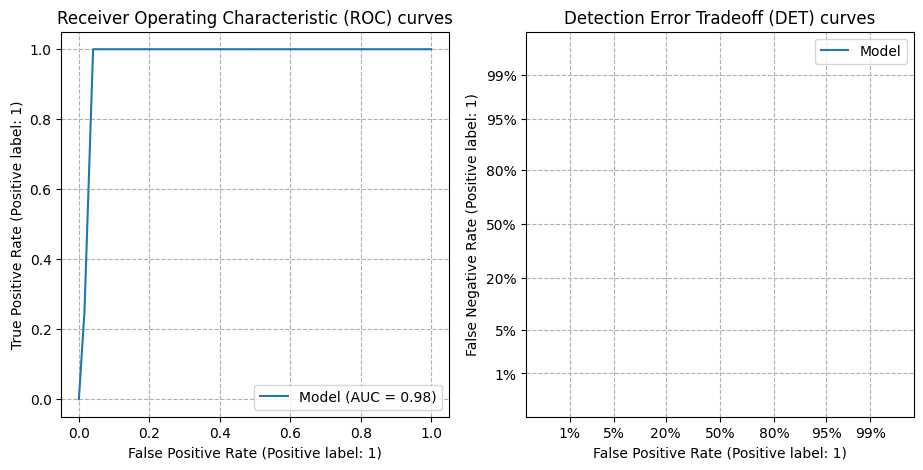

In [169]:

import matplotlib.pyplot as plt

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

# for name, clf in classifiers.items():
#     clf.fit(X_train, y_train)

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name='Model')
DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name='Model')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date', 'payments_to_date', 'spent_last_14d', 'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']


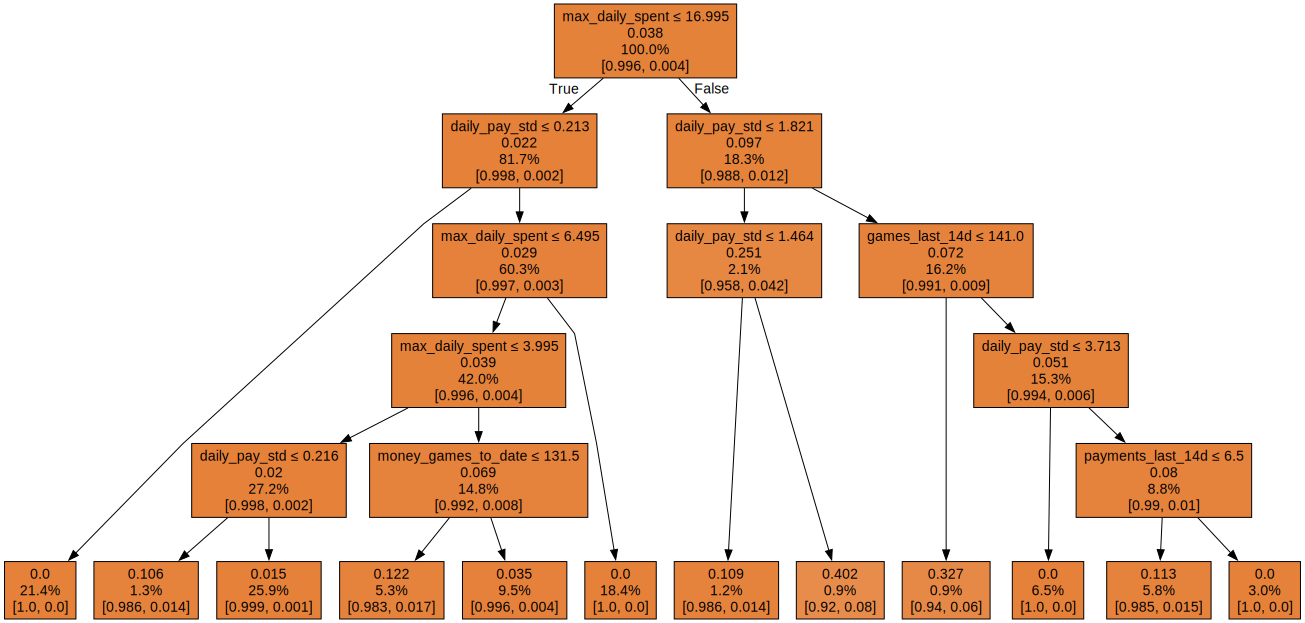

In [190]:
# from sklearn import tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier
# clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 350']['Model'].values[0][0]
# clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 70']['Model'].values[0][0]
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 50']['Model'].values[0][0]

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

print(cols)
# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                        #    ,  rotate = True
                           ,  special_characters=True)

graphviz.Source(dot_data)
# print(dot_data)



In [230]:
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=[f"Breakdown_{depth + 1}", f"Proportion_{depth + 1}"])
    
    if tree.children_left[node_id] != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        breakdown_left = f"{feature_name} ≤ {round(split_value, 3)}"
        proportion_left = 1 - (tree.value[node_id][0][y_train[node_id]] / np.sum(tree.value[node_id]))
        dataset.at[node_id, f"Breakdown_{depth + 1}"] = breakdown_left
        dataset.at[node_id, f"Proportion_{depth + 1}"] = proportion_left
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset)
        
    if tree.children_right[node_id] != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        breakdown_right = f"{feature_name} > {split_value}"
        proportion_right = 1 - (tree.value[node_id][0][y_train[node_id]] / np.sum(tree.value[node_id]))
        dataset.at[node_id, f"Breakdown_{depth + 2}"] = breakdown_right
        dataset.at[node_id, f"Proportion_{depth + 2}"] = proportion_right
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset)
    
    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)

dataset




,Breakdown_1,Proportion_1,Breakdown_2,Proportion_2,Breakdown_3,Proportion_3,Breakdown_4,Proportion_4,Breakdown_5,Proportion_5,Breakdown_6,Proportion_6
0,max_daily_spent ≤ 16.995,0.004037,max_daily_spent > 16.994999885559082,0.004037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,daily_pay_std ≤ 0.213,0.002148,daily_pay_std > 0.21260014921426773,0.002148,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,max_daily_spent ≤ 6.495,0.002909,max_daily_spent > 6.494999885559082,0.002909,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,max_daily_spent ≤ 3.995,0.004182,max_daily_spent > 3.9950000047683716,0.004182,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,daily_pay_std ≤ 0.216,0.001938,daily_pay_std > 0.21570930629968643,0.001938
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,money_games_to_date ≤ 131.5,0.008304,money_games_to_date > 131.5,0.008304
12,NaN,NaN,daily_pay_std ≤ 1.821,0.012464,daily_pay_std > 1.8213537335395813,0.012464,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,daily_pay_std ≤ 1.464,0.042017,daily_pay_std > 1.4639541506767273,0.042017,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,games_last_14d ≤ 141.0,0.008658,games_last_14d > 141.0,0.008658,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,daily_pay_std ≤ 3.713,0.005721,daily_pay_std > 3.7133249044418335,0.005721,NaN,NaN


In [234]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}", False)]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}", True)]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        event = " AND ".join([f"{event_name} is {is_true}" for event_name, is_true in path])
        new_row = pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true]})
        dataset = pd.concat([dataset, new_row], ignore_index=True)
    
    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)

dataset.sort_values(by = 'Proportion_True', ascending = False)
dataset['Event'].values

array(['max_daily_spent ≤ 16.995 is False AND daily_pay_std ≤ 0.213 is False',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent ≤ 6.495 is False AND max_daily_spent ≤ 3.995 is False AND daily_pay_std ≤ 0.216 is False',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent ≤ 6.495 is False AND max_daily_spent ≤ 3.995 is False AND daily_pay_std > 0.216 is True',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent ≤ 6.495 is False AND max_daily_spent > 3.995 is True AND money_games_to_date ≤ 131.5 is False',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent ≤ 6.495 is False AND max_daily_spent > 3.995 is True AND money_games_to_date > 131.5 is True',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent > 6.495 is True',
       'max_daily_spent > 16.995 is True AND daily_

In [238]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true]})], ignore_index=True)
    
    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)

dataset
dataset['Event'].values

array(['max_daily_spent > 16.995 & daily_pay_std > 0.213',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent > 6.495 & max_daily_spent > 3.995 & daily_pay_std > 0.216',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent > 6.495 & max_daily_spent > 3.995 & daily_pay_std ≤ 0.216',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent > 6.495 & max_daily_spent ≤ 3.995 & money_games_to_date > 131.5',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent > 6.495 & max_daily_spent ≤ 3.995 & money_games_to_date ≤ 131.5',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent ≤ 6.495',
       'max_daily_spent ≤ 16.995 & daily_pay_std > 1.821 & daily_pay_std > 1.464',
       'max_daily_spent ≤ 16.995 & daily_pay_std > 1.821 & daily_pay_std ≤ 1.464',
       'max_daily_spent ≤ 16.995 & daily_pay_std ≤ 1.821 & games_last_14d > 141.0',
       'max_daily_spent ≤ 16.995 & daily_pay_std ≤ 1.8

In [223]:
# Merge breakdown columns into one unified column
breakdown_cols = [col for col in dataset.columns if col.startswith("Breakdown")]
dataset["Breakdown"] = dataset[breakdown_cols].apply(lambda row: ", ".join(row.dropna()), axis=1)

# Create a single "Proportion" column
proportion_cols = [col for col in dataset.columns if col.startswith("Proportion")]
dataset["Proportion"] = dataset[proportion_cols].fillna(0).max(axis=1)

# Drop the original breakdown and proportion columns
dataset = dataset.drop(columns=breakdown_cols + proportion_cols)

# Sort the dataframe by the "Proportion" column
dataset = dataset.sort_values(by="Proportion", ascending=False).reset_index(drop = True)

In [226]:
dataset[dataset.index == 0]['Breakdown'][0]

'daily_pay_std ≤ 1.464, daily_pay_std > 1.4639541506767273'

In [227]:
dataset

,Breakdown,Proportion
0,"daily_pay_std ≤ 1.464, daily_pay_std > 1.46395...",0.042017
1,"daily_pay_std ≤ 1.821, daily_pay_std > 1.82135...",0.012464
2,"payments_last_14d ≤ 6.5, payments_last_14d > 6.5",0.009940
3,"games_last_14d ≤ 141.0, games_last_14d > 141.0",0.008658
4,"money_games_to_date ≤ 131.5, money_games_to_da...",0.008304
5,"daily_pay_std ≤ 3.713, daily_pay_std > 3.71332...",0.005721
6,"max_daily_spent ≤ 3.995, max_daily_spent > 3.9...",0.004182
7,"max_daily_spent ≤ 16.995, max_daily_spent > 16...",0.004037
8,"max_daily_spent ≤ 6.495, max_daily_spent > 6.4...",0.002909
9,"daily_pay_std ≤ 0.213, daily_pay_std > 0.21260...",0.002148


If approapiate you can rebalance the number of users

In [25]:
# response_data[response_data['daily_spent'] >= 53.274][response_data['spent_deviation'] <= 4.622].head(20)
# response_data[response_data['daily_spent'] >= 53.274][response_data['payments'] <= 7.5].head(20)
# response_data[response_data['daily_spent'] > 18.215][response_data['payments'] <= 3.5].head(20)
# # response_data[response_data['daily_spent'] > 18.215][response_data['payments'] <= 3.5]

The conclusion is that the model looks for high payers, and it barely cares about withdrawal patterns.

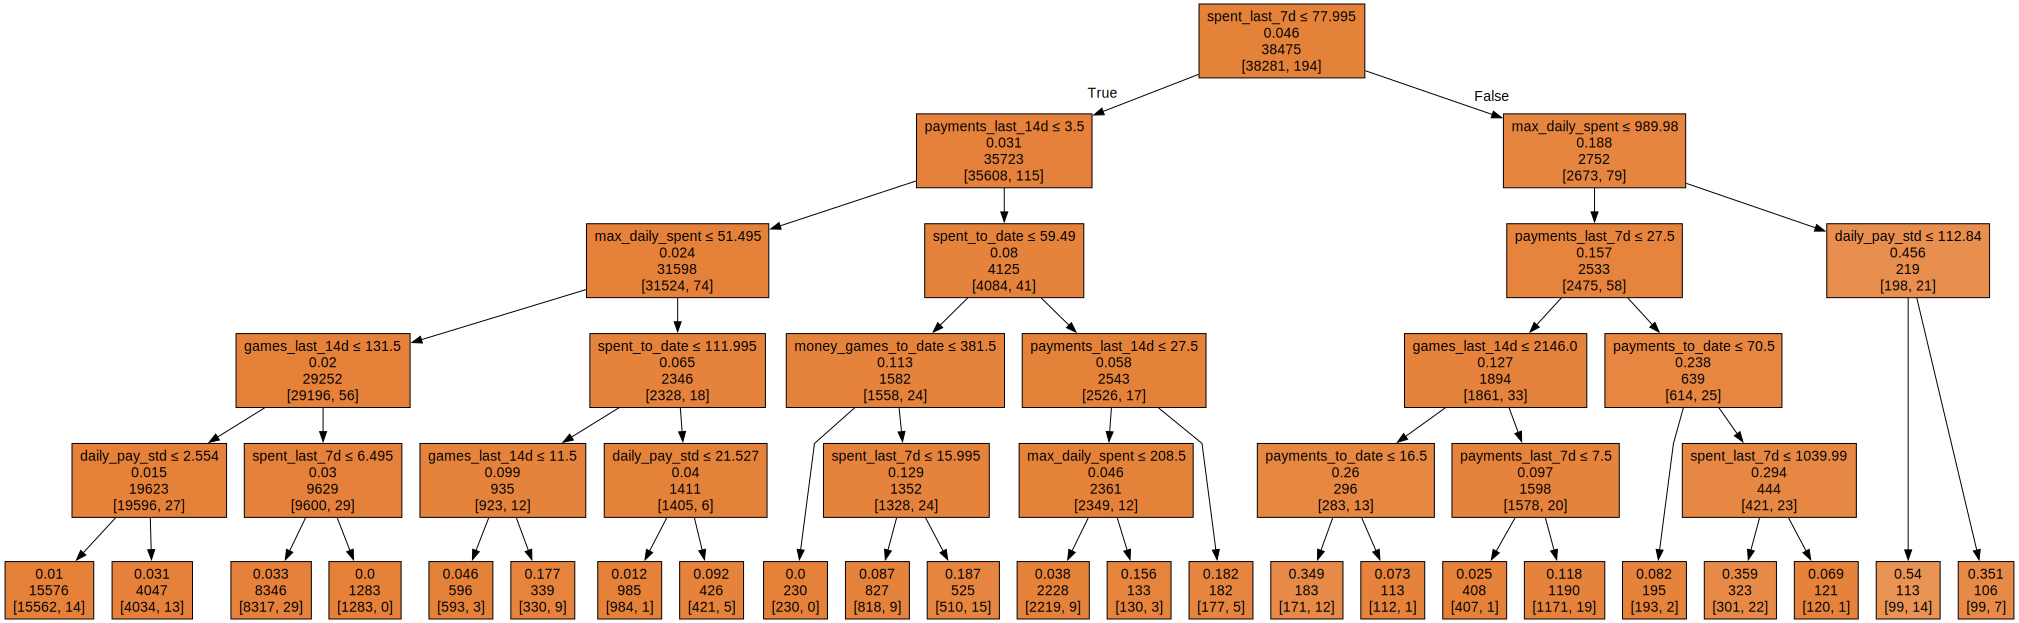

In [46]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled = True
                           ,  leaves_parallel = True
                          #  ,  proportion = True
                           ,  rounded = False
                           ,  special_characters = True)

graphviz.Source(dot_data)



# Real model selection

In [47]:
validation_sets = 3
# result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
# result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()


validation_set_id
(20231001.999, 20231216.0]    13491
(20231216.0, 20240104.0]      12199
(20240104.0, 20240122.0]      12785
dtype: int64

In [48]:
result['validation_set_id'].unique()

[(20231001.999, 20231216.0], (20231216.0, 20240104.0], (20240104.0, 20240122.0]]
Categories (3, interval[float64, right]): [(20231001.999, 20231216.0] < (20231216.0, 20240104.0] < (20240104.0, 20240122.0]]

In [49]:

train_data =  result[result['validation_set_id'] != result['validation_set_id'].unique()[2]][payment_cols]
test_data =  result[result['validation_set_id'] == result['validation_set_id'].unique()[2]][payment_cols]

X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

# X_train.sample(5)
X_test.sample(5)

,spent_to_date,max_payment,payments_last_14d,payments_last_7d,games_last_14d,games_last_7d,games_to_date,payments_to_date,spent_last_14d,spent_last_7d,max_daily_spent,daily_pay_std,money_games_to_date
11743,3.0,3.0,0,0,0.0,0.0,192.0,1,0.0,0.0,3.0,0.639602,164.0
13973,3.0,3.0,0,0,0.0,0.0,773.0,1,0.0,0.0,3.0,0.639602,432.0
8154,80.0,20.0,2,2,5255.0,1609.0,9134.0,7,30.0,30.0,30.0,6.119304,1000.0
3642,6.0,2.0,0,0,0.0,0.0,287.0,3,0.0,0.0,4.0,0.588490,125.0
29068,8.0,5.0,0,0,237.0,231.0,655.0,2,0.0,0.0,5.0,1.216766,306.0


In [30]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

# class_weight
lr              = LogisticRegression(C = 1.0, max_iter = 180, n_jobs = 5)
lr              = LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5)
# I want a model  

# gnb_isotonic    = CalibratedClassifierCV(gnb, cv = 2, method="isotonic")
# gnb_sigmoid     = CalibratedClassifierCV(gnb, cv = 2, method="sigmoid")
# Random_Forest_1 = RandomForestClassifier(min_samples_leaf = 25, n_jobs = 5)
Random_Forest_40  = RandomForestClassifier(min_samples_leaf = 40, n_jobs = 5)
Random_Forest_200 = RandomForestClassifier(min_samples_leaf = 200, n_jobs = 5)
dt                = DecisionTreeClassifier(min_samples_leaf = 350)

clf_list = [
    (lr, "Logistic")
    , (dt, "Classification Tree")
    , (Random_Forest_40, "Random_Forest_40")
    , (Random_Forest_200, "Random_Forest_200")
]

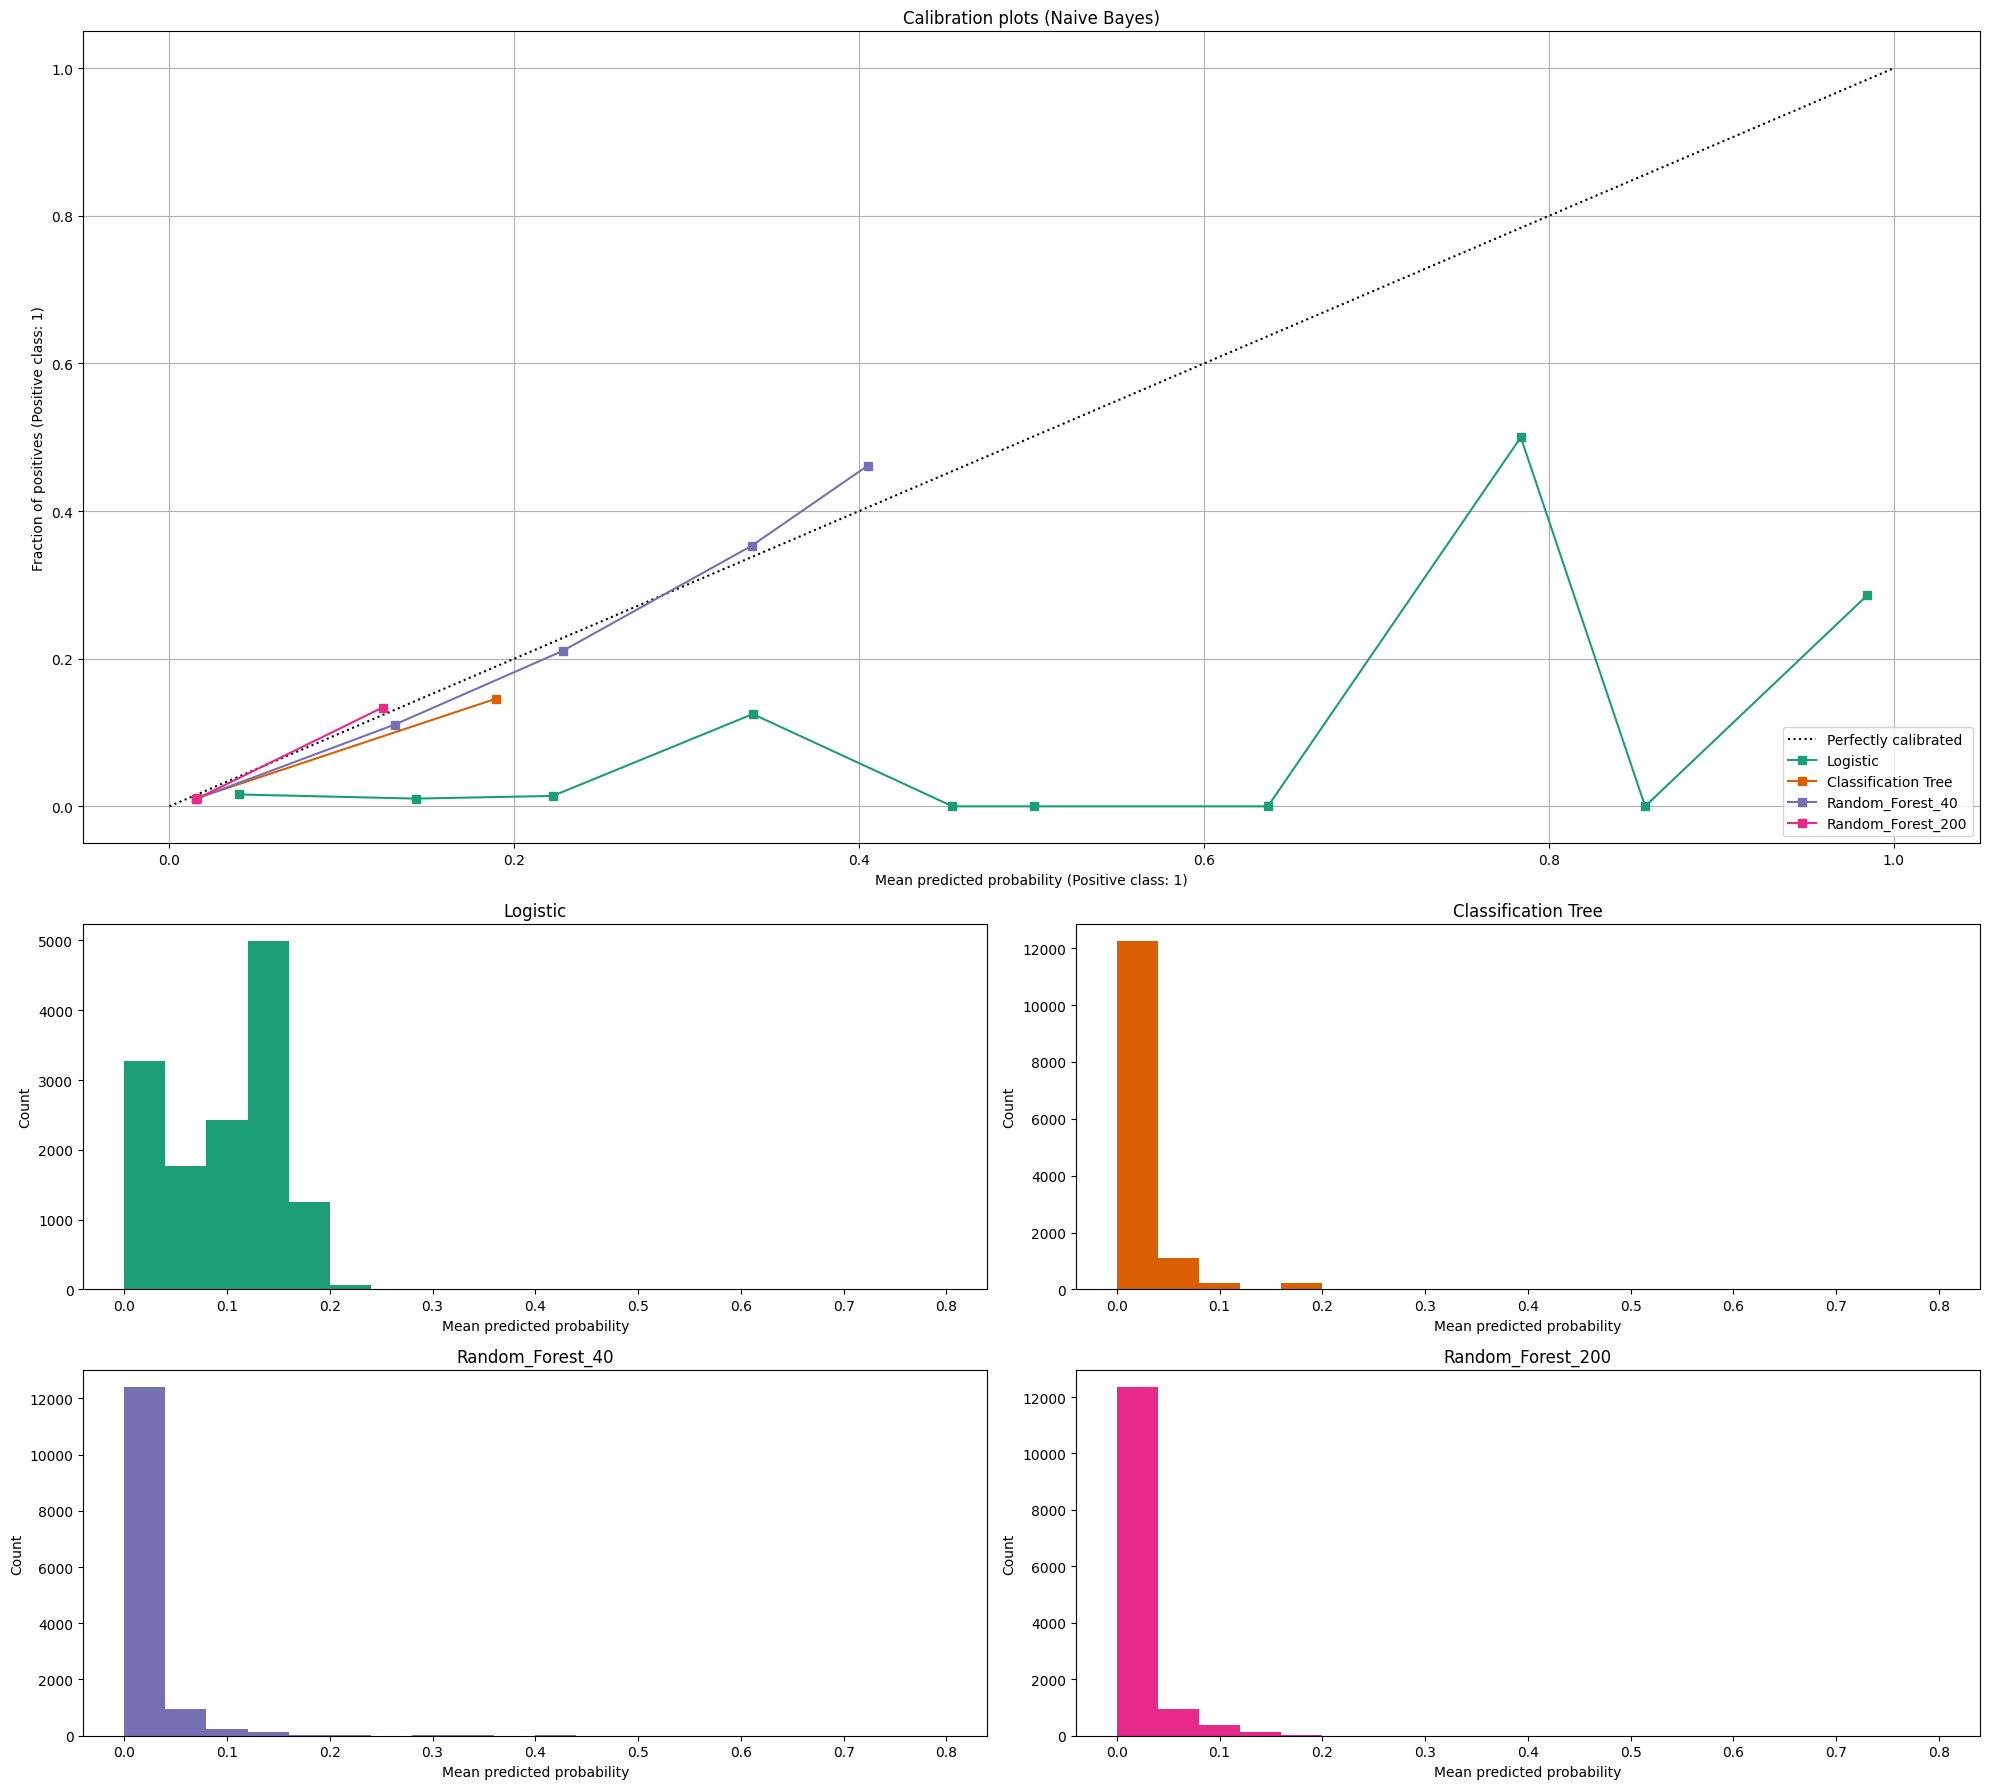

In [31]:
fig = plt.figure(figsize=(20, 18))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")
fitted_models = {}

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    fitted_models[name] = clf

    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins = 10,
        name = name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 0.8),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# I want to add more details to the plot 

plt.tight_layout()
plt.show()

In [57]:
Random_Forest_1.fit(X_train[cols], y_train)
predictions = Random_Forest_1.predict(X_test[cols])
prob_predictions = Random_Forest_1.predict_proba(X_test[cols])
accuracy = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions)


In [58]:
predictions
prob_predictions[:, 1].max()

0.5177635281705086

In [32]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

KeyboardInterrupt: 

In [60]:
X_test

,spent_to_date,max_payment,payments_to_date,user_matuirity,payments_last_7_days,spent_last_7_days,max_payment_in_day,std_payments
562473,127.98,29.99,14,43,0,0.0,83.98,33.139343
562474,127.98,29.99,14,42,0,0.0,83.98,33.139343
562475,127.98,29.99,14,41,0,0.0,83.98,33.139343
562476,127.98,29.99,14,40,0,0.0,83.98,33.139343
562477,127.98,29.99,14,39,0,0.0,83.98,33.139343
...,...,...,...,...,...,...,...,...
819021,10.00,10.00,1,15,0,0.0,10.00,0.000000
819022,5.00,5.00,1,15,0,0.0,5.00,0.000000
819023,31.00,5.00,8,15,0,0.0,19.00,4.949747
819024,40.00,10.00,6,15,1,5.0,15.00,5.773503


0.0
1.0



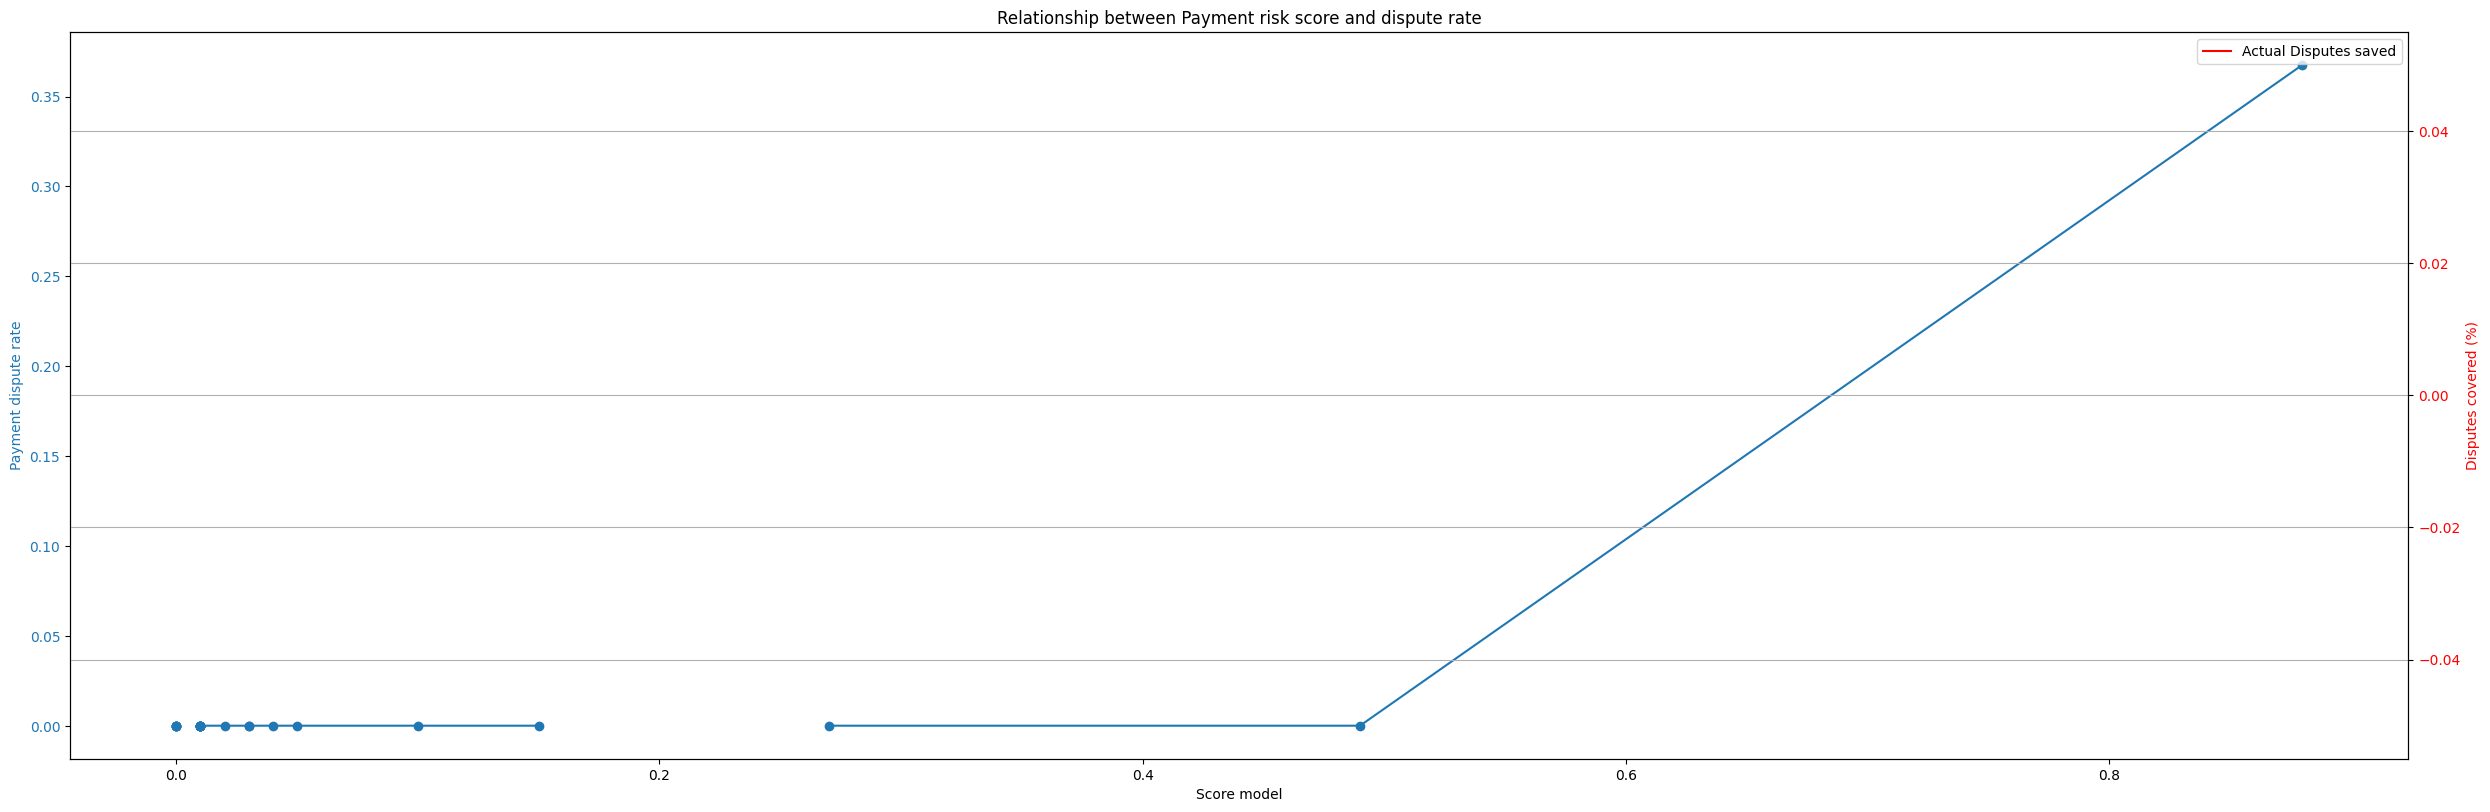

In [42]:
# Don't run
X_test_old = X_test.copy(deep = True)
X_test = X_test_old.copy(deep = True)

X_test['pred'] = Random_Forest.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run
print(X_test['pred'].min())
print(X_test['pred'].max())
print('')

# Calculate 200 equally sized groups
quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
percentiles = np.percentile(X_test['pred'], quantiles)

# Step 1: Calculate the quantiles of 'prob' column
quantiles = X_test['pred'].quantile([i/100 for i in range(1, 101)])

# # Step 2: Calculate the mean of 'is_dispute' for each quantile range
mean_values = []
for i in range(len(quantiles)):

    lower_quantile = quantiles.reset_index(drop = True)[i]

    if i < len(quantiles) - 1:
      upper_quantile = quantiles.reset_index(drop = True)[i + 1]
    else:
      upper_quantile = 100

    subset = X_test[(X_test['pred'] >= lower_quantile) & (X_test['pred'] < upper_quantile)]
    mean_dispute = subset['is_dispute'].mean()
    mean_values.append(mean_dispute)

# Create line plot
x_values = (np.concatenate((percentiles[1:], [lower_quantile]))).round(4)[:-1]
y_values = mean_values[:-1]

# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize = (25, 8))

# Plot the first line on the first Y-axis
color = 'tab:blue'
ax1.set_xlabel('Score model')
ax1.set_ylabel('Payment dispute rate', color=color)
ax1.plot((x_values * 100).round(2), y_values, marker = 'o', color=color)
ax1.tick_params(axis='y', labelcolor = color)

# Create a secondary Y-axis for the second plot
ax2 = ax1.twinx()

quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
quantiles = np.percentile(X_test['pred'], quantiles)

# Step 2: Calculate average of 'id_dispute' for each quantile
average_id_dispute = []
for quantile in quantiles:
    avg_id_dispute = X_test[X_test['pred'] <= quantile]['is_dispute'].sum()
    average_id_dispute.append(avg_id_dispute)

# Step 3: Create line plot
x_values = (np.concatenate((quantiles[1:], [lower_quantile]))*100).round(2)[:-1]
y_values = 1 - (average_id_dispute/(average_id_dispute[-1]))[:-1]
ax2.plot(x_values, y_values, label = 'Actual Disputes saved', color = 'red')
ax2.set_ylabel('Disputes covered (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 0)
del X_test['pred']
del X_test['is_dispute']

fig.tight_layout()
plt.title('Relationship between Payment risk score and dispute rate')
plt.grid(True)
plt.show()


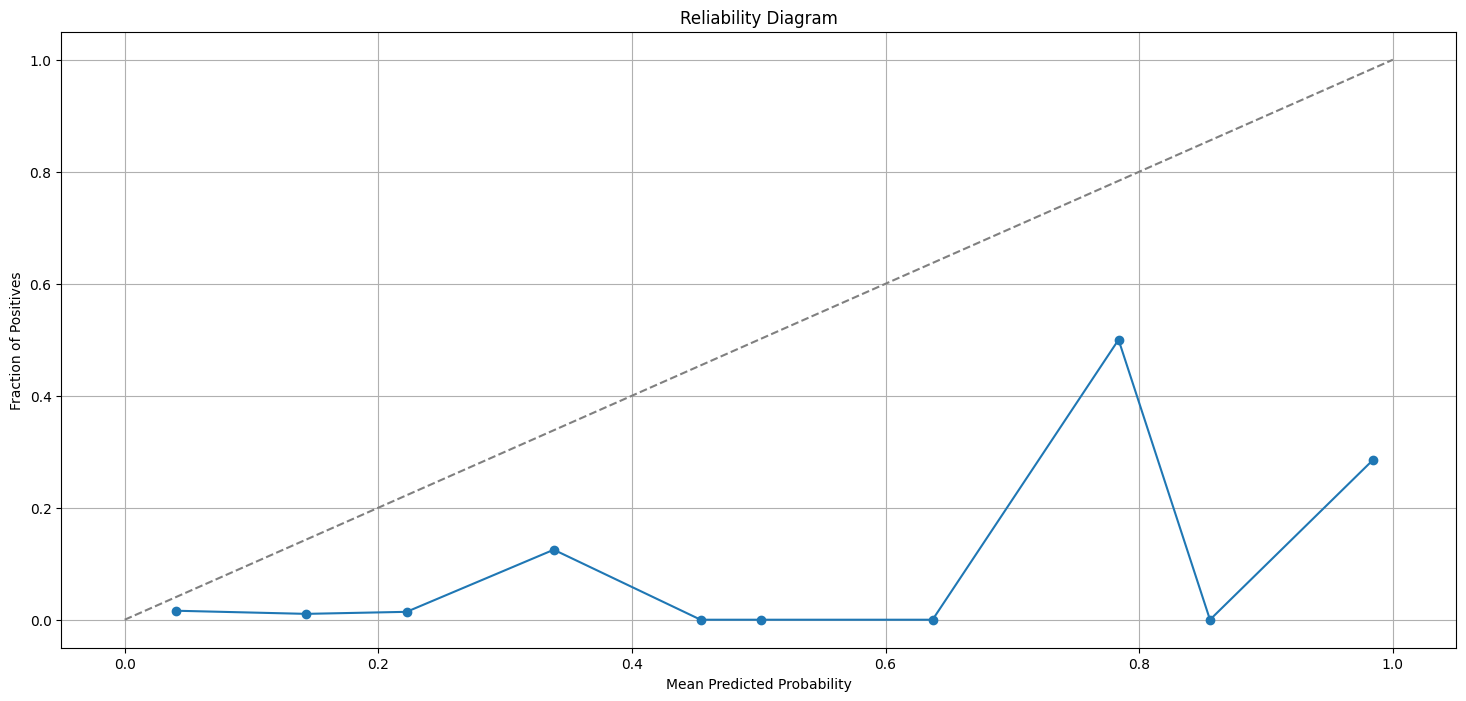

In [33]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

X_test['pred'] = lr.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run

# Compute calibration curve
prob_true, prob_pred = calibration_curve(X_test['is_dispute'], X_test['pred'] , n_bins=10, strategy='uniform')

# Plot reliability diagram
plt.figure(figsize=(18, 8))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for perfect calibration
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.grid(True)
plt.show()


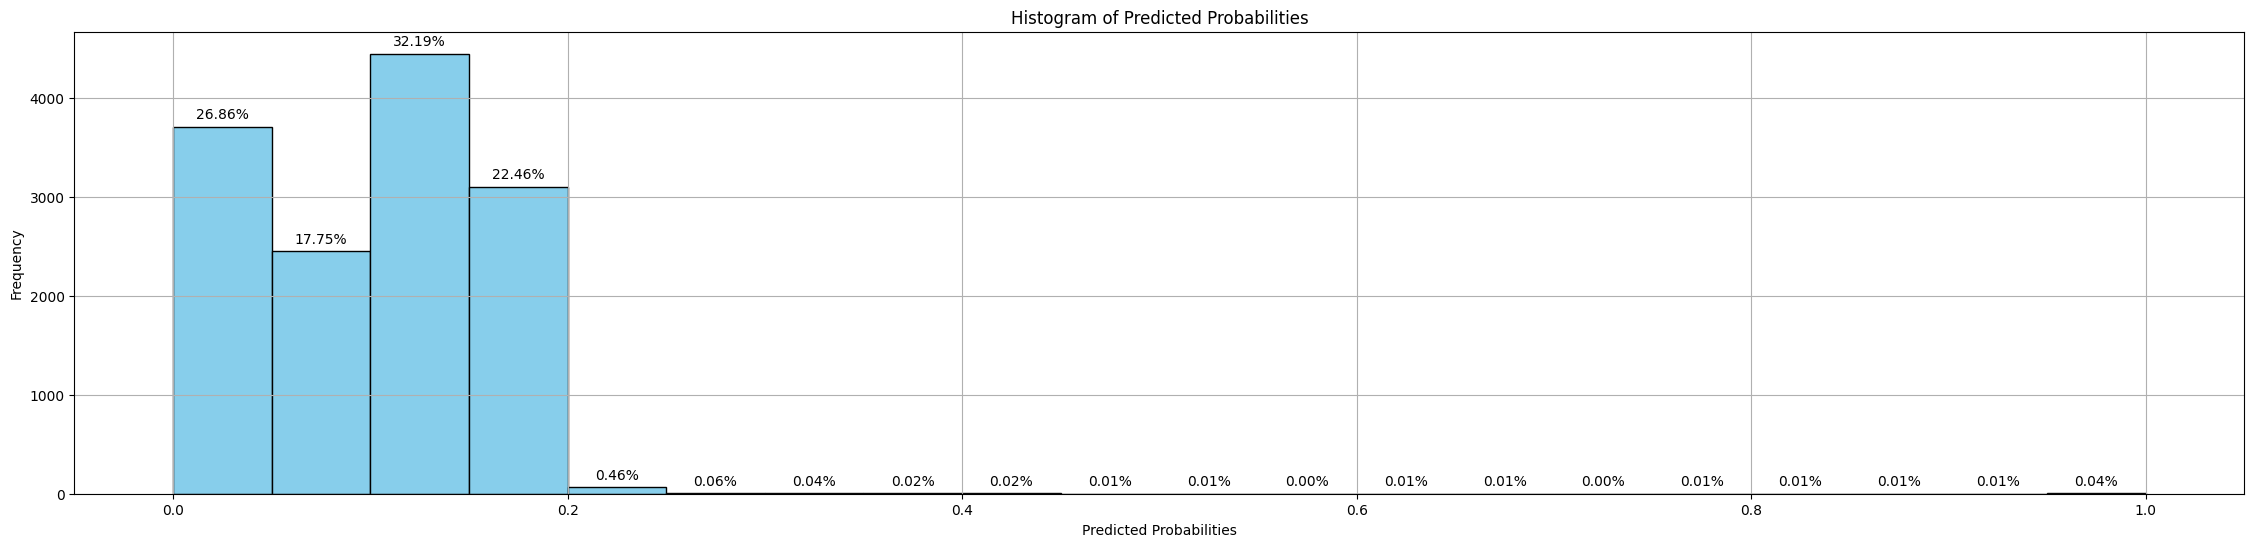

In [34]:
import matplotlib.pyplot as plt

# Assuming X_test['pred'] contains the predicted probabilities
pred_probabilities = X_test['pred']

# Plot histogram
plt.figure(figsize=(28, 6))
n, bins, patches = plt.hist(pred_probabilities, bins=20, color='skyblue', edgecolor='black')

# Compute percentages for each bin
bin_percentages = [(count / len(pred_probabilities)) * 100 for count in n]

# Add labels to bars
for patch, percentage in zip(patches, bin_percentages):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 50, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=1_000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_clusters_per_class=1,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    # "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025, dual="int")),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1
    ),
}

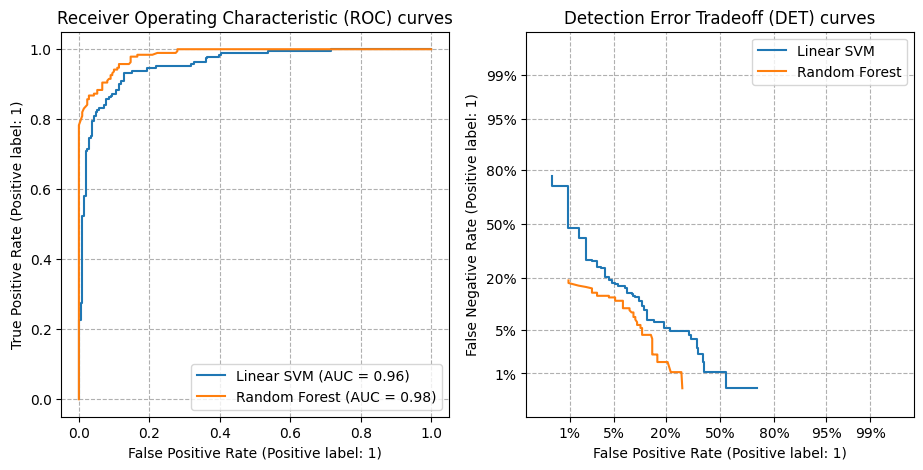

In [11]:
import matplotlib.pyplot as plt

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

# Real Cross-Validation 

This part I want to implement a piece of code that breaks the training into multiple parts. Then it predicts and allocates probabilities. Subsequently it generates a visual and reports the metrics that I need to make decisions. 

For example, I want to see the number of users over time. So, I need to do the following: 

1. Break the dataset 
2. Do a model without one piece and calcualte the predictions and the actuals - You can save this 
3. Return the desired metrics - You can save this 
4. plot the results - You can save this 
5. Calcualte the overall metrics. For example, you can calculate the mean metric, and you can plot all the sampled data. 


### Break the dataset 

In [51]:
# result = result[result['user_matuirity'] == 15].reset_index(drop = False)
# result

In [52]:
validation_sets = 4
# result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()

validation_set_id
(20231001.999, 20231210.0]    9782
(20231210.0, 20231226.0]      9943
(20231226.0, 20240109.0]      9392
(20240109.0, 20240122.0]      9358
dtype: int64

In [53]:
result.groupby('validation_set_id')['disputer'].mean()


validation_set_id
(20231001.999, 20231210.0]    0.006236
(20231210.0, 20231226.0]      0.005934
(20231226.0, 20240109.0]      0.004685
(20240109.0, 20240122.0]      0.003206
Name: disputer, dtype: float64

Warning: The plot belows shows that there is a problem with the data utilised. Overall I think we're considereing to late users and too later payments to obtain dispute rates

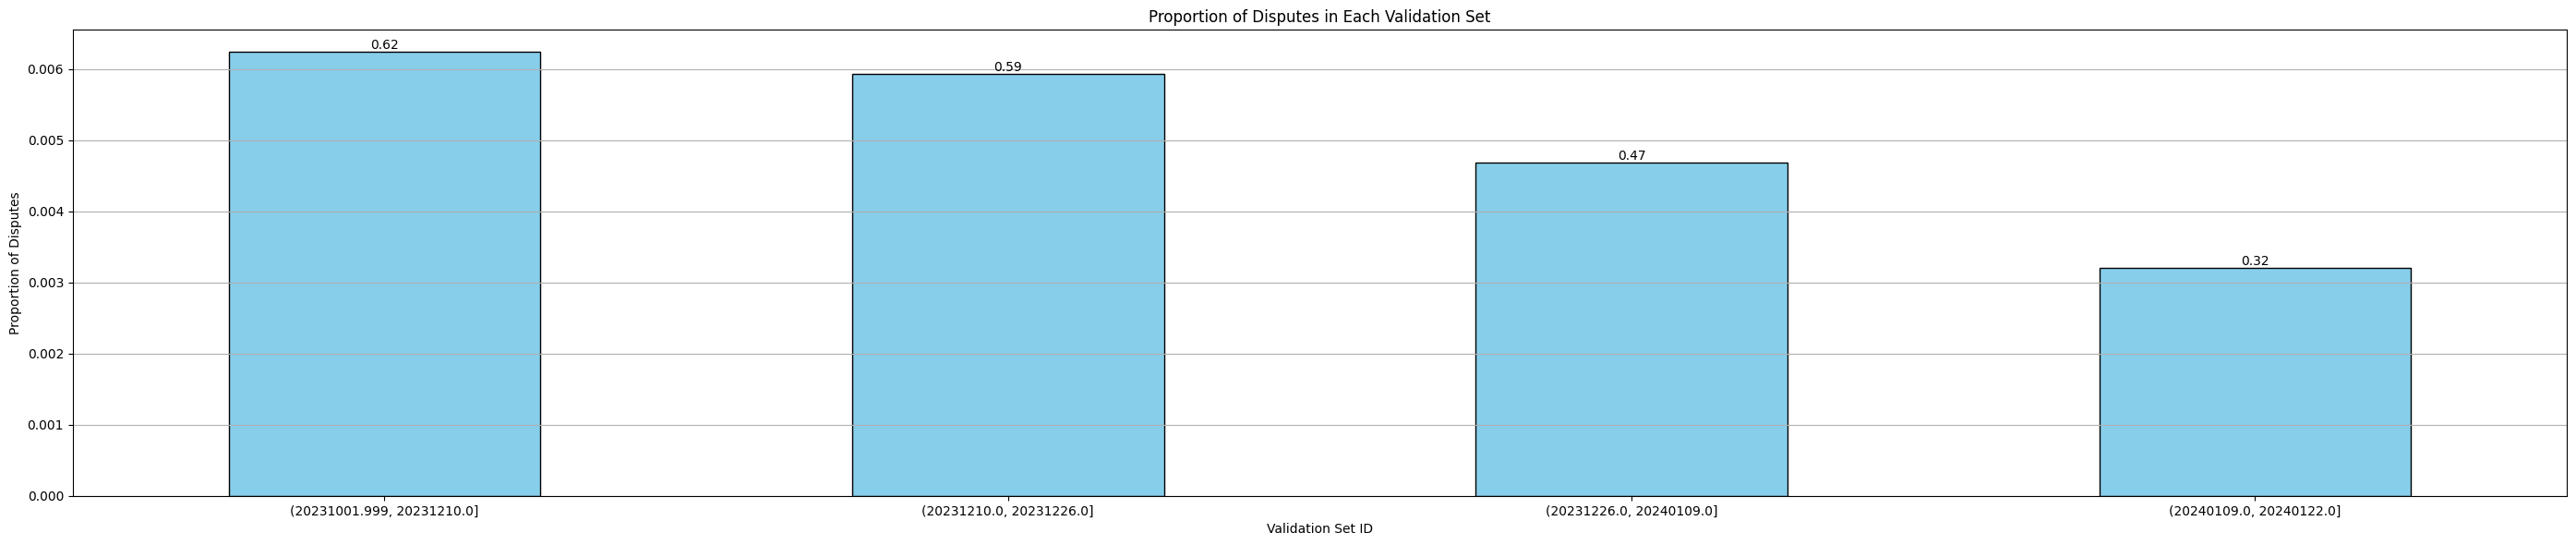

In [54]:
# validation_sets = 3

# # Convert register_time_x to datetime
# result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))

# # Create validation_set_id based on quantiles
# result['validation_set_id'] = pd.qcut(result['date'], validation_sets)

# Calculate the proportion of disputes in each group
proportion_disputes = result.groupby('validation_set_id')['disputer'].mean()

# Plot
plt.figure(figsize=(28, 6))
proportion_disputes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Validation Set ID')
plt.ylabel('Proportion of Disputes')
plt.title('Proportion of Disputes in Each Validation Set')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add gridlines only on the y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Add value labels on top of bars
for i, value in enumerate(proportion_disputes):
    plt.text(i, value, f'{value*100:.2f}', ha='center', va='bottom')

plt.show()


In [55]:
result[payment_cols]

,spent_to_date,max_payment,payments_last_14d,payments_last_7d,games_last_14d,games_last_7d,games_to_date,payments_to_date,spent_last_14d,spent_last_7d,max_daily_spent,daily_pay_std,money_games_to_date,disputer
0,5.00,5.00,0,0,0.0,0.0,235.0,1,0.00,0.00,5.00,1.066004,170.0,0
1,101.00,86.00,0,0,0.0,0.0,651.0,3,0.00,0.00,86.00,18.357678,178.0,0
2,10.00,2.00,0,0,0.0,0.0,1499.0,5,0.00,0.00,10.00,0.426401,941.0,0
3,1.00,1.00,1,0,2073.0,1459.0,2221.0,1,1.00,0.00,1.00,0.213201,437.0,0
4,7.00,7.00,0,0,0.0,0.0,120.0,1,0.00,0.00,7.00,1.492405,45.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38470,3.00,3.00,0,0,0.0,0.0,73.0,1,0.00,0.00,3.00,0.639602,48.0,0
38471,17.00,10.00,0,0,0.0,0.0,946.0,2,0.00,0.00,17.00,2.132007,866.0,0
38472,3.00,3.00,0,0,0.0,0.0,347.0,1,0.00,0.00,3.00,0.639602,176.0,0
38473,1.00,1.00,1,0,806.0,61.0,3339.0,1,1.00,0.00,1.00,0.213201,2697.0,0


In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [
     ('rf', RandomForestClassifier(min_samples_leaf=6, random_state=42)),
     ('rf_2', RandomForestClassifier(min_samples_leaf=30, random_state=42))]

stck = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5), passthrough = True
)


models = {
    'RandomForest_20':            RandomForestClassifier(min_samples_leaf = 20, n_jobs = 5)
    # , 'RandomForest_10':         Ran   domForestClassifier(min_samples_leaf = 6, n_jobs = 5)
    , 'RandomForest_400':         RandomForestClassifier(min_samples_leaf = 5, n_jobs = 5)
    # , 'RandomForest_400':         RandomForestClassifier(min_samples_leaf = 100, n_jobs = 5)
    , 'LogisticRegression':       LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5)
    , 'Stacking':                 stck  # Need to set probability=True for SVC to use predict_proba
    # , 'DecisionTree_350':       DecisionTreeClassifier(min_samples_leaf = 350)
    # , 'DecisionTree_400':       DecisionTreeClassifier(min_samples_leaf = 400)
    , 'DecisionTree_100':         DecisionTreeClassifier(min_samples_leaf = 100)
}

# class_weight
# lr                = LogisticRegression(C = 1.0, max_iter = 180, n_jobs = 5)
# lr                = LogisticRegressionCV(max_iter = 140, l1_ratios = np.logspace(0, 1, 10), cv = 2, n_jobs = 5)
# Random_Forest_40  = RandomForestClassifier(min_samples_leaf = 40, n_jobs = 5)
# Random_Forest_200 = RandomForestClassifier(min_samples_leaf = 200, n_jobs = 5)
# dt                = DecisionTreeClassifier(min_samples_leaf = 350)

# models = [
#     (lr, "Logistic")
#     , (dt, "Classification Tree")
#     , (Random_Forest_40, "Random_Forest_40")
#     , (Random_Forest_200, "Random_Forest_200")
# ]

# Create an empty list to store results
training_results = []

# Loop through each validation set
for validation_set in tqdm(result['validation_set_id'].unique()): 

    # Remove it: 
    train_data = result[result['validation_set_id'] != validation_set][cols + ['disputer']]
    test_data  = result[result['validation_set_id'] == validation_set][cols + ['disputer']]

    # Train and predict with each model
    for model_name, model in models.items():
        X_train, y_train = train_data.drop(columns=['disputer']), train_data['disputer']
        X_test, y_test = test_data.drop(columns=['disputer']), test_data['disputer']
        model.fit(X_train[cols], y_train)
        prob_predictions = model.predict_proba(X_test[cols])[:, 1]

        # Store the predictions along with validation set and model name
        training_results.append(pd.DataFrame({
            'Validation_Set': [validation_set] * len(prob_predictions),
            f'{model_name}_Probability_Predictions': prob_predictions,
            'Actual_Labels': y_test
        }))

# Concatenate all DataFrames into one
training_results = pd.concat(training_results, ignore_index=True)
training_results


100%|██████████| 4/4 [03:31<00:00, 52.99s/it]


,Validation_Set,RandomForest_20_Probability_Predictions,Actual_Labels,RandomForest_400_Probability_Predictions,LogisticRegression_Probability_Predictions,Stacking_Probability_Predictions,DecisionTree_100_Probability_Predictions
0,"(20231001.999, 20231210.0]",0.000014,0,NaN,NaN,NaN,NaN
1,"(20231001.999, 20231210.0]",0.002777,0,NaN,NaN,NaN,NaN
2,"(20231001.999, 20231210.0]",0.005810,0,NaN,NaN,NaN,NaN
3,"(20231001.999, 20231210.0]",0.000000,0,NaN,NaN,NaN,NaN
4,"(20231001.999, 20231210.0]",0.009297,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
192370,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0
192371,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0
192372,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0
192373,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0


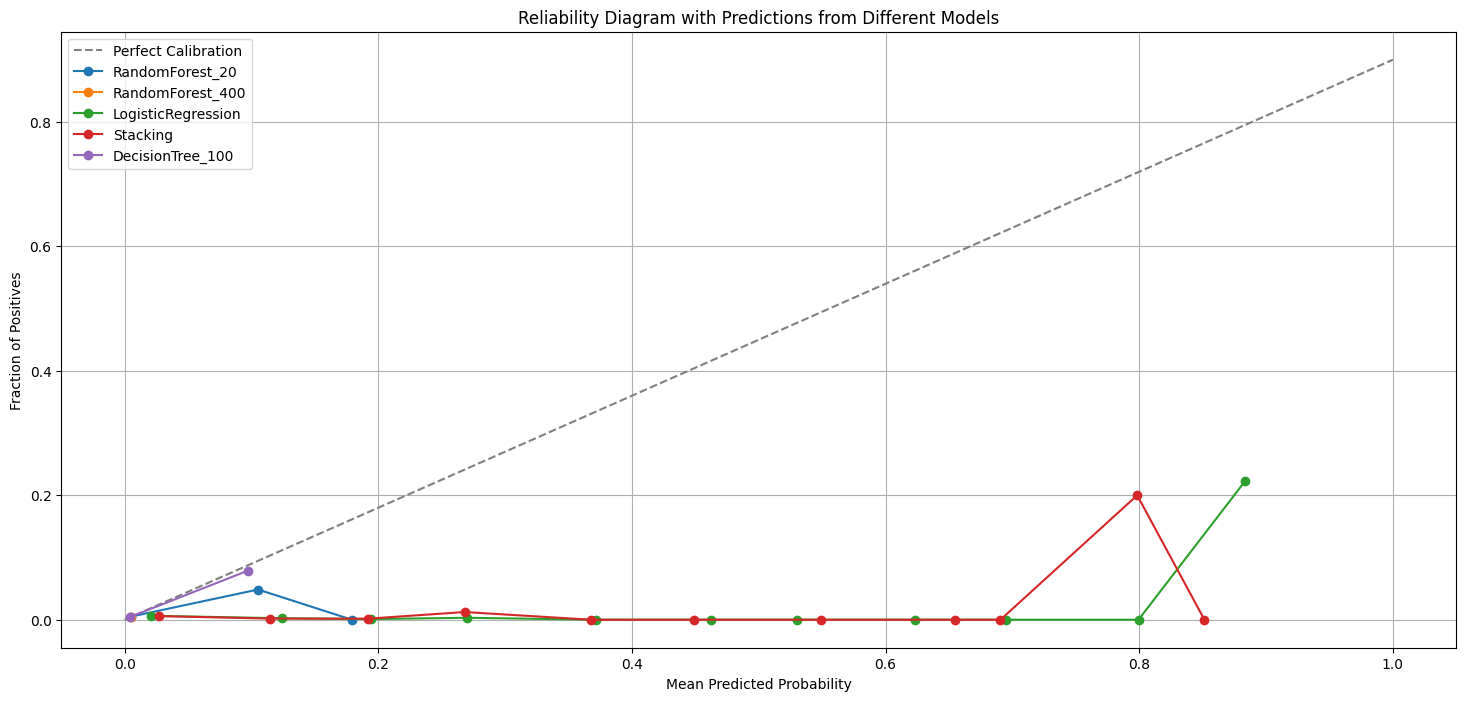

In [58]:

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute calibration curve for each model
plt.figure(figsize=(18, 8))
plt.plot([0, 1], [0, 0.9], linestyle='--', color='gray', label='Perfect Calibration')  # Diagonal line for perfect calibration

for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    model_actual_labels = training_results['Actual_Labels']
    
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(model_actual_labels, model_predictions, n_bins=12, strategy='uniform')

    # Plot reliability diagram for the current model
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=model_name)

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
models.keys()

dict_keys(['RandomForest_20', 'RandomForest_400', 'LogisticRegression', 'Stacking', 'DecisionTree_100'])

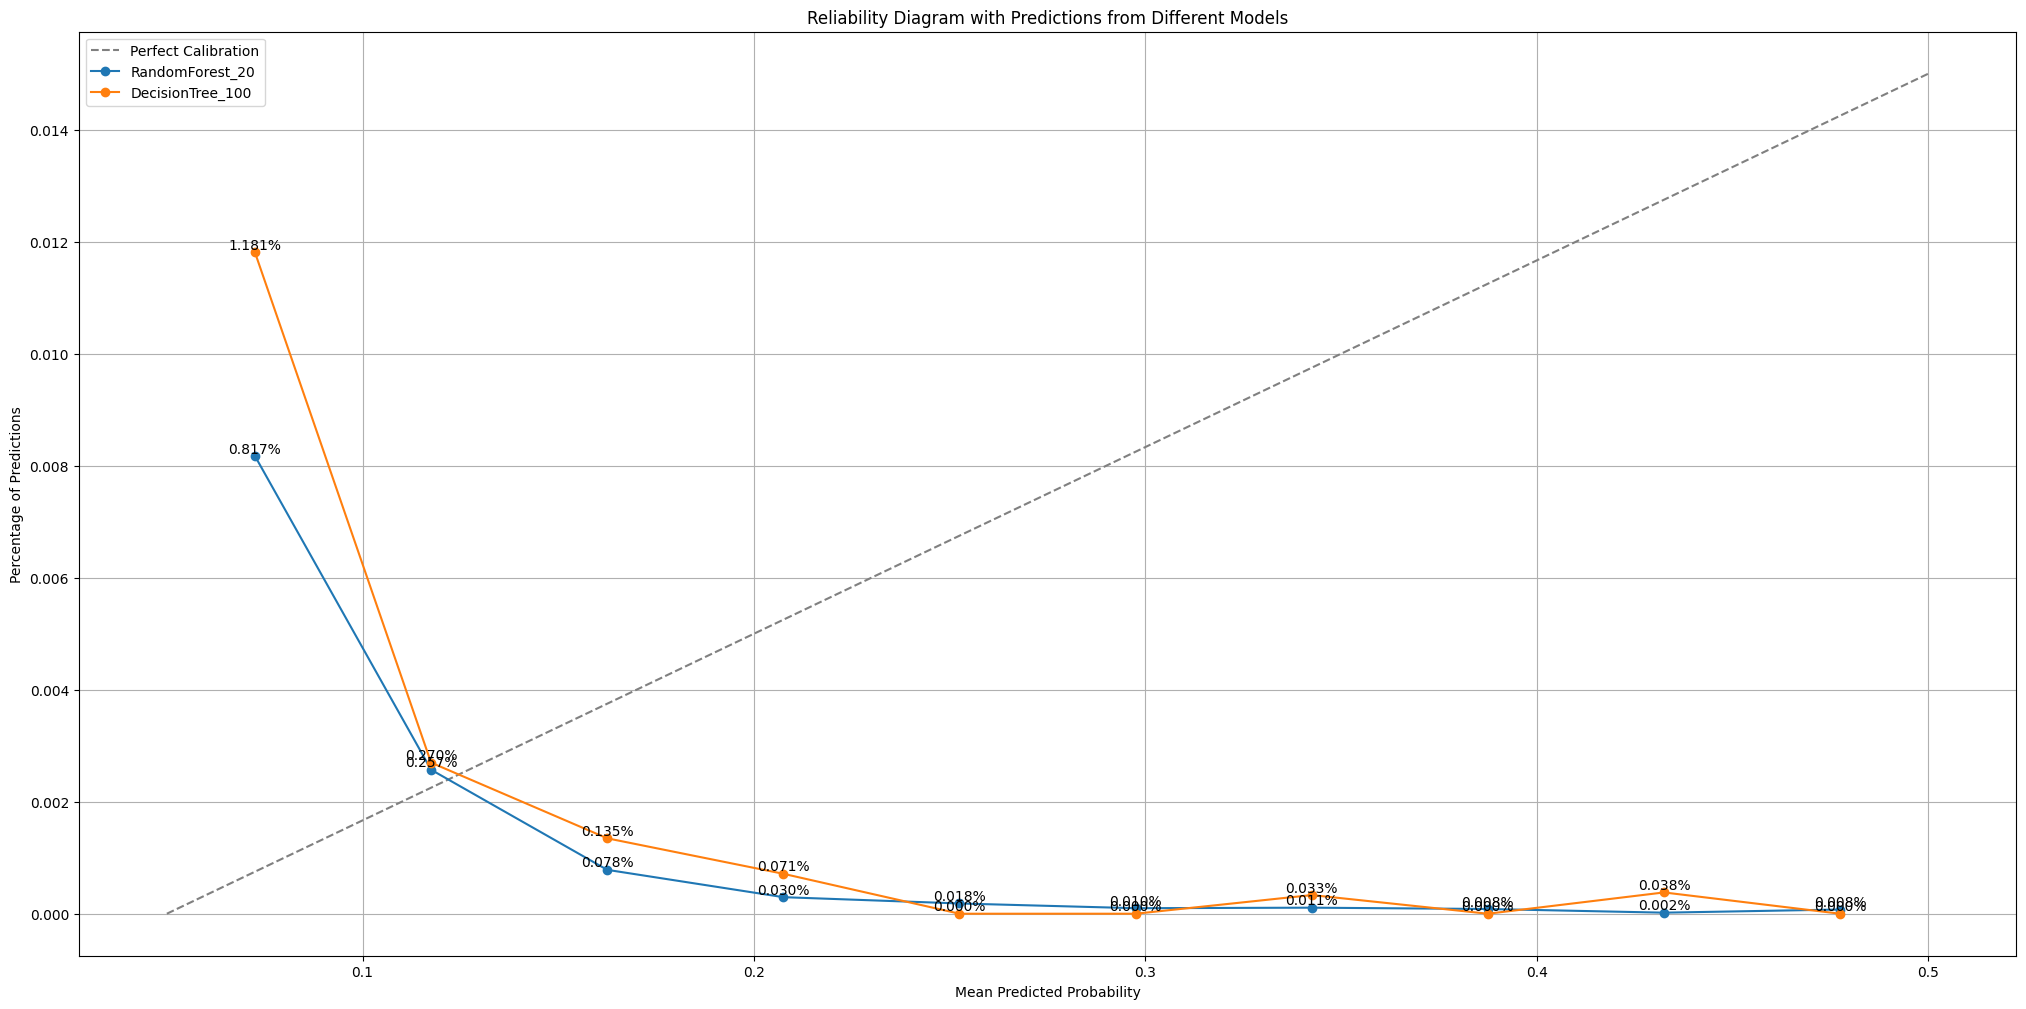

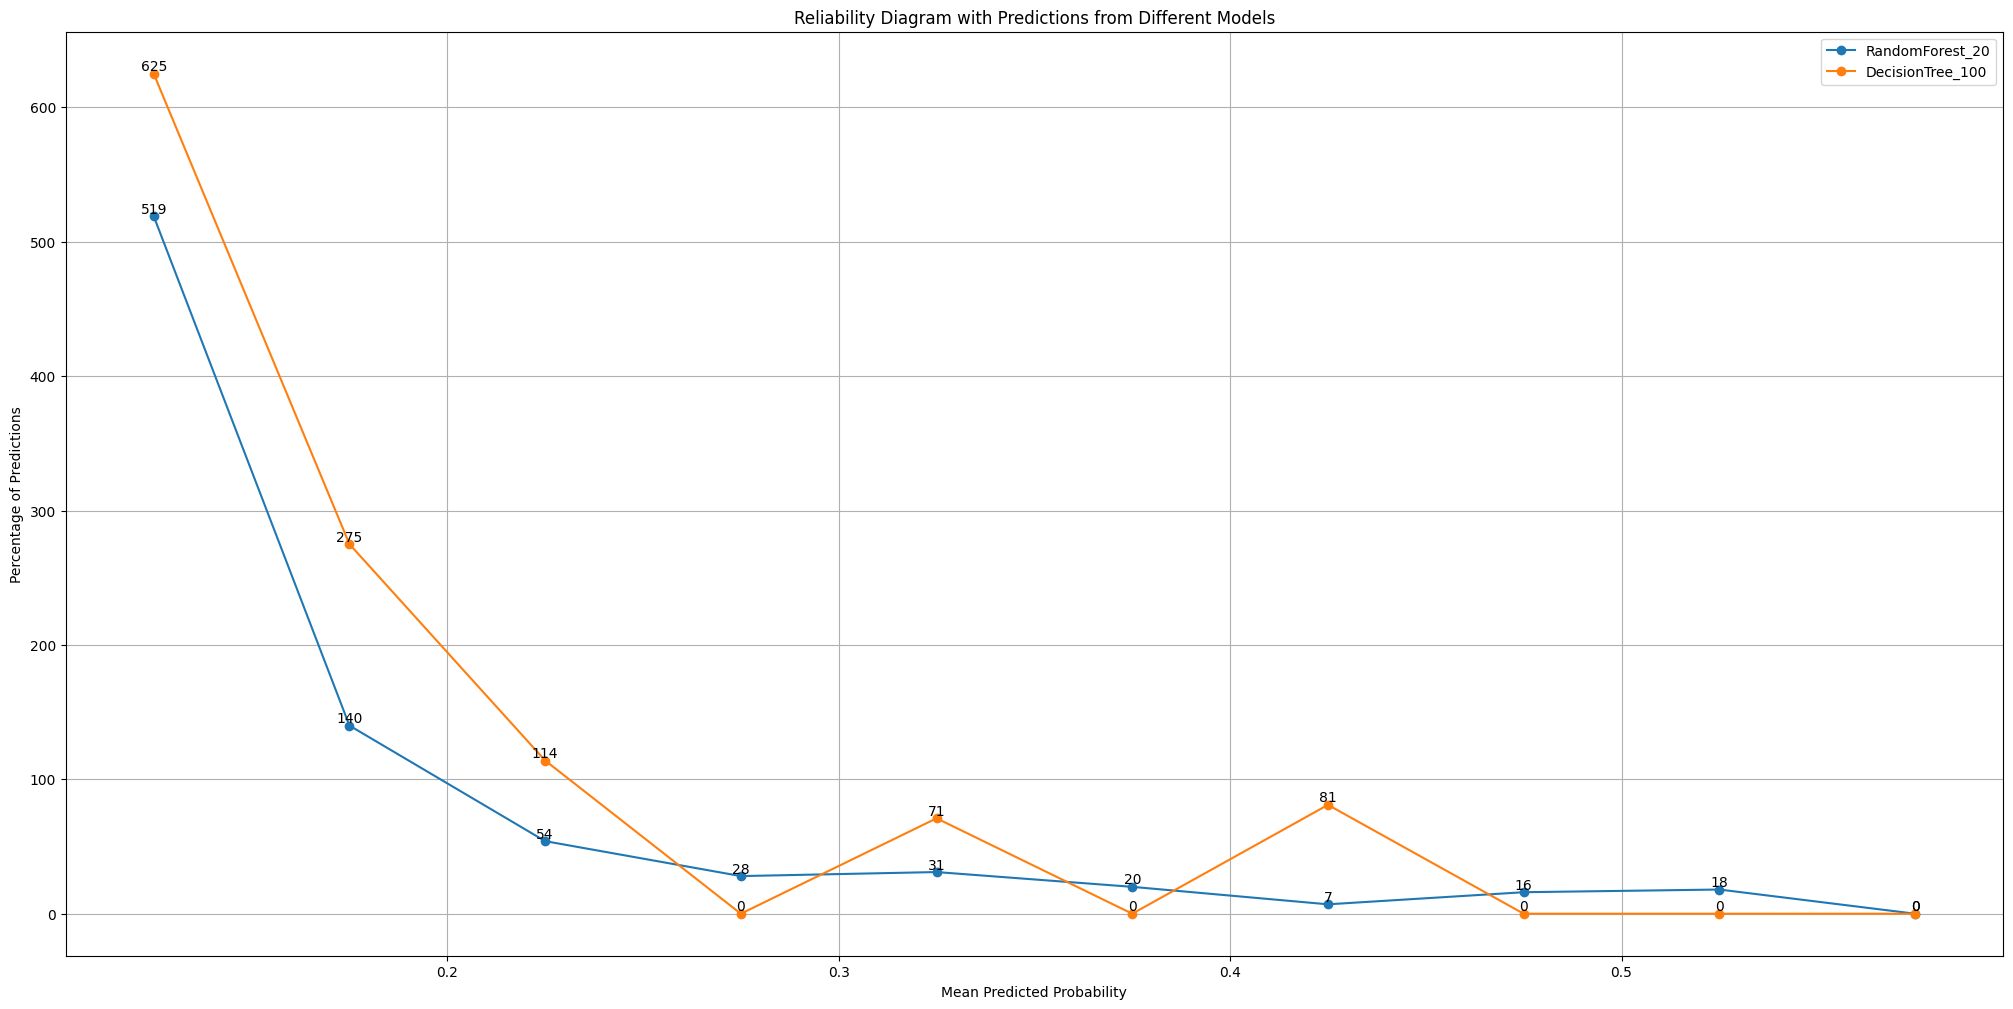

In [50]:
import numpy as np

# Compute calibration curve for each model
plt.figure(figsize=(25, 12))
plt.plot([0.05, 0.5], [0, 0.015], linestyle='--', color='gray', label='Perfect Calibration')  # Diagonal line for perfect calibration

# for model_name in models.keys():
for model_name in ['RandomForest_20', 'DecisionTree_100']:
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    
    # Compute histogram of predicted probabilities
    counts, bins = np.histogram(model_predictions, bins=10, range=(0.05, 0.5))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Compute percentage of predictions in each bin
    percentages = counts / len(model_predictions)
    
    # Plot reliability diagram for the current model
    plt.plot(bin_centers, percentages,  marker='o', linestyle='-', label=model_name)

    # Add labels to the histogram bars
    for i in range(len(bin_centers)):
        plt.text(bin_centers[i], percentages[i], f'{percentages[i]*100:.3f}%', ha='center', va='bottom')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Percentage of Predictions')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(25, 12))

for model_name in ['RandomForest_20', 'DecisionTree_100']:
# for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    
    # Compute histogram of predicted probabilities
    counts, bins = np.histogram(model_predictions, bins=10, range=(0.1, 0.6))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Compute percentage of predictions in each bin
    percentages = counts
    
    # Plot reliability diagram for the current model
    plt.plot(bin_centers, percentages,  marker='o', linestyle='-', label=model_name)

    # Add labels to the histogram bars
    for i in range(len(bin_centers)):
        plt.text(bin_centers[i], percentages[i], f'{percentages[i]}', ha='center', va='bottom')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Percentage of Predictions')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

#check ensembles: 
training_results['best_two'] = training_results['RandomForest_Probability_Predictions'] + training_results['SVC_Probability_Predictions'].fillna(0)

In [ ]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['gini', 'entropy', 'log_loss']
depths = [4,5,6, 7]
leaf_sizes = [200]
cols = ['valid_payments', 'p3', 'p7', 'p14', 'p28']
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size, cols)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)
              

              # try:
              #     model.fit(X_train[cols], y_train)
              #     predictions = model.predict(X_test[cols])
              #     accuracy = accuracy_score(y_test, predictions)
              #     prec = precision_score(y_test, predictions)

              # except:
              #     model = np.nan
              #     predictions = np.nan
              #     mae = np.nan
              #     r2 = np.nan

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])